# Random Background Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin

env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin


## Functions

In [2]:
# split data into GC content matched training and test data
def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
#     print('Target GC Content: ', true_gc_content)
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [3]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [4]:
def signmoid(x):
    result = 1/(1 + np.exp(-x))
    return result

In [5]:
def quantileNormalize(vals1, vals2):
    '''
    input: two scalar arrays
    output: two quantile normalized scalar arrays
    '''
    vals1 = np.array(vals1)
    vals2 = np.array(vals2)
    
    ranks_1 = scipy.stats.rankdata(vals1, method = 'ordinal')
    ranks_2 = scipy.stats.rankdata(vals2, method = 'ordinal')
    
    sorted_vals_1 = sorted(vals1)
    sorted_vals_2 = sorted(vals2)
    means = np.mean([sorted_vals_1,sorted_vals_2], axis=0)
    
    rank_mean_dict = dict(zip(sorted(ranks_1), sorted(means)))
    normalized_vals_1 = np.array([rank_mean_dict[x] for x in ranks_1])
    normalized_vals_2 = np.array([rank_mean_dict[x] for x in ranks_2])
    return normalized_vals_1, normalized_vals_2

def calcMAD(vals):
    '''
    inputs: an array of scalars
    output: median absolute deviation of input array
    Calculates MAD, the median of the absolute values 
    of the differences between the data values and the 
    overall median of the data set
    '''
    overall_median = np.median(vals)
    absolute_distances = [abs(x-overall_median) for x in vals]
    mad = np.median(absolute_distances)
    return mad

def medNormalize(vals1, vals2):
    med_1 = np.median(vals1)
    med_2 = np.median(vals2)
    if med_1 > med_2:
        corrected_vals1 = vals1
        corrected_vals2 = vals2 + (med_1 - med_2)
    else:
        corrected_vals1 = vals1+ (med_2 - med_1)
        corrected_vals2 = vals2
    return corrected_vals1, corrected_vals2

## Copy Score Files

In [6]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_score_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_sequence_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_strand_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_start_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_end_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_sequences/C57BL6J.fa ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_count_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_summedScore_frame_C57BL6J.pickle ./

In [7]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_score_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_sequence_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_strand_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_start_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_end_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_sequences/BALBCJ.fa ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_count_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_summedScore_frame_BALBCJ.pickle ./

## Read in Score Files

### C57Bl6 Data

In [8]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
motif_count_frame = pd.read_pickle('motif_count_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')
motif_summedScore_frame=pd.read_pickle('motif_summedScore_frame_C57BL6J.pickle')

scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

scaler = preprocessing.StandardScaler()
standardized_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
standardized_motif_frame.columns = motif_score_frame.columns.values[3:]
standardized_motif_frame.index = motif_score_frame.index.values

scaler = preprocessing.MinMaxScaler()
normed_summedScore_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_frame.ix[:,3:]))
normed_summedScore_frame.columns = motif_summedScore_frame.columns.values[3:]
normed_summedScore_frame.index = motif_summedScore_frame.index.values

scaler = preprocessing.StandardScaler()
standardized_summedScore_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_frame.ix[:,3:]))
standardized_summedScore_frame.columns = motif_summedScore_frame.columns.values[3:]
standardized_summedScore_frame.index = motif_summedScore_frame.index.values
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')

### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

### BALBCJ Data

In [9]:
motif_score_BALBCJ_frame= pd.read_pickle('motif_score_frame_BALBCJ.pickle')
motif_sequence_BALBCJ_frame = pd.read_pickle('motif_sequence_frame_BALBCJ.pickle')
motif_strand_BALBCJ_BALBCJ_frame = pd.read_pickle('motif_strand_frame_BALBCJ.pickle')
motif_start_BALBCJ_frame = pd.read_pickle('motif_start_frame_BALBCJ.pickle')
motif_end_BALBCJ_frame = pd.read_pickle('motif_end_frame_BALBCJ.pickle')
motif_count_BALBCJ_frame = pd.read_pickle('motif_count_frame_BALBCJ.pickle')

scaler = preprocessing.MinMaxScaler()
normed_motif_BALBCJ_frame = pd.DataFrame(scaler.fit_transform(motif_score_BALBCJ_frame.ix[:,3:]))
normed_motif_BALBCJ_frame.columns = motif_score_BALBCJ_frame.columns.values[3:]
normed_motif_BALBCJ_frame.index = motif_score_BALBCJ_frame.index.values

scaler = preprocessing.StandardScaler()
standardized_BALBCJ_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_BALBCJ_frame.ix[:,3:]))
standardized_BALBCJ_motif_frame.columns = motif_score_BALBCJ_frame.columns.values[3:]
standardized_BALBCJ_motif_frame.index = motif_score_BALBCJ_frame.index.values

### Background Data

In [636]:
# read in peak data data
summary_background_frame = pd.read_csv('./background_group_summary.tsv' , sep='\t')
summary_background_frame = summary_background_frame.fillna('0')
for col in summary_background_frame.columns[5:]:
    floatValues = []
    for val in summary_background_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_background_frame[col] = floatValues
summary_background_frame.index = summary_background_frame['ID'].values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
strain = 'C57BL6J'
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_'+  strain + '.pickle')
motif_sequence_background_frame=pd.read_pickle('motif_sequence_background_frame_'+  strain + '.pickle')
motif_strand_background_frame=pd.read_pickle('motif_strand_background_frame_'+  strain + '.pickle')
motif_start_background_frame=pd.read_pickle('motif_start_background_frame_'+  strain + '.pickle')
motif_end_background_frame=pd.read_pickle('motif_end_background_frame_'+  strain + '.pickle')
motif_count_background_frame=pd.read_pickle('motif_count_background_frame_'+  strain + '.pickle')
motif_summedScore_background_frame_frame=pd.read_pickle('motif_summedScore_background_frame_'+  strain + '.pickle')



In [ ]:
# make sure background frames don't have IDs that overlap with target frame
motif_score_background_frame = motif_score_background_frame[~motif_score_background_frame.index.isin(motif_score_frame.index.values)]
motif_sequence_background_frame = motif_sequence_background_frame[~motif_sequence_background_frame.index.isin(motif_score_frame.index.values)]
motif_strand_background_frame = motif_strand_background_frame[~motif_strand_background_frame.index.isin(motif_score_frame.index.values)]
motif_start_background_frame = motif_start_background_frame[~motif_start_background_frame.index.isin(motif_score_frame.index.values)]
motif_end_background_frame = motif_end_background_frame[~motif_end_background_frame.index.isin(motif_score_frame.index.values)]
motif_count_background_frame = motif_count_background_frame[~motif_count_background_frame.index.isin(motif_score_frame.index.values)]
motif_summedScore_background_frame = motif_summedScore_background_frame[~motif_summedScore_background_frame.index.isin(motif_score_frame.index.values)]

In [ ]:
scaler = preprocessing.StandardScaler()
standardized_motif_background_frame = pd.DataFrame(scaler.fit_transform(motif_score_background_frame.ix[:,3:]))
standardized_motif_background_frame.columns = motif_score_background_frame.columns.values[3:]
standardized_motif_background_frame.index = motif_score_background_frame.index.values
scaler = preprocessing.MinMaxScaler()
normed_motif_background_frame = pd.DataFrame(scaler.fit_transform(motif_score_background_frame.ix[:,3:]))
normed_motif_background_frame.columns = motif_score_background_frame.columns.values[3:]
normed_motif_background_frame.index = motif_score_background_frame.index.values
scaler = preprocessing.StandardScaler()
standardized_summedScore_background_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_background_frame.ix[:,3:]))
standardized_summedScore_background_frame.columns = motif_summedScore_background_frame.columns.values[3:]
standardized_summedScore_background_frame.index = motif_summedScore_background_frame.index.values
scaler = preprocessing.MinMaxScaler()
normed_summedScore_background_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_background_frame.ix[:,3:]))
normed_summedScore_background_frame.columns = motif_summedScore_background_frame.columns.values[3:]
normed_summedScore_background_frame.index = motif_summedScore_background_frame.index.values

## Create background peaks from genomic sequences from each chromosome

In [6]:
def getRandomBackground(target_positions, 
                        size_ratio = 1.0, 
                        tolerance = 0.01, 
                        N_threshold = 0.5 ):
    '''
    target_sequences: 2D numpy array, list of genomic coordinates for target sequences [[chr,start,end],...]
    size_ratio: float, number of background sequences relative to target sequences
    tolerance: float, max difference in GC content between True and background labelled samples
    *** Uses mm10 genome taken from Homer ***
    '''
    
    ###load mm10 genome into memory
    
    # index target positions
    # {chr:[]}, value is chromosome length boolean array
    # largest chromosome has 200 million bps 
    _chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' , 
                    'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10', 
                    'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 
                    'chr16', 'chr17', 'chr18', 'chr19', 'chrX']
    _chrom_size_dict = {}
    _chrom_seq_dict = {}
    for chrom in _chromosomes:
        with open('./mm10_genome/' + chrom + '.fa') as f:
            data = f.readlines()
        seq = ''.join(x.upper().strip() for x in data[1:])
        size = len(seq)
        _chrom_size_dict[chrom] = size
        _chrom_seq_dict[chrom] = seq
    _numChromosomes = len(_chromosomes)
    
    target_chr_position_dict = {x:np.zeros(200000000) for x in _chromosomes} 
    ### initialize target_chr_position_dict using target positions
    ### retreive target sequences
    target_sequences = []
    for pos in target_positions:
        chrom = pos[0]        
        start = pos[1]
        end = pos[2]
        target_chr_position_dict[chrom][start-1:end] = 1 # use 0 indexing of position, versus 1 indexing used in fasta
        seq = _chrom_seq_dict[chrom][start:(end+1)]
        target_sequences.append(seq)
    ### calculate GC content and average length of the target sequences
    target_gc_count = 0
    target_length_count = 0
    for s in target_sequences:
        target_gc_count += s.count('G')
        target_gc_count += s.count('C')
        target_length_count += len(s)
    target_gc_content = target_gc_count/(target_length_count+0.0000001) # GC content of target sequences
    mean_target_length = target_length_count/len(target_sequences) # average length of target sequences
    mean_target_length = int(mean_target_length)
    
    ### select random genomic loci such that they do no overlap target sequences
    numSelected = 0
    numToSelect = len(target_positions) * size_ratio * 2 # candidate pool of background seqs is 2X larger
    candidate_positions = []
    numNallowed = int(N_threshold * mean_target_length) # number of allowable Ns
    counter = 0
    while numSelected < numToSelect:
        if counter % 100000 == 0:
            print(counter, numSelected)
        # select random chromsome
        chromIndex = np.random.randint(_numChromosomes)
        randChrom = _chromosomes[chromIndex]
        randChromSize = _chrom_size_dict[randChrom]
        # must find non overlapping segment on this chromosome before moving on
        selectedSequence = False
        while not selectedSequence:
            counter += 1
            randStart = np.random.randint(randChromSize)
            randEnd = randStart + mean_target_length
            overlap_sum = np.sum(target_chr_position_dict[randChrom][randStart:(randEnd + 1)])
            
            if not overlap_sum > 0:
                randSeq = _chrom_seq_dict[randChrom][randStart:(randEnd+1)]
                numN = randSeq.count('N')
                if numN <= numNallowed:
                    rand_gc_count = randSeq.count('G')+ randSeq.count('C')
                    rand_gc = rand_gc_count/mean_target_length
                    if abs(target_gc_content - rand_gc) <= tolerance:
                        selectedSequence = True
                        numSelected+=1
                        candidate_positions.append([randChrom, randStart, randEnd, randSeq])
    # calcuate GC content of background samples
    background_gc_count = 0
    background_length = 0
    for cp in candidate_positions:
        s = cp[3]
        background_gc_count += s.count('G')
        background_gc_count += s.count('C')
        background_length += len(s)
    background_gc_content = background_gc_count/(background_length+0.0000001)
    print(target_gc_content,background_gc_content)
    return candidate_positions

In [234]:
# generate random genomic background for all monomers
strain = 'c57bl6'
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_positions = summary_frame[summary_frame.index.isin(target_indices)][['chr', 'start', 'end']].values
        start = time.time()
        backgroundPositions = getRandomBackground(target_positions, N_threshold =1.0, tolerance=0.05, size_ratio=5)
        end = time.time()
        print(monomer, treatment, end - start)
        pickle.dump(backgroundPositions,open('./background_pickles/' + monomer + '_' + treatment + '_background.pickle', 'wb'))

### Background positions to create peak files


In [26]:
strain = 'c57bl6'
! if [ ! -d ./background_peak_files ]; then mkdir ./background_peak_files; fi
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        backgroundPositions = pickle.load(open('./background_pickles/' + monomer + '_' + treatment + '_background.pickle', 'rb'))
        outFile = open('./background_peak_files/' + strain + '_' + monomer + '_' + treatment + '-background_peaks.tsv' , 'w')
        outFile.write('\t'.join(['#PeakID','chr','start','end','strand','idrScore', 'count','\n']))
        counter = 0
        for pos in backgroundPositions:
            chrom = pos[0]
            start = str(pos[1])
            end = str(pos[2])
            strand = '+' # arbitrary - for compatibility with downstream scripts
            score = '1' # arbitrary - for compatibility with downstream scripts
            randID = 'background_' + str(np.random.randint(10000)) + '_' + str(counter)
            counter += 1
            outFile.write('\t'.join([randID, chrom, start, end, strand, score, score, '\n']))
        outFile.close()
        
    

### Merge Peak Files

In [27]:
%%capture
! mergePeaks -d given ./background_peak_files/*tsv > ./background_merged_peaks.tsv


In [28]:
! makeSummaryFile.py ./background_merged_peaks.tsv ./background_group_summary.tsv ./background_peak_files/*

sys:1: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
Finished reading merged peak file...
Integrating scores for c57bl6_atf3_kla-background
Integrating scores for c57bl6_atf3_veh-background
Integrating scores for c57bl6_cjun_kla-background
Integrating scores for c57bl6_cjun_veh-background
Integrating scores for c57bl6_fos_kla-background
Integrating scores for c57bl6_fos_veh-background
Integrating scores for c57bl6_junb_kla-background
Integrating scores for c57bl6_junb_veh-background
Integrating scores for c57bl6_jund_kla-background
Integrating scores for c57bl6_jund_veh-background


In [9]:
# read in peak data data
summary_background_frame = pd.read_csv('./background_group_summary.tsv' , sep='\t')
summary_background_frame = summary_background_frame.fillna('0')
for col in summary_background_frame.columns[5:]:
    floatValues = []
    for val in summary_background_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_background_frame[col] = floatValues
summary_background_frame.index = summary_background_frame['ID'].values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### create a script to scan for motifs using FIMO



In [29]:
%%bash
if [ ! -d ./peak_sequences ] ;
    then mkdir ./peak_sequences
else
    rm ./peak_sequences/*
fi

In [37]:
%%bash
perl /home/vlink/mouse_strains/marge/analysis/extract_seq_from_peakfiles.pl -strains C57BL6J -file ./background_merged_peaks.tsv -output ./peak_sequences/C57BL6J_marge.fa





Saving peaks
Loading shift vectors


In [39]:
# reformat fastq files to use homer peak IDs

coordinate_peakID_dict = {} # {chr_start_end:homerID}
with open ('./background_merged_peaks.tsv') as f:
    data = f.readlines()
for line in data[1:]:
    tokens = line.split('\t')
    coordinate = '_'.join(tokens[1:4])
    peakID = tokens[0].strip()
    coordinate_peakID_dict[coordinate] = tokens[0]



In [40]:
for fastaFile in os.listdir('./peak_sequences/'):
    if 'marge' in fastaFile:
        strain = fastaFile.split('_')[0]
        outFile = open('./peak_sequences/' + fastaFile.replace('_marge',''), 'w')
        print(fastaFile)
        with open('./peak_sequences/' + fastaFile) as f:
            data = f.readlines()
        for line in data:
            if '>' in line:
                coordinate = line[1:].replace('_'+strain,'').strip()
                
                peakID = coordinate_peakID_dict[coordinate]
                outFile.write('>' + peakID + '\n')
               
            else:
                outFile.write(line)
        outFile.close()

C57BL6J_marge.fa


In [252]:
!cp ./peak_sequences/C57BL6J.fa ./C57BL6J_background.fa

In [63]:
# create a script to scan for motifs using FIMO
! if [ ! -d /home/jtao/analysis/random_background_analysis/fimo_results/ ]; then mkdir /home/jtao/analysis/random_background_analysis/fimo_results/; fi
! if [ ! -d /home/jtao/analysis/random_background_analysis/fimo_out/ ]; then mkdir /home/jtao/analysis/random_background_analysis/fimo_out/; fi
! rm -rf ./fimo_out/*
! rm -rf ./fimo_result/*


pthresh = 0.01
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

fimo_results_dir = './fimo_results'

for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]
        count = 0
        scriptFile = open('scanMotifs_background_'+ strain +'.sh','w')
        for m in os.listdir(motif_dir):
            if 'fimo' in m:
                fimo_out_dir = './fimo_out/' + strain + '_' +m.replace('.fimo','')
                outPath = fimo_results_dir + '/' +strain + '_' + m.replace('.fimo','') +'.txt'
                scriptFile.write(
                    '(sleep ' + str(15 * count) + 
                    's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
                    str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
                    motif_dir + '/' + m + ' ./peak_sequences/' + fastaFile +
                    '> ' + outPath + ' ) & \n')
                count+=1
        scriptFile.close()




C57BL6J.fa


In [ ]:
%%bash
chmod a+x ./scanMotifs*.sh
for i in ./scanMotifs*sh; 
    do echo 'sleeping...';
    echo $i;
    $i;
#     sleep 5m;
done



### Read in Motif Scores

In [ ]:
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]

        peak_start_dict = dict(zip(summary_background_frame['ID'].values, summary_background_frame['start'].values))

        motif_score_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_score_background_frame.index=motif_score_background_frame['ID'].values

        motif_sequence_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_sequence_background_frame.index=motif_score_background_frame['ID'].values

        motif_strand_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_strand_background_frame.index=motif_score_background_frame['ID'].values

        motif_start_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_start_background_frame.index=motif_score_background_frame['ID'].values

        motif_end_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_end_background_frame.index=motif_score_background_frame['ID'].values

        motif_count_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_count_background_frame.index = motif_count_background_frame['ID'].values

        counter=0
        for m in sorted(os.listdir(motif_dir)):
            counter+=1
            if '.fimo' in m:
                print(counter,m)
                motif_results = './fimo_results/' + strain + '_' + m.replace('.fimo','') +'.txt'
                fimo_result_background_frame=pd.read_csv(motif_results, 
                                              skiprows=1,
                                              names=['motif_name', 
                                                     'peak_id', 
                                                     'start', 
                                                     'stop', 
                                                     'strand', 
                                                     'score', 
                                                     'pvalue', 
                                                     'sequence'],
                                              sep='\t')
                motif_name = m.replace('.fimo','')

                id_count_dict = {} #{PeakID:motifCount}
                id_values_dict = {} # {PeakID:(motifScore, motifSequence, motifStrand, motifStart, motifEnd)}

                ids = fimo_result_background_frame['peak_id'].values
                scores = fimo_result_background_frame['score'].values
                strands = fimo_result_background_frame['strand'].values
                sequences = fimo_result_background_frame['sequence']
                starts = fimo_result_background_frame['start']
                ends = fimo_result_background_frame['stop']

                for i in range(len(ids)):
                    currentScore = float(scores[i])
                    currentSequence = sequences[i]
                    currentStrand = strands[i]
                    currentStart = int(starts[i])
                    currentEnd = int(ends[i])

                    if currentScore < 0.0:
                        currentScore = 0.0
                    
                    
                    values = (currentScore, currentSequence, currentStrand, currentStart, currentEnd)

                    if ids[i] in id_values_dict:
                        if currentScore > id_values_dict[ids[i]][0]:
                            id_values_dict[ids[i]] = values
                            id_count_dict[ids[i]] += 1
                    else:
                        id_values_dict[ids[i]] = values
                        id_count_dict[ids[i]] = 1

                sorted_values = [id_values_dict[x] if x in id_values_dict else (0,'','?',-1,-1,0) for x in  motif_score_background_frame['ID'].values]
                sorted_scores = [x[0] for x in sorted_values]
                sorted_sequences = [x[1] for x in sorted_values]
                sorted_strands = [x[2] for x in sorted_values]
                sorted_starts = [x[3] for x in sorted_values]
                sorted_ends = [x[4] for x in sorted_values]
                sorted_counts = [id_count_dict[x] if x in id_count_dict else 0 for x in motif_score_background_frame['ID'].values]

                motif_score_background_frame[motif_name] = sorted_scores
                motif_sequence_background_frame[motif_name] = sorted_sequences
                motif_strand_background_frame[motif_name] = sorted_strands
                motif_start_background_frame[motif_name] = sorted_starts
                motif_end_background_frame[motif_name] = sorted_ends
                motif_count_background_frame[motif_name] = sorted_counts


        motif_score_background_frame.to_pickle('motif_score_background_frame_'+  strain + '.pickle')
        motif_score_background_frame.to_csv('motif_scores_'+  strain + '.tsv', sep='\t', index=False)

        motif_sequence_background_frame.to_pickle('motif_sequence_background_frame_'+  strain + '.pickle')
        motif_sequence_background_frame.to_csv('motif_sequence_'+  strain + '.tsv', sep='\t', index=False)

        motif_strand_background_frame.to_pickle('motif_strand_background_frame_'+  strain + '.pickle')
        motif_strand_background_frame.to_csv('motif_strand_'+  strain + '.tsv', sep='\t', index=False)

        motif_start_background_frame.to_pickle('motif_start_background_frame_'+  strain + '.pickle')
        motif_start_background_frame.to_csv('motif_start_background_frame_'+  strain + '.tsv', sep='\t', index=False)

        motif_end_background_frame.to_pickle('motif_end_background_frame_'+  strain + '.pickle')
        motif_end_background_frame.to_csv('motif_end_background_frame_'+  strain + '.tsv', sep='\t', index=False)

        motif_count_background_frame.to_pickle('motif_count_background_frame_'+  strain + '.pickle')
        motif_count_background_frame.to_csv('motif_count_background_frame_'+  strain + '.tsv', sep='\t', index=False)



In [875]:
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]

        peak_start_dict = dict(zip(summary_frame['ID'].values, summary_frame['start'].values))

        motif_summedScore_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_summedScore_background_frame.index=motif_summedScore_background_frame['ID'].values

        counter=0
        for m in sorted(os.listdir(motif_dir)):
            counter+=1
            if '.fimo' in m:
                print(counter,m)
                motif_results = './fimo_results/' + strain + '_' + m.replace('.fimo','') +'.txt'
                fimo_result_frame=pd.read_csv(motif_results, 
                                              skiprows=1,
                                              names=['motif_name', 
                                                     'peak_id', 
                                                     'start', 
                                                     'stop', 
                                                     'strand', 
                                                     'score', 
                                                     'pvalue', 
                                                     'sequence'],
                                              sep='\t')
                motif_name = m.replace('.fimo','')
                
                id_summedScores_dict = {} #{PeakID:summedMotifScore}
                
                ids = fimo_result_frame['peak_id'].values
                scores = fimo_result_frame['score'].values

                for i in range(len(ids)):
                    currentScore = float(scores[i])

                    if currentScore < 1.0:
                        currentScore = 1.0
                    
                    if ids[i] in id_summedScores_dict:
                        id_summedScores_dict[ids[i]] += np.power(currentScore,2)
                    else:
                        id_summedScores_dict[ids[i]] = np.power(currentScore,2)
                sorted_summedScores = [np.log2(np.max([id_summedScores_dict[x],1])) if x in id_summedScores_dict else 0 for x in motif_summedScore_background_frame['ID'].values]

                motif_summedScore_background_frame[motif_name] = sorted_summedScores
        motif_summedScore_background_frame.to_pickle('motif_summedScore_background_frame_'+  strain + '.pickle')
        motif_summedScore_background_frame.to_csv('motif_summedScore_background_frame_'+  strain + '.tsv', sep='\t', index=False)

C57BL6J.fa
1 alx1_alx4_arx.fimo


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2 ap-1.fimo
3 ar_nr3c1_nr3c2.fimo
4 arid3a.fimo
5 arid3b.fimo
6 arid5a.fimo
7 arnt_mycn.fimo
8 arntl_mitf.fimo
9 ascl2_nhlh1.fimo
10 atf7_batf3_creb5.fimo
11 bcl6.fimo
12 bcl6b.fimo
13 bhlh.fimo
14 bhlha15.fimo
15 bhlhe23.fimo
16 cdx.fimo
17 cebp.fimo
18 cenpb.fimo
19 creb3-l1.fimo
20 crem.fimo
21 ctcf.fimo
22 cux.fimo
23 dbp_hlf_tef.fimo
24 dmbx1.fimo
25 dmrt3.fimo
26 dux.fimo
27 dux4.fimo
28 duxa.fimo
29 e2f1.fimo
30 e2f2.fimo
31 e2f4_e2f6.fimo
32 e2f7.fimo
33 e2f8.fimo
34 ebf1.fimo
35 ebox.fimo
36 egr.fimo
37 elf.fimo
38 elk_etv.fimo
39 esr1.fimo
40 esr2.fimo
41 esrr.fimo
42 ewsr1-fli1.fimo
43 figla_id4_snai2_tcf3_tcf4.fimo
44 fox.fimo
45 gata.fimo
46 gcm.fimo
47 gfi1.fimo
48 gfi1b.fimo
49 gli2.fimo
50 glis.fimo
51 gmeb2.fimo
52 grhl1.fimo
53 gsc.fimo
54 hes.fimo
55 hic.fimo
56 hinfp.fimo
57 hltf.fimo
58 hnf1.fimo
59 hnf4a.fimo
60 hnf4g.fimo
61 homeobox-1.fimo
62 homeobox-2.fimo
63 homeobox-3.fimo
64 homeobox-4.fimo
65 homeobox-5.fimo
66 hoxa11.fimo
67 hoxa5.fimo
68 hoxa9.fimo
69 ho

## Run Classifier using Open Chromatin Background

In [52]:
numIterations = 5
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
test_size = 0.8
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  



In [53]:

# for monomers using all motifs
strain = 'c57bl6'
factor_auc_dict = {}
factor_precision_dict = {}
factor_coeff_dict = {}
factor_prob_dict = {}
factor_meanCoeff_dict = {}
factor_intercept_dict = {}
factor_meanIntercept_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)][strain + '_' + monomer + '_' + treatment] > 0.0
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                probs = lr_classifier.predict_proba(features)[:, 1]

                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])
                
                if all_probs == None:
                    all_probs = probs
                else:
                    all_probs = all_probs + probs
            mean_coefficients = np.mean(all_coefficients, axis=0)
            
            factor_auc_dict[monomer + '_' + treatment]= all_aucs
            factor_precision_dict[monomer + '_' + treatment] = all_precisions
            factor_coeff_dict[monomer + '_' + treatment] = all_coefficients
            factor_prob_dict[monomer + '_' + treatment] = all_probs
            factor_meanCoeff_dict[monomer + '_' + treatment] = mean_coefficients
            factor_intercept_dict[monomer + '_' + treatment] = all_intercepts
            factor_meanIntercept_dict[monomer + '_' + treatment] = np.mean(all_intercepts)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.832027823015 1.40519614985e-06 precision: 0.706484731905 2.03184009061e-06 numTestPositives: 17575
cjun_veh roc: 0.805465729082 1.93345838302e-06 precision: 0.46280774548 1.66540966928e-06 numTestPositives: 10125
fos_veh roc: 0.838099628864 1.53526856337e-05 precision: 0.320347365018 2.94270817102e-05 numTestPositives: 1598
junb_veh roc: 0.642582009548 0.000223027252849 precision: 0.0179831424139 3.51794167446e-06 numTestPositives: 382
jund_veh roc: 0.802998908058 1.01653489646e-06 precision: 0.560064310855 1.24356725515e-06 numTestPositives: 14495
atf3_kla roc: 0.828123000139 3.08005725446e-06 precision: 0.800281389227 8.12616722565e-06 numTestPositives: 27801
cjun_kla roc: 0.801471628805 8.97099826247e-07 precision: 0.47365656171 6.04360519473e-07 numTestPositives: 12949
fos_kla roc: 0.827997142178 7.92787873747e-07 precision: 0.656560334401 6.81595029957e-06 numTestPositives: 17262
junb_kla roc: 0.822788587275 1.53648860505e-06 precision: 0.470662626593 2.34345311066

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


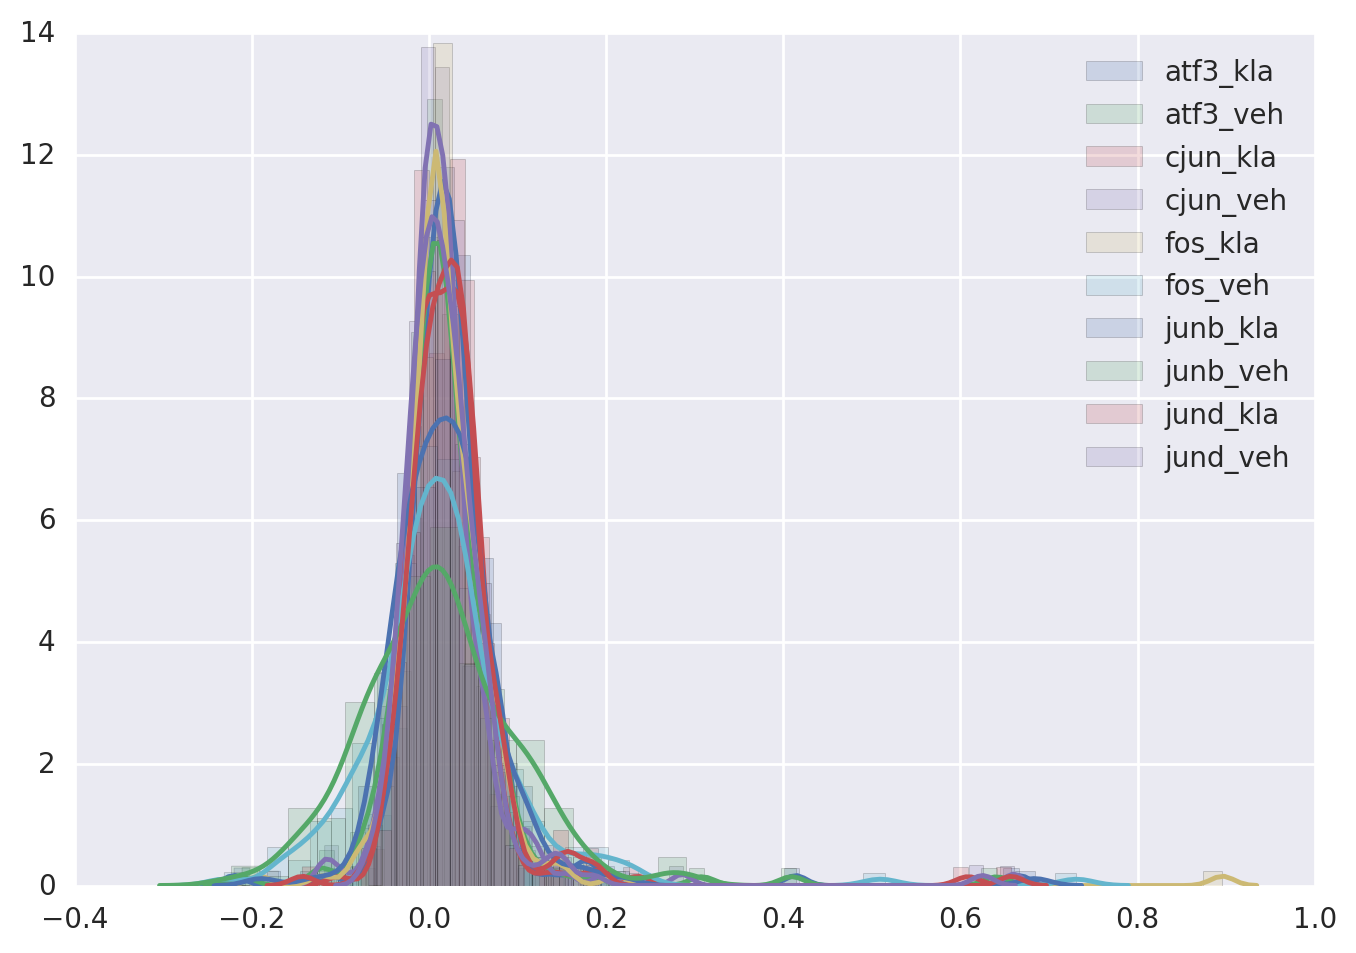

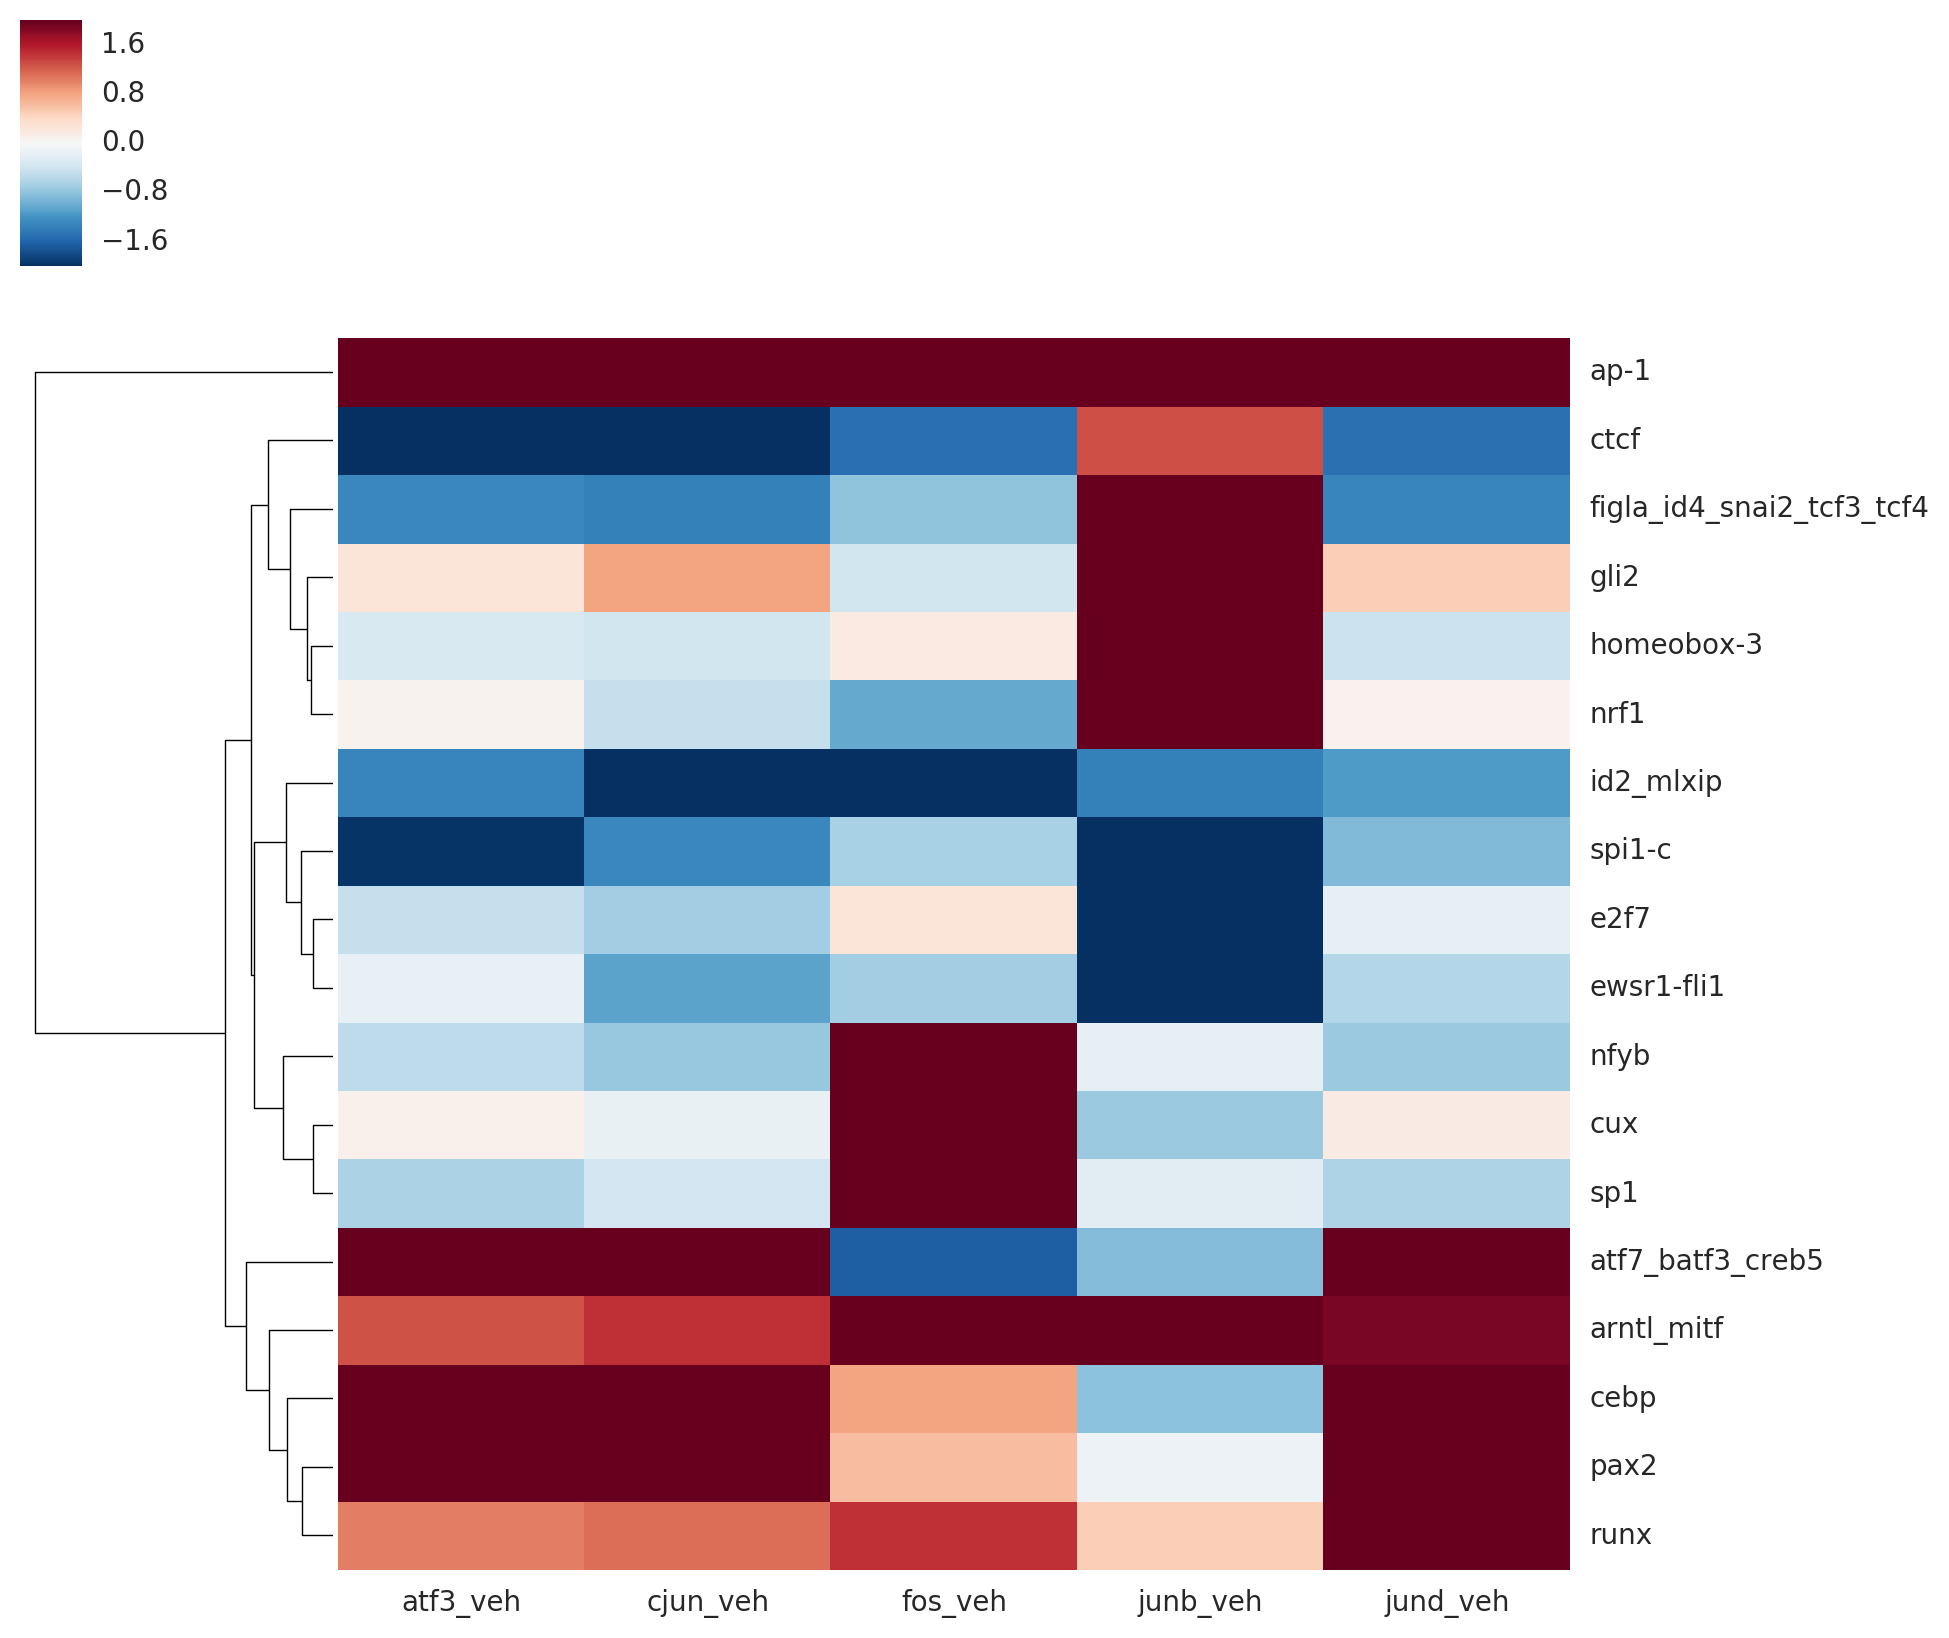

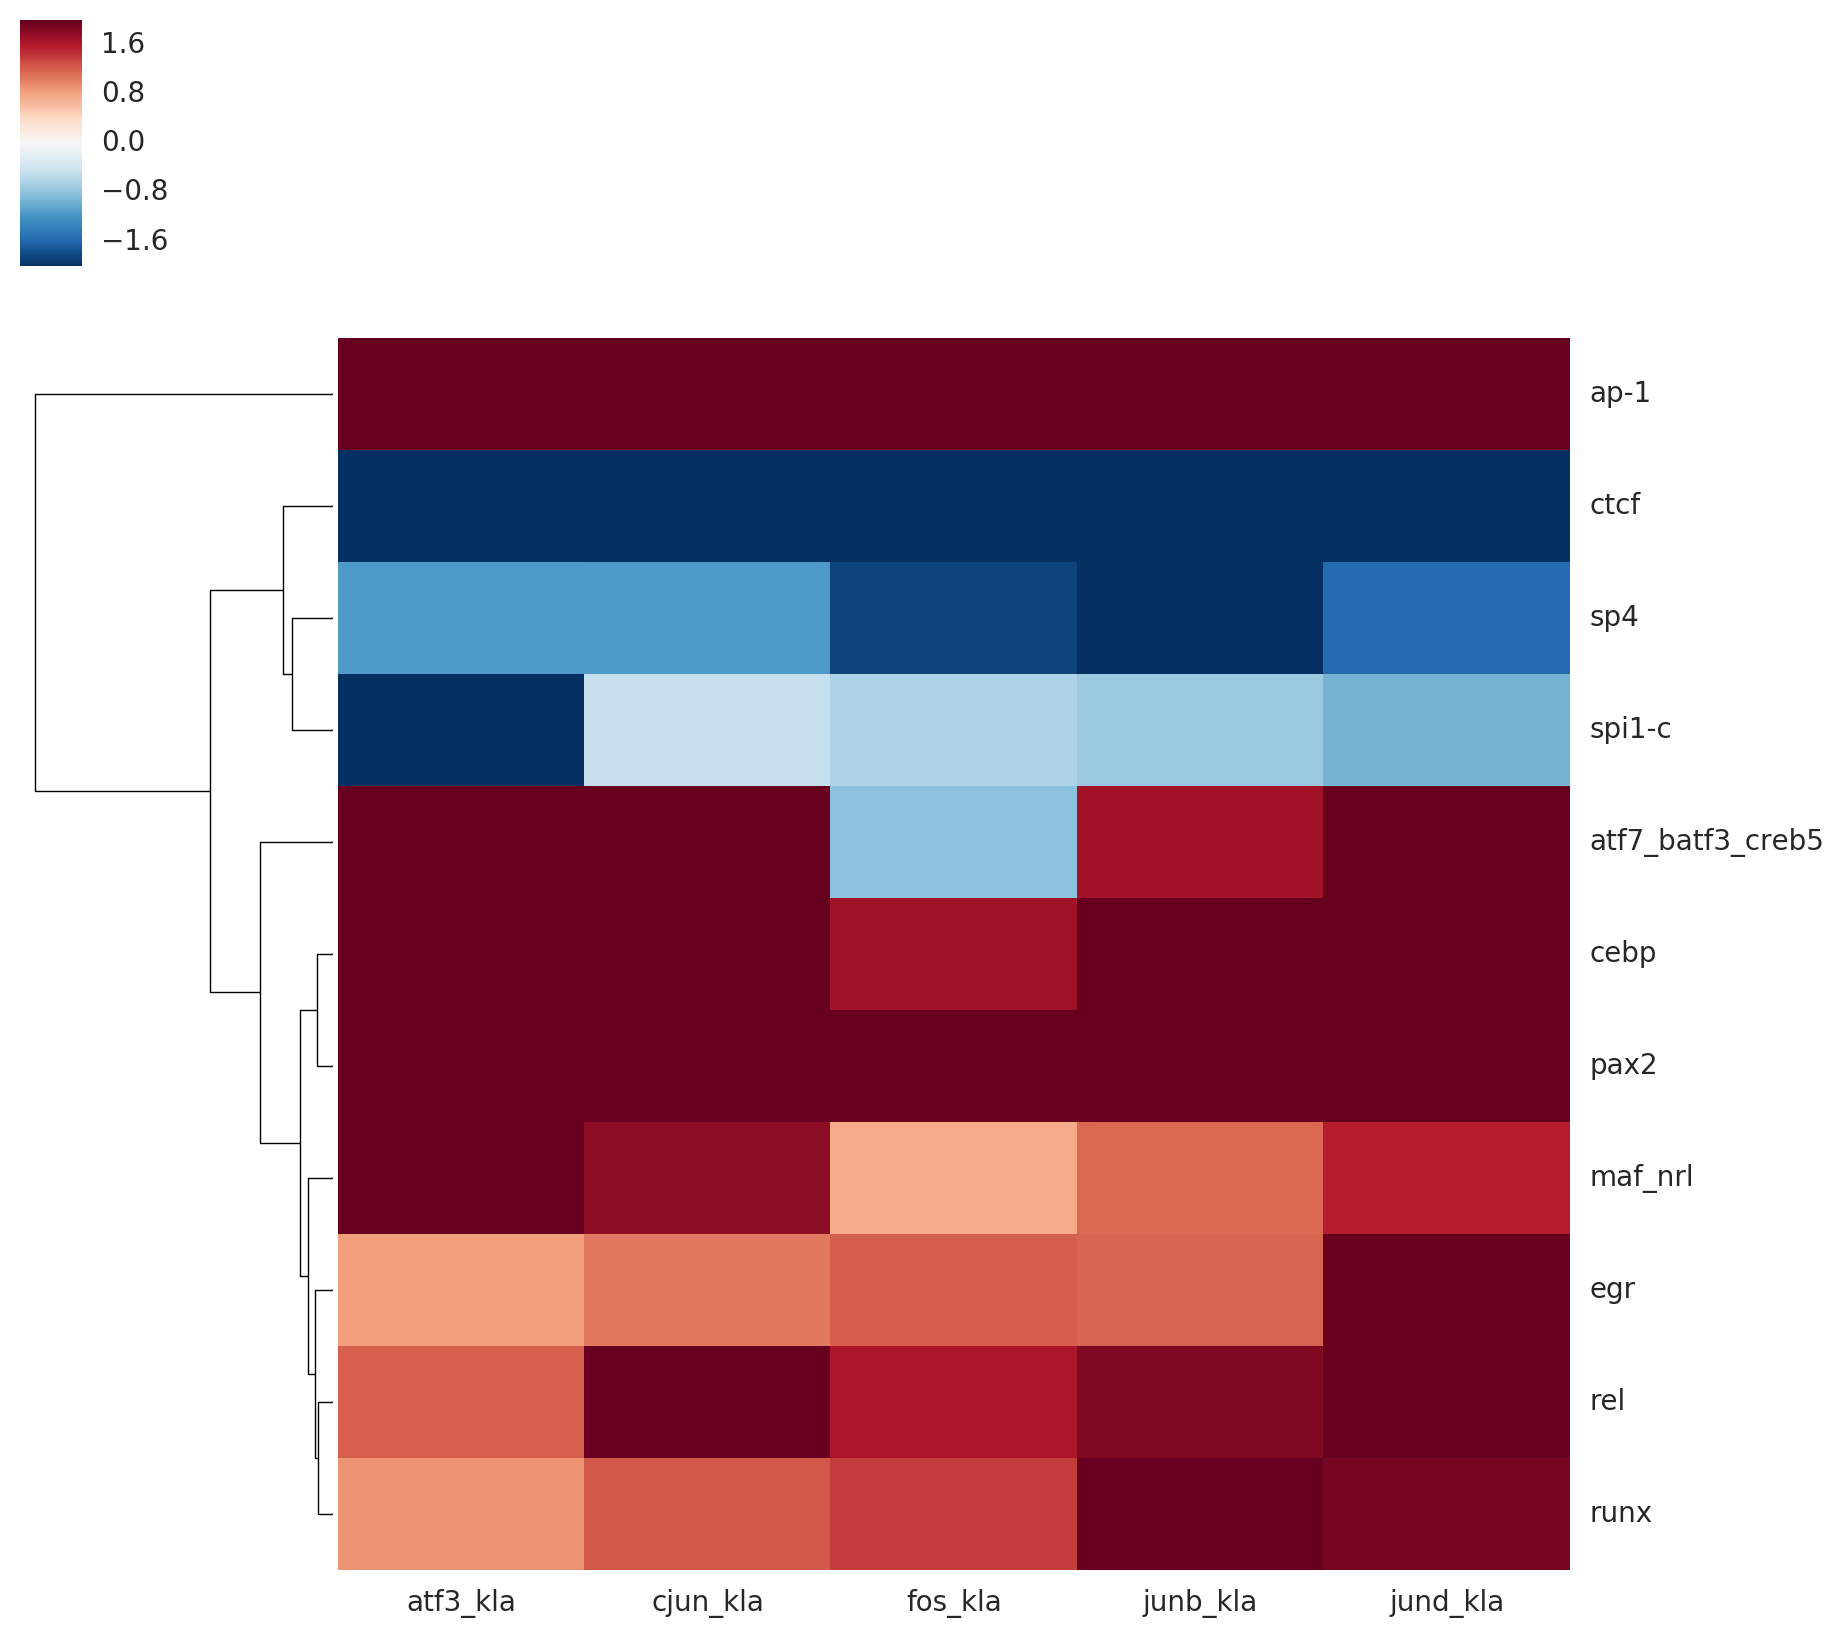

In [54]:
coefficients_frame = pd.DataFrame(factor_meanCoeff_dict)
coefficients_frame.index = standardized_motif_frame.columns.values
for col in coefficients_frame.columns.values:
    sns.distplot(coefficients_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_frame = coefficients_frame[[]]
for col in coefficients_frame:
    coefficients_zscore_frame[col] = scipy.stats.mstats.zscore(coefficients_frame[col].values)

coefficients_zscore_frame.index = coefficients_frame.index.values
coefficients_zscore_frame.columns = coefficients_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 2.0

for treatment in ['veh', 'kla']:
    data = coefficients_zscore_frame
    data = data[[x for x in coefficients_zscore_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );





## Run Logistic Regression using Random Genomic Background

In [876]:
strain = 'C57BL6J'
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_'+  strain + '.pickle')
motif_sequence_background_frame=pd.read_pickle('motif_sequence_background_frame_'+  strain + '.pickle')
motif_strand_background_frame=pd.read_pickle('motif_strand_background_frame_'+  strain + '.pickle')
motif_start_background_frame=pd.read_pickle('motif_start_background_frame_'+  strain + '.pickle')
motif_end_background_frame=pd.read_pickle('motif_end_background_frame_'+  strain + '.pickle')
motif_count_background_frame=pd.read_pickle('motif_count_background_frame_'+  strain + '.pickle')
motif_summedScore_background_frame= pd.read_pickle('motif_summedScore_background_frame_'+  strain + '.pickle')
# make sure background frames don't have IDs that overlap with target frame
motif_score_background_frame = motif_score_background_frame[~motif_score_background_frame.index.isin(motif_score_frame.index.values)]
motif_sequence_background_frame = motif_sequence_background_frame[~motif_sequence_background_frame.index.isin(motif_score_frame.index.values)]
motif_strand_background_frame = motif_strand_background_frame[~motif_strand_background_frame.index.isin(motif_score_frame.index.values)]
motif_start_background_frame = motif_start_background_frame[~motif_start_background_frame.index.isin(motif_score_frame.index.values)]
motif_end_background_frame = motif_end_background_frame[~motif_end_background_frame.index.isin(motif_score_frame.index.values)]
motif_count_background_frame = motif_count_background_frame[~motif_count_background_frame.index.isin(motif_score_frame.index.values)]
motif_summedScore_background_frame= motif_summedScore_background_frame[~motif_summedScore_background_frame.index.isin(motif_score_frame.index.values)]

scaler = preprocessing.StandardScaler()
standardized_motif_background_frame = pd.DataFrame(scaler.fit_transform(motif_score_background_frame.ix[:,3:]))
standardized_motif_background_frame.columns = motif_score_background_frame.columns.values[3:]
standardized_motif_background_frame.index = motif_score_background_frame.index.values

In [877]:
scaler = preprocessing.StandardScaler()
standardized_summedScore_background_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_background_frame.ix[:,3:]))
standardized_summedScore_background_frame.columns = motif_summedScore_background_frame.columns.values[3:]
standardized_summedScore_background_frame.index = motif_summedScore_background_frame.index.values

In [878]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  



### Logistic Regression Using Best Motif Scores

In [881]:
# for monomers using all motifs
strain = 'c57bl6'
factor_auc_background_dict = {}
factor_precision_background_dict = {}
factor_coeff_background_dict = {}
factor_prob_background_dict = {}
factor_meanCoeff_background_dict = {}
factor_intercept_background_dict = {}
factor_meanIntercept_background_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
#         background_indices = motif_score_background_frame.index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]

        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_split(
                    features, labels, test_size = test_size)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                probs = lr_classifier.predict_proba(features)[:, 1]

                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])
                
                if all_probs == None:
                    all_probs = probs
                else:
                    all_probs = all_probs + probs
            mean_coefficients = np.mean(all_coefficients, axis=0)
            
            factor_auc_background_dict[monomer + '_' + treatment]= all_aucs
            factor_precision_background_dict[monomer + '_' + treatment] = all_precisions
            factor_coeff_background_dict[monomer + '_' + treatment] = all_coefficients
            factor_prob_background_dict[monomer + '_' + treatment] = all_probs
            factor_meanCoeff_background_dict[monomer + '_' + treatment] = mean_coefficients
            factor_intercept_background_dict[monomer + '_' + treatment] = all_intercepts
            factor_meanIntercept_background_dict[monomer + '_' + treatment] = np.mean(all_intercepts)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:58: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.921888344811 1.4085737918e-07 precision: 0.918026009904 8.46904780214e-07 numTestPositives: 15061
cjun_veh roc: 0.915993846435 9.41775974939e-07 precision: 0.919613755407 5.36369896634e-07 numTestPositives: 15061
fos_veh roc: 0.955245770038 1.2473672911e-06 precision: 0.98565272845 2.40412255574e-07 numTestPositives: 15061
junb_veh roc: 0.902177203768 6.33962916737e-06 precision: 0.993536463323 4.42993522647e-08 numTestPositives: 15061
jund_veh roc: 0.915839249491 1.53198958957e-06 precision: 0.915271112111 3.53631787294e-06 numTestPositives: 15061
atf3_kla roc: 0.924629893983 4.03892525146e-07 precision: 0.915859103173 1.03790534133e-06 numTestPositives: 15061
cjun_kla roc: 0.908617639791 8.04578726092e-07 precision: 0.909242129987 1.13592729757e-06 numTestPositives: 15061
fos_kla roc: 0.927743945972 4.20812437277e-07 precision: 0.925032466754 9.13622484846e-07 numTestPositives: 15061
junb_kla roc: 0.914450081697 2.61854495523e-07 precision: 0.916953818023 6.8511791262

### Logistic Regression Using Summed Motif Scores

In [885]:
# for monomers using all motifs
strain = 'c57bl6'

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_summedScore_frame[standardized_summedScore_frame.index.isin(target_indices)]
        background_indices = motif_summedScore_background_frame.index.values
#         background_indices = motif_score_background_frame[
#             motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_summedScore_background_frame[standardized_summedScore_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)
        all_aucs = []
        all_coefficients = []
        all_probs = None
        all_precisions = []
        all_intercepts = []
        for i in range(numIterations):  

            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_split(
                features, labels, test_size = test_size)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)
            all_intercepts.append(lr_classifier.intercept_[0])

            if all_probs == None:
                all_probs = probs
            else:
                all_probs = all_probs + probs
        mean_coefficients = np.mean(all_coefficients, axis=0)

        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.937072871953 2.26233708402e-06 precision: 0.90280486873 1.24218576424e-05 numTestPositives: 11073
cjun_veh roc: 0.947474253274 3.37268016788e-06 precision: 0.917236557259 2.09149664052e-05 numTestPositives: 6363
fos_veh roc: 0.971213255297 4.00695876935e-06 precision: 0.972207059124 2.90800712525e-06 numTestPositives: 999
junb_veh roc: 0.847515608741 0.000338740161127 precision: 0.855603618649 0.000248088274039 numTestPositives: 248
jund_veh roc: 0.94481192303 2.69601352813e-07 precision: 0.911860644596 2.79979194131e-06 numTestPositives: 9071
pu1_veh roc: 0.896667595011 5.8389685659e-07 precision: 0.840539277915 1.90673775783e-06 numTestPositives: 20067
atf3_kla roc: 0.938876454958 1.65834897439e-07 precision: 0.90409554473 3.42780848212e-06 numTestPositives: 17428
cjun_kla roc: 0.955740292497 8.8520476448e-07 precision: 0.931316908873 7.68168050945e-06 numTestPositives: 8108
fos_kla roc: 0.953566432183 3.00432377127e-07 precision: 0.931073113567 5.53861902218e-06 numT

### Logistic Regression using Counts and Top Motif Score

In [128]:
# for monomers using motif counts and best motif score
strain = 'c57bl6'
factor_coeff_dict_affinityCount = {}
factor_auc_dict_affinityCount = {}
factor_precision_dict_affinityCount = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        background_affinity_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                    affinity_features, labels, test_size = test_size)
                
                training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)].ix[:,3:],
                                                     motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)].ix[:,3:]])
                test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)].ix[:,3:],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)].ix[:,3:]])
                #  Train affinity classifier
                affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                affinity_classifier.fit(training_affinity_features, training_labels)
                
                # Train count classifier
                count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                count_classifier.fit(training_count_features, training_labels)
                
                # train combined classifier
                training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
                training_count_scores = count_classifier.decision_function(training_count_features)
                training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                                 'Count':training_count_scores})
                combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                combined_classifier.fit(training_combined_features, training_labels)

                # retrieve test probabilities
                test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
                test_count_scores = count_classifier.decision_function(test_count_features)
                test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                           'Count':test_count_scores})
                probas = combined_classifier.predict_proba(test_combined_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])

            factor_auc_dict_affinityCount[monomer + '_' + treatment] = all_aucs
            factor_precision_dict_affinityCount[monomer + '_' + treatment] = all_precisions
            factor_coeff_dict_affinityCount[monomer + '_' + treatment] = np.mean(all_coefficients, axis=0)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.949691064115 4.67072946517e-07 precision: 0.947381396559 8.50871343478e-07 numTestPositives: 11013
cjun_veh roc: 0.958410441983 2.90365511424e-06 precision: 0.95911847189 3.29760630723e-06 numTestPositives: 6335
fos_veh roc: 0.951479703169 1.61710600429e-06 precision: 0.952769448177 6.73539916143e-07 numTestPositives: 994
junb_veh roc: 0.807584126932 0.000242839070957 precision: 0.820909566532 0.000233732343506 numTestPositives: 247
jund_veh roc: 0.947984466663 4.51207406284e-06 precision: 0.945506966102 5.19441810948e-06 numTestPositives: 9025
atf3_kla roc: 0.948146567802 2.54075627241e-07 precision: 0.944388414901 3.17294324296e-07 numTestPositives: 17327
cjun_kla roc: 0.958668129587 1.30564674138e-06 precision: 0.956760498272 1.60916610343e-06 numTestPositives: 8068
fos_kla roc: 0.961366576951 2.1728172677e-07 precision: 0.959425487037 3.71576422737e-07 numTestPositives: 10733
junb_kla roc: 0.963879624548 1.09959495215e-06 precision: 0.962122193352 1.40044084458e-06 

### Logistic Regression on Random Background for Top Motifs

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


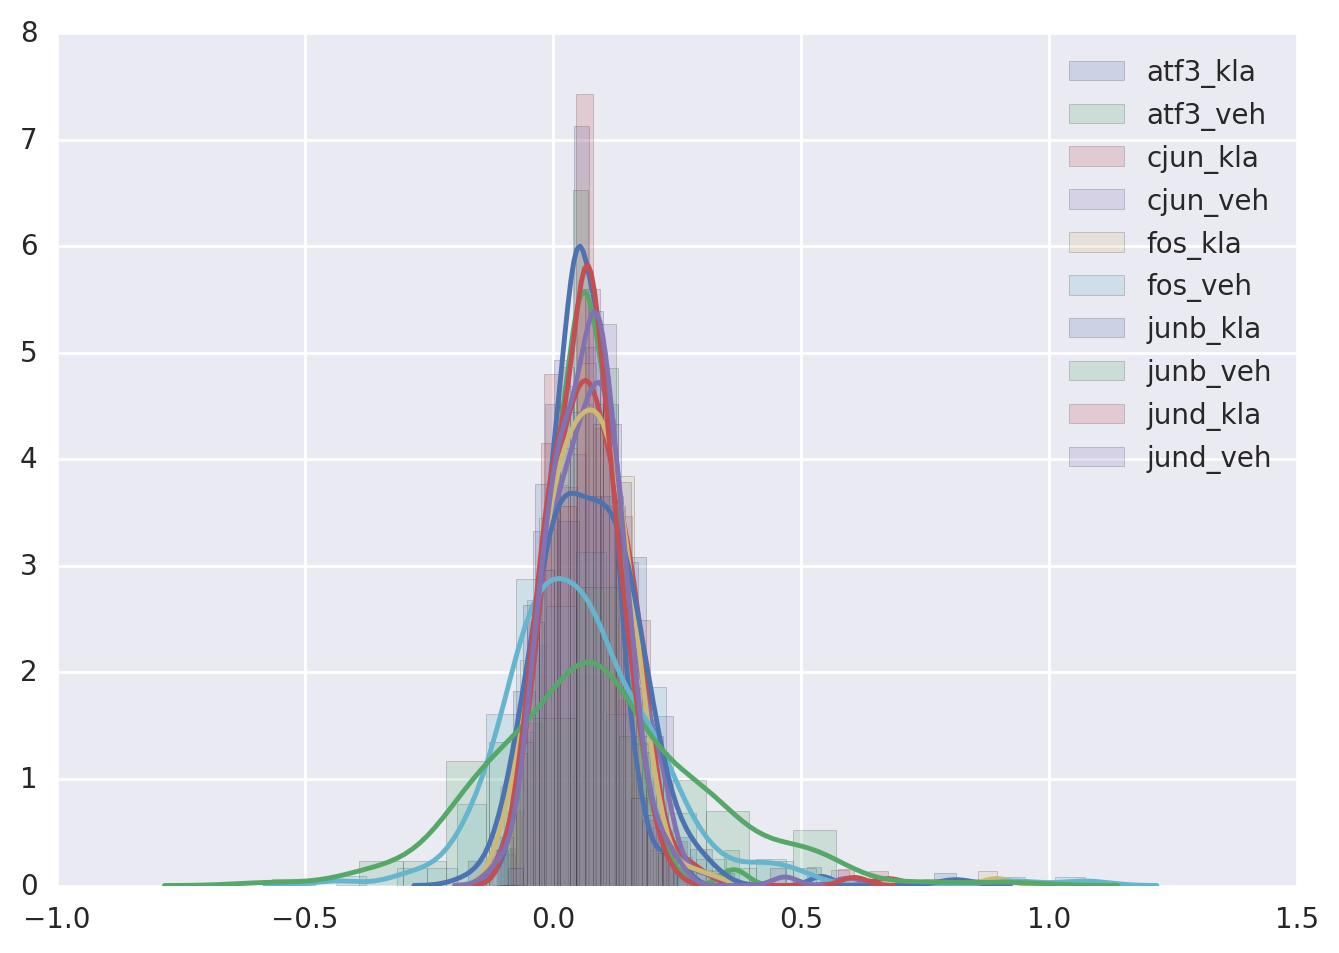

In [159]:
top_motifs_dict = {}
weight_threshold = 1.5
coefficients_background_frame = pd.DataFrame(factor_meanCoeff_background_dict)
coefficients_background_frame.index = standardized_motif_background_frame.columns.values
for col in coefficients_background_frame.columns.values:
    sns.distplot(coefficients_background_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_background_frame = coefficients_background_frame[[]]
for col in coefficients_background_frame:
    coefficients_zscore_background_frame[col] = scipy.stats.mstats.zscore(coefficients_background_frame[col].values)

coefficients_zscore_background_frame.index = coefficients_background_frame.index.values
coefficients_zscore_background_frame.columns = coefficients_background_frame.columns.values

for monomer in ap1_members:
    for treatment in ['veh', 'kla']:

        data = coefficients_zscore_background_frame
        data = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ]
        top_motifs_dict[monomer + '_' + treatment] = data.index.values



In [337]:
# for monomers using motif counts and best motif score
strain = 'c57bl6'
# factor_coeff_dict_affinityCount = {}
# factor_auc_dict_affinityCount = {}
# factor_precision_dict_affinityCount = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        top_motifs = top_motifs_dict[monomer + '_' + treatment]
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        background_affinity_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        affinity_features = affinity_features[top_motifs]
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                    affinity_features, labels, test_size = test_size)
                
                training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                     motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
                test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])
                #  Train affinity classifier
                affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                affinity_classifier.fit(training_affinity_features, training_labels)
                
                # Train count classifier
                count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                count_classifier.fit(training_count_features, training_labels)
                
                # train combined classifier
                training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
                training_count_scores = count_classifier.decision_function(training_count_features)
                training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                                 'Count':training_count_scores})
                combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                combined_classifier.fit(training_combined_features, training_labels)

                # retrieve test probabilities
                test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
                test_count_scores = count_classifier.decision_function(test_count_features)
                test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                           'Count':test_count_scores})
                probas = combined_classifier.predict_proba(test_combined_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])

#             factor_auc_dict_affinityCount[monomer + '_' + treatment] = all_aucs
#             factor_precision_dict_affinityCount[monomer + '_' + treatment] = all_precisions
#             factor_coeff_dict_affinityCount[monomer + '_' + treatment] = np.mean(all_coefficients, axis=0)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.850652266047 5.72083316907e-06 precision: 0.841996366589 1.0140997708e-05 numTestPositives: 11013
cjun_veh roc: 0.868740165789 3.85340125179e-06 precision: 0.861053428911 2.31421170754e-06 numTestPositives: 6335
fos_veh roc: 0.919928221239 1.53972797857e-06 precision: 0.908829813789 4.43296583033e-06 numTestPositives: 994
junb_veh roc: 0.817754757495 0.000655478116618 precision: 0.818111484942 0.000573294801176 numTestPositives: 247
jund_veh roc: 0.823499089172 9.00948110298e-06 precision: 0.819636759975 9.06010788514e-06 numTestPositives: 9025
atf3_kla roc: 0.848808539147 9.79358976544e-07 precision: 0.835687242832 1.34926264062e-06 numTestPositives: 17327
cjun_kla roc: 0.845254281038 6.77774083996e-06 precision: 0.830893110403 1.16986563648e-05 numTestPositives: 8068
fos_kla roc: 0.838558659137 1.23479427553e-06 precision: 0.816835375476 3.97081101887e-06 numTestPositives: 10733
junb_kla roc: 0.875519642223 5.95528603405e-06 precision: 0.864310730249 9.35079700035e-06

## Test Different Thresholds

In [ ]:
numIterations = 5
factor_auc_dict = {}
factor_precision_dict = {}
factor_numMotifs_dict = {}
for monomer in ap1_members:
    for treatment in ['veh', 'kla']:
        for weight_threshold in np.arange(0,2.1,0.1):
            data = coefficients_zscore_background_frame
            data = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                        (data[monomer + '_' + treatment] < -1 * weight_threshold)
                        ]
            top_motifs = data.index.values
            target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
            background_indices = motif_score_background_frame[
                motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
            # select subset of background indices to use
            shuffle(background_indices)
            background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]

            target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
            background_affinity_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]

            # merge target and background features together 
            affinity_features = pd.concat([target_affinity_features, background_affinity_features])
            affinity_features = affinity_features[top_motifs]
            labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                               index = affinity_features.index.values)

            if np.sum(labels) >= 100:
                all_aucs = []
                all_coefficients = []
                all_precisions = []
                all_intercepts = []
                for i in range(numIterations):  

                    # split data into training and test sets
                    training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                        affinity_features, labels, test_size = test_size)

                    training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                         motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
                    test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                                     motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])
                    #  Train affinity classifier
                    affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                    affinity_classifier.fit(training_affinity_features, training_labels)

                    # Train count classifier
                    count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                    count_classifier.fit(training_count_features, training_labels)

                    # train combined classifier
                    training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
                    training_count_scores = count_classifier.decision_function(training_count_features)
                    training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                                     'Count':training_count_scores})
                    combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                    combined_classifier.fit(training_combined_features, training_labels)

                    # retrieve test probabilities
                    test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
                    test_count_scores = count_classifier.decision_function(test_count_features)
                    test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                               'Count':test_count_scores})
                    probas = combined_classifier.predict_proba(test_combined_features)

                    # score predictions
                    current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
                    current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

                    all_aucs.append(current_roc_auc)
                    all_precisions.append(current_precision)

                    # score all sequences
                    current_coefficients = lr_classifier.coef_.flatten()
                    all_coefficients.append(current_coefficients)
                    all_intercepts.append(lr_classifier.intercept_[0])
                if not monomer + '_' + treatment in factor_auc_dict:
                    factor_auc_dict[monomer+ '_' + treatment] = []
                    factor_precision_dict[monomer+ '_' + treatment] = []
                    factor_numMotifs_dict[monomer+ '_' + treatment] = []
                factor_auc_dict[monomer + '_' + treatment].append(np.mean(all_aucs))
                factor_precision_dict[monomer + '_' + treatment].append(np.mean(all_precisions))
                factor_numMotifs_dict[monomer + '_' + treatment].append(len(top_motifs))
                print(monomer + '_' + treatment,
                      'roc:', np.mean(all_aucs), 
                      'precision:', np.mean(all_precisions),  
                      'numMotifs:', len(top_motifs),
                      'threshold:', weight_threshold
                      
                     )

In [203]:
threshold_numMotifs_frame = pd.DataFrame(factor_numMotifs_dict, index = np.arange(0,2.1,0.1))
auc_frame = pd.DataFrame(factor_auc_dict, index = np.arange(0,2.1,0.1))
precision_frame = pd.DataFrame(factor_precision_dict, index = np.arange(0,2.1,0.1))




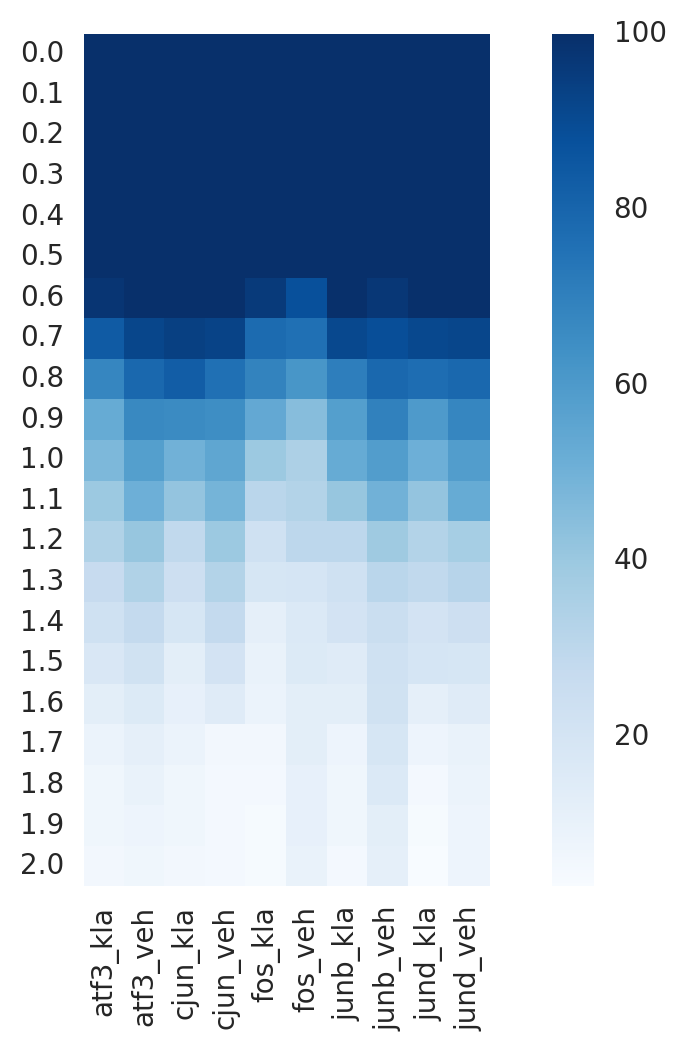

In [209]:
cg = sns.heatmap(threshold_numMotifs_frame, 
                 square=True, 
                 cmap='Blues',
                 vmax=100,
                 vmin=3
                )
plt.setp(cg.xaxis.get_majorticklabels(), fontsize=10, rotation=90);

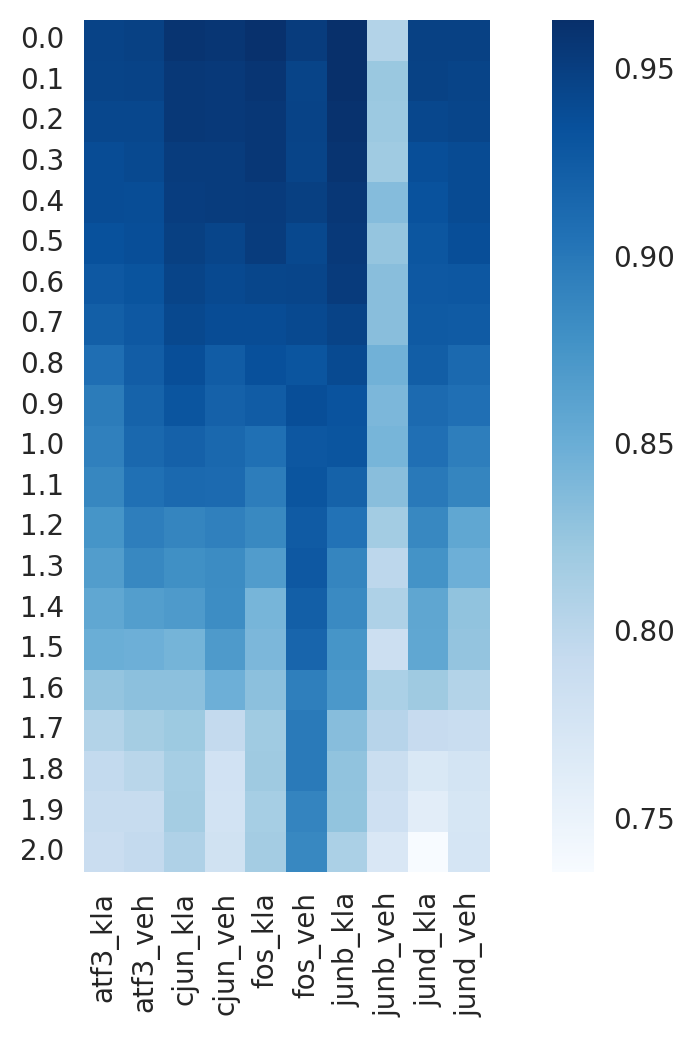

In [204]:
cg = sns.heatmap(auc_frame, 
                 square=True, 
                 cmap='Blues',
                )
plt.setp(cg.xaxis.get_majorticklabels(), fontsize=10, rotation=90);

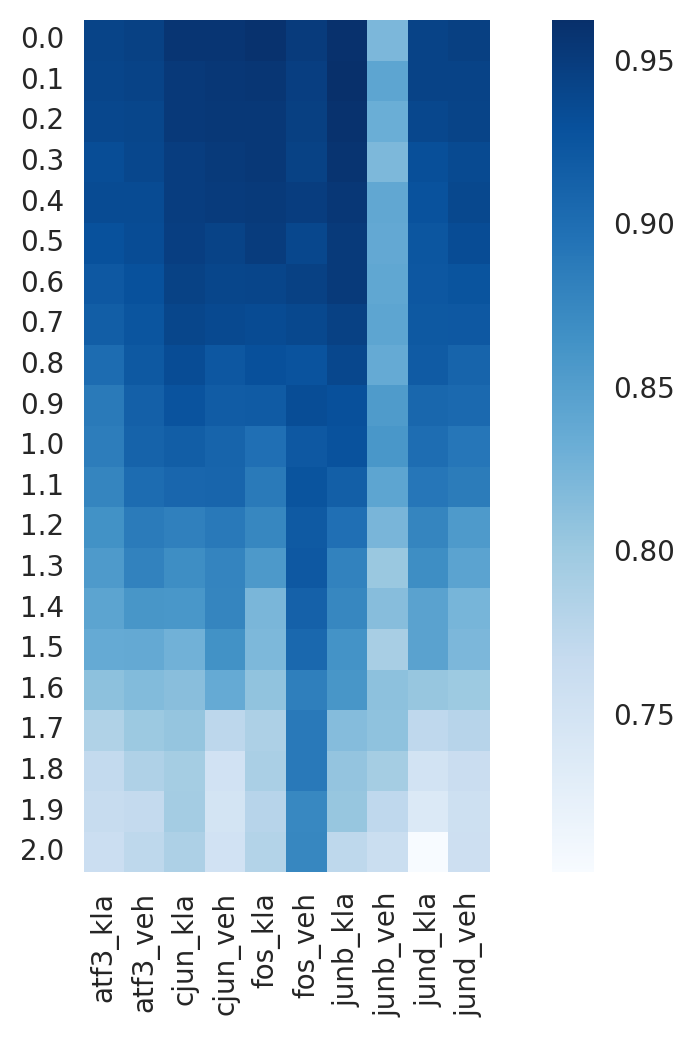

In [205]:
cg = sns.heatmap(precision_frame, 
                 square=True, 
                 cmap='Blues',
                )
plt.setp(cg.xaxis.get_majorticklabels(), fontsize=10, rotation=90);

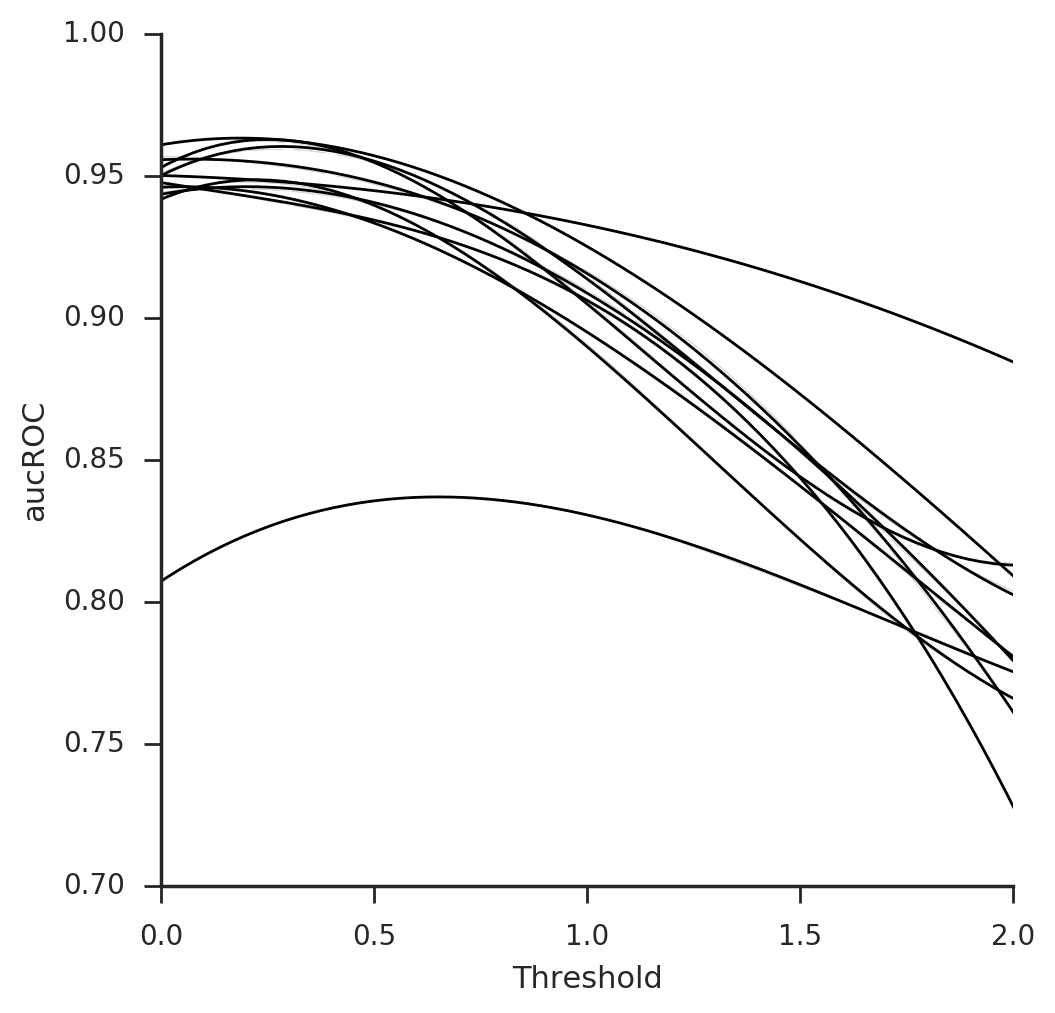

In [331]:
with sns.axes_style('ticks'):
    for key in sorted(factor_numMotifs_dict):
        performance = factor_auc_dict[key]
        sns.regplot(x=np.arange(0,2.1,0.1), 
                    y=np.array(performance),
                    order =3,
                    label=key,
                    ci=0,
                    color='black',
                    scatter_kws={'edgecolor':'None',
                                 'c':'white'},
                    line_kws = {'linewidth':1}
                   )
    sns.despine()    
    plt.xlim(0,2)
    plt.ylim(0.7,1)
    
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))


    plt.xlabel('Threshold')
    plt.ylabel('aucROC')

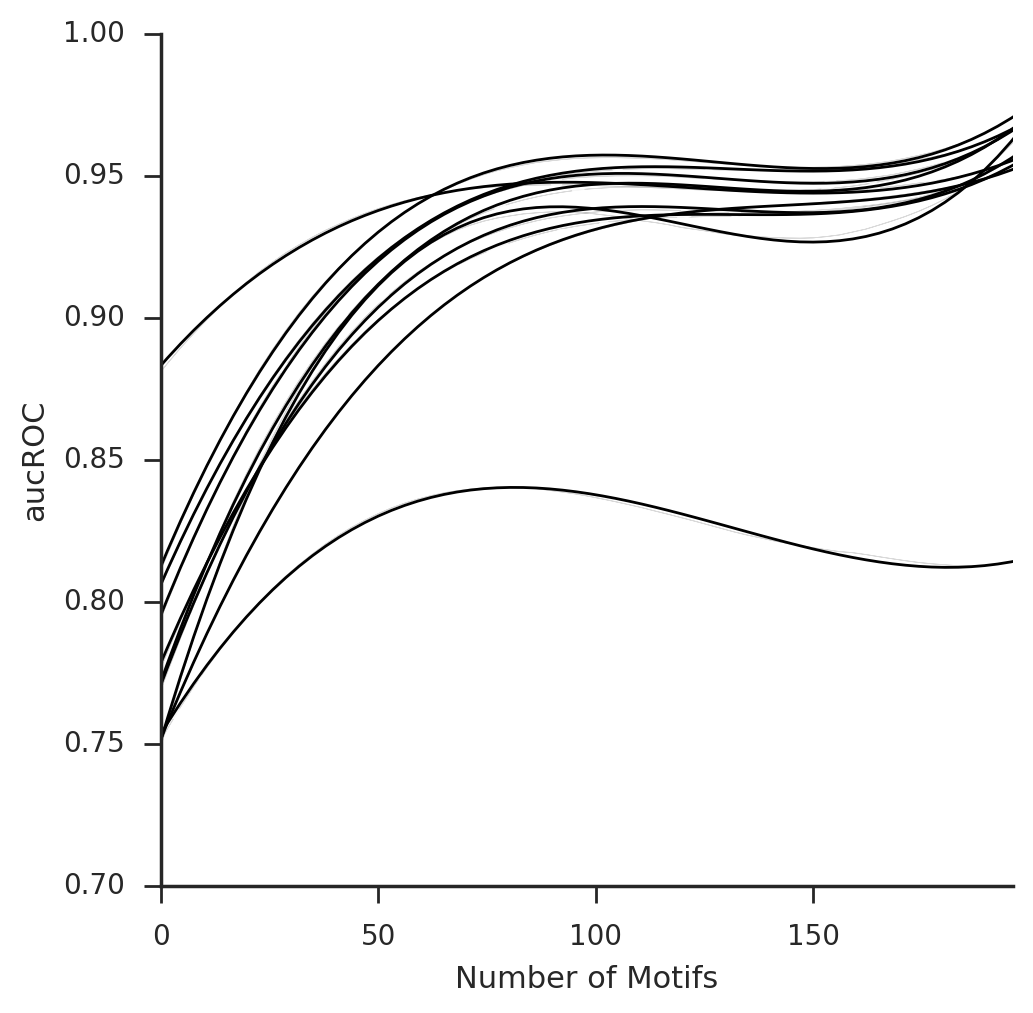

In [305]:
with sns.axes_style('ticks'):
    for key in sorted(factor_numMotifs_dict):
        numMotifs = factor_numMotifs_dict[key]
        performance = factor_auc_dict[key]
        sns.regplot(x=np.array(numMotifs), 
                    y=np.array(performance),
                    order = 3,
                    label=key,
                    ci=0,
                    color='black',
                    scatter_kws={'edgecolor':'None',
                                 'c':'white'},
                    line_kws = {'linewidth':1}
                   )
    sns.despine()    
    plt.xlim(0,196)
    plt.ylim(0.7,1)
    
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))


    plt.xlabel('Number of Motifs')
    plt.ylabel('aucROC')

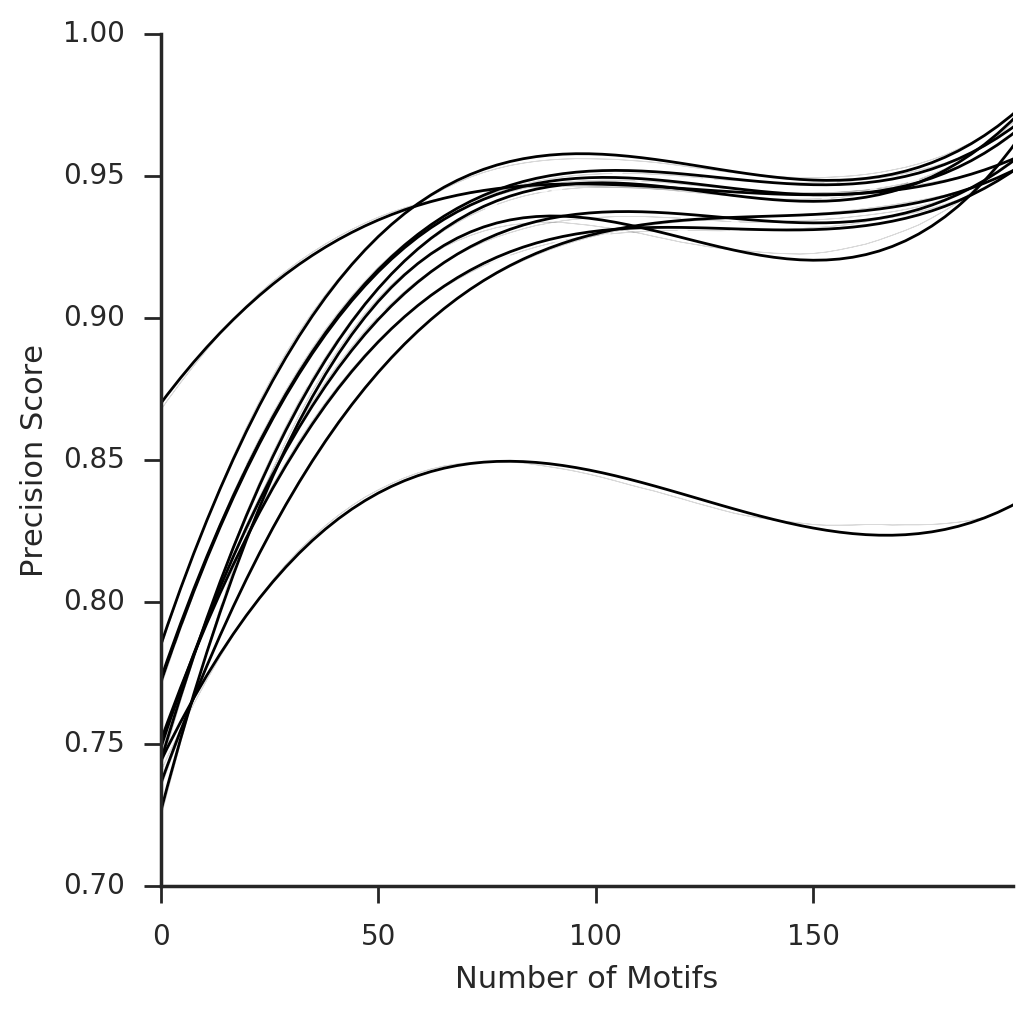

In [296]:
with sns.axes_style('ticks'):
    for key in sorted(factor_numMotifs_dict):
        numMotifs = factor_numMotifs_dict[key]
        performance = factor_precision_dict[key]
        sns.regplot(x=np.array(numMotifs), 
                    y=np.array(performance),
                    order = 3,
                    label=key,
                    ci=0,
                    color='black',
                    line_kws = {'linewidth':1},
                    scatter_kws={'edgecolor':'None',
                                 'c':'white'}
                   )
    sns.despine()    
    plt.xlim(0,196)
    plt.ylim(0.7,1)
    
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
                
    plt.xlabel('Number of Motifs')
    plt.ylabel('Precision Score')

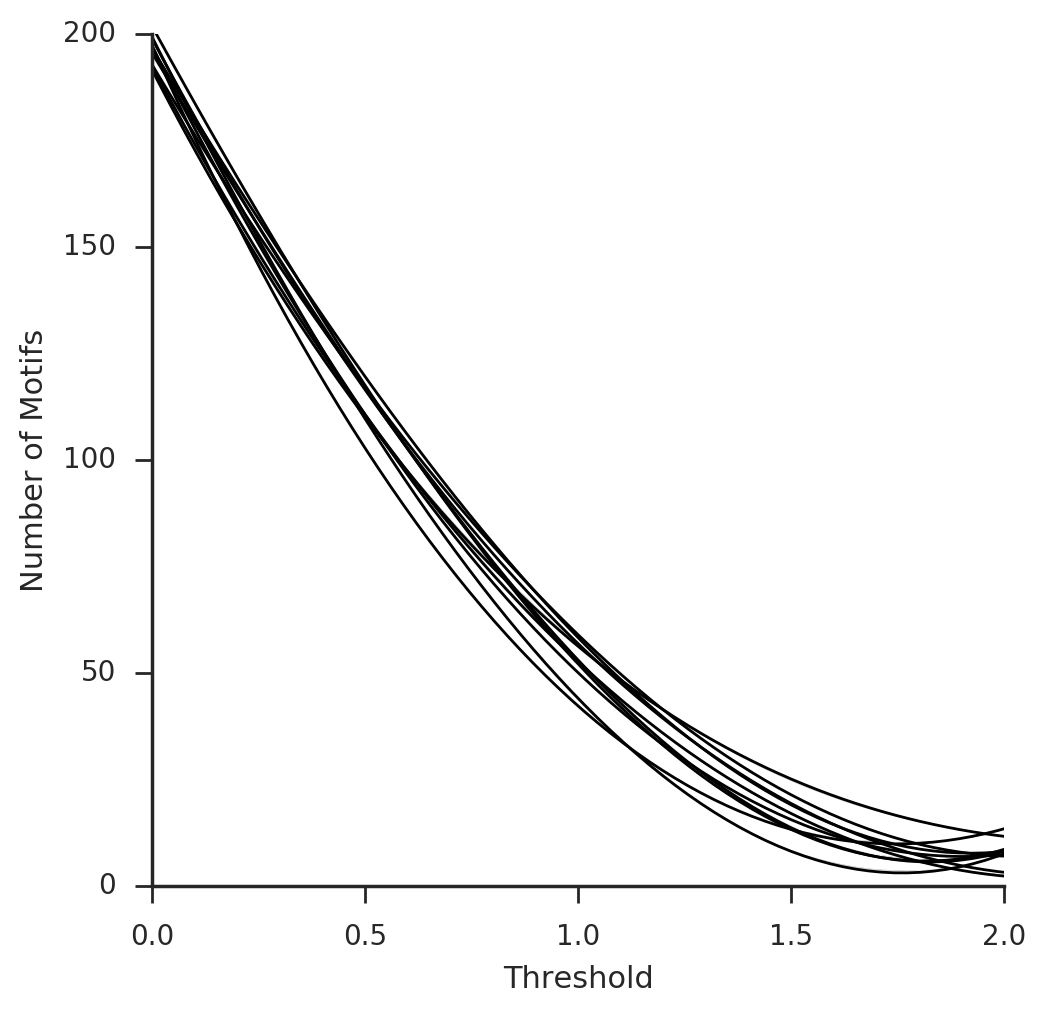

In [297]:
with sns.axes_style('ticks'):
    for key in sorted(factor_numMotifs_dict):
        numMotifs = factor_numMotifs_dict[key]
        sns.regplot(x=np.arange(0,2.1,0.1), 
                    y=np.array(numMotifs),
                    order =3,
                    label=key,
                    ci=0,
                    color='black',
                    line_kws = {'linewidth':1},
                    scatter_kws={'edgecolor':'None',
                                 'c':'white'}
                    
                   )
    plt.ylabel('Number of Motifs')
    plt.xlabel('Threshold')
    sns.despine()    
    plt.xlim(0,2)
    plt.ylim(0,200)
    
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))


    

## Comparioson of Random Background Coefficients Vs Open Chromatin background Coefficients

In [ ]:
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        chrom_weights = coefficients_zscore_frame[monomer + '_' + treatment]
        background_weights = coefficients_zscore_background_frame[monomer + '_' + treatment]

        pearson, pval = scipy.stats.pearsonr(chrom_weights, background_weights)
        with sns.axes_style('ticks'):
#             data = pd.DataFrame({'Open Chromatin': chrom_weights, 
#                  'Random Background': background_weights})
#             sns.residplot(data = data, 
#                 x = 'Open Chromatin',
#                 y= 'Random Background')
            plt.scatter(chrom_weights, background_weights, marker = '.', edgecolors='None')
            plt.xlabel('Open Chromatin Weights')
            plt.ylabel('Random Background Weights')
            plt.title(monomer + '_' + treatment + ' (' + str(pearson)[:5] + ')')
            sns.despine()
            plt.show()
        



## Correlation with Peak Scores

atf3 veh


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.560518512559 (44050, 196) 44050


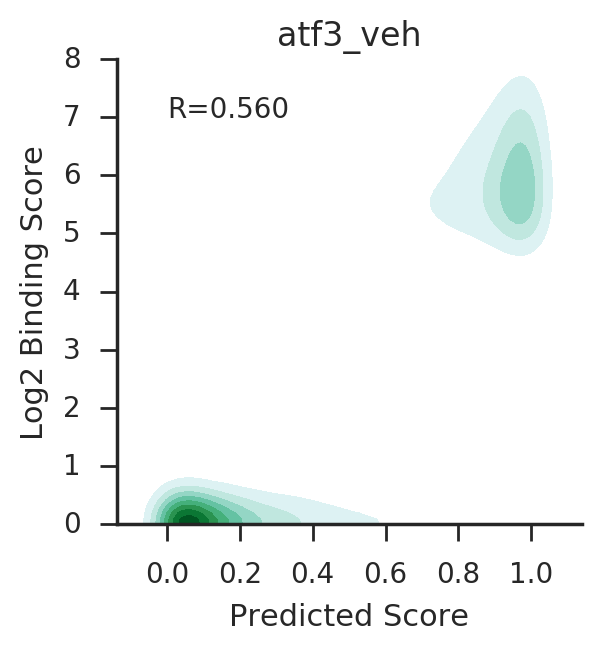

cjun veh
0.622636168497 (25340, 196) 25340


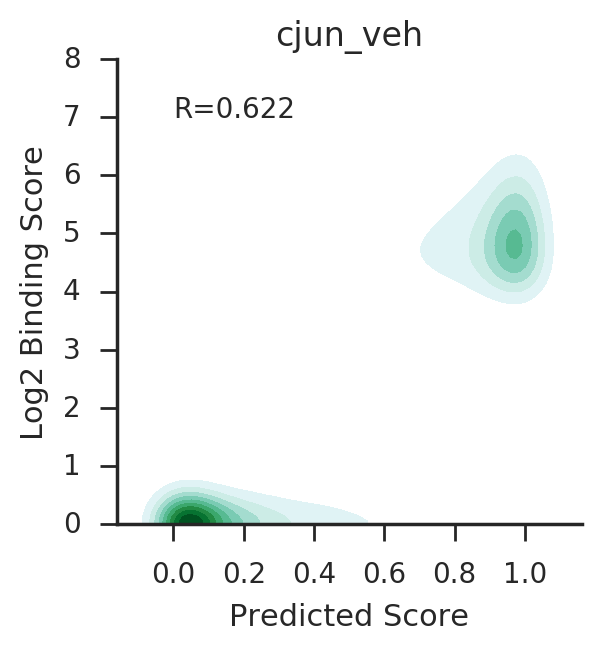

fos veh
0.648770536153 (3976, 196) 3976


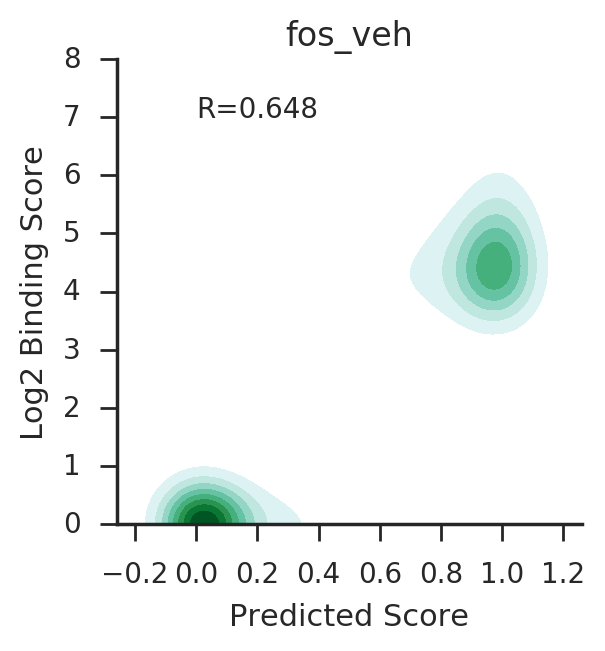

junb veh
0.623458672447 (986, 196) 986


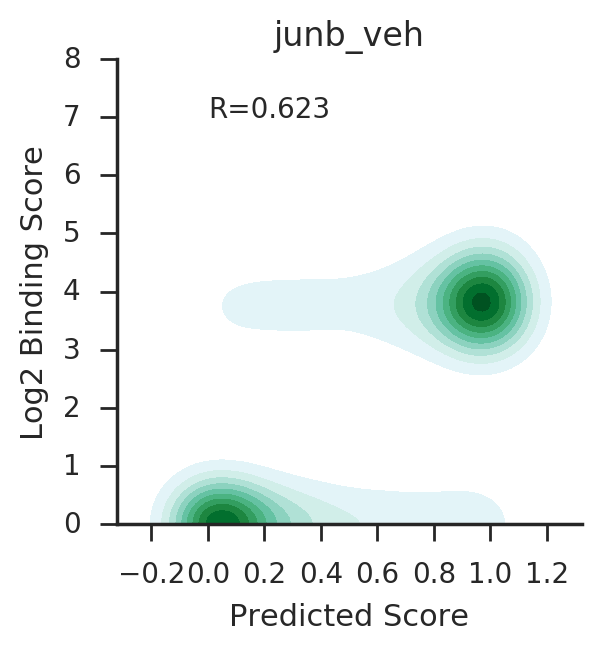

jund veh
0.592292405181 (36098, 196) 36098


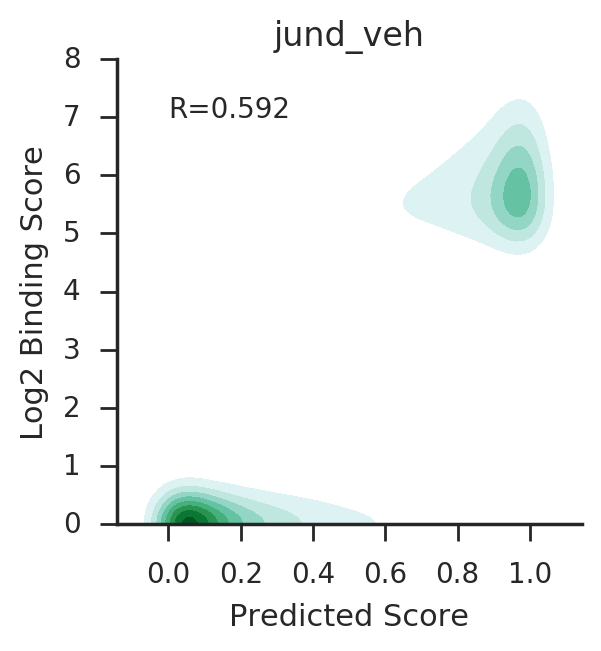

atf3 kla
0.596017313989 (69308, 196) 69308


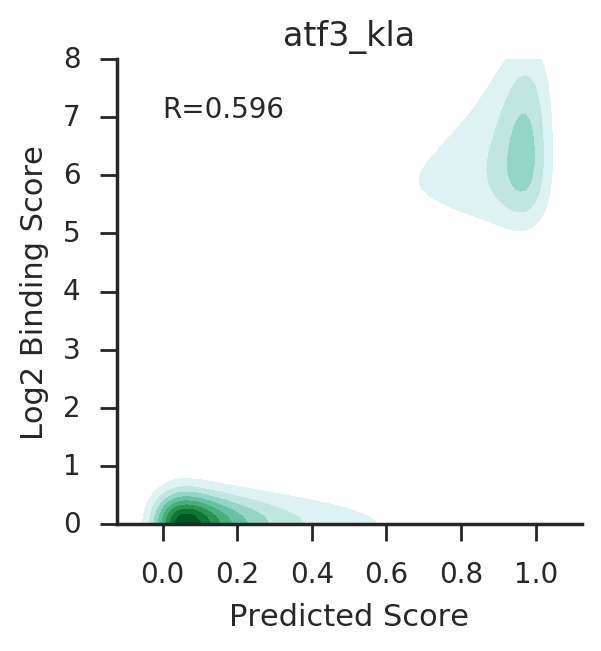

cjun kla
0.634776710829 (32270, 196) 32270


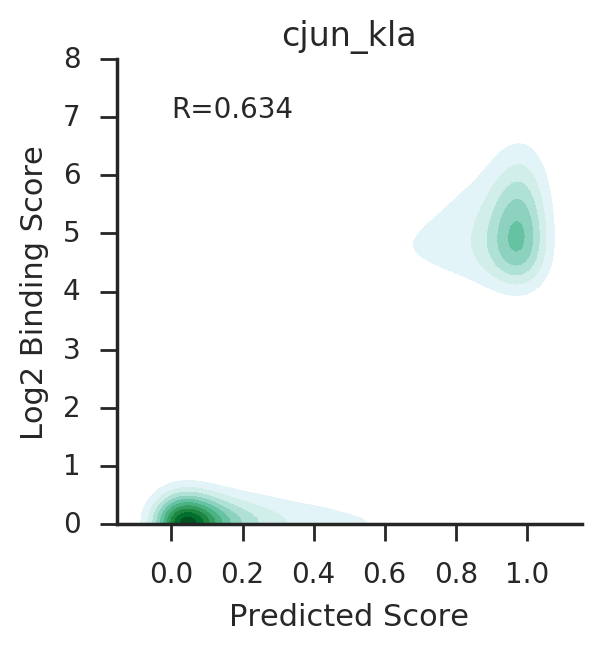

fos kla
0.629278184138 (42930, 196) 42930


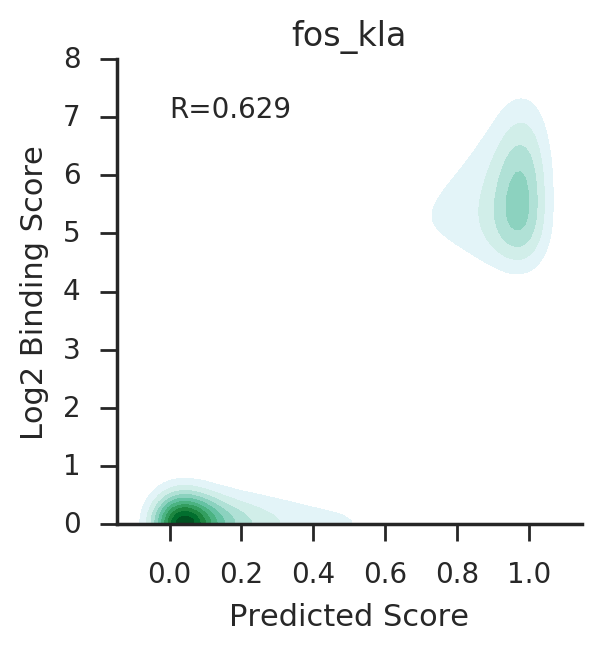

junb kla
0.622957786237 (28160, 196) 28160


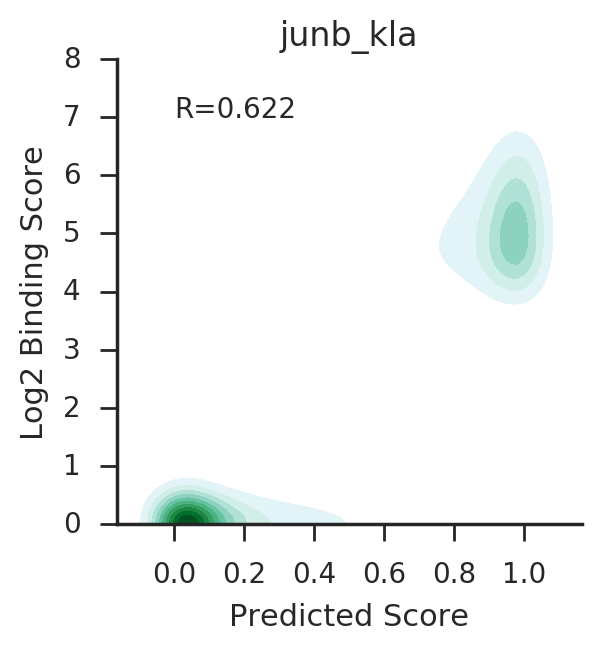

jund kla
0.62339241958 (59928, 196) 59928


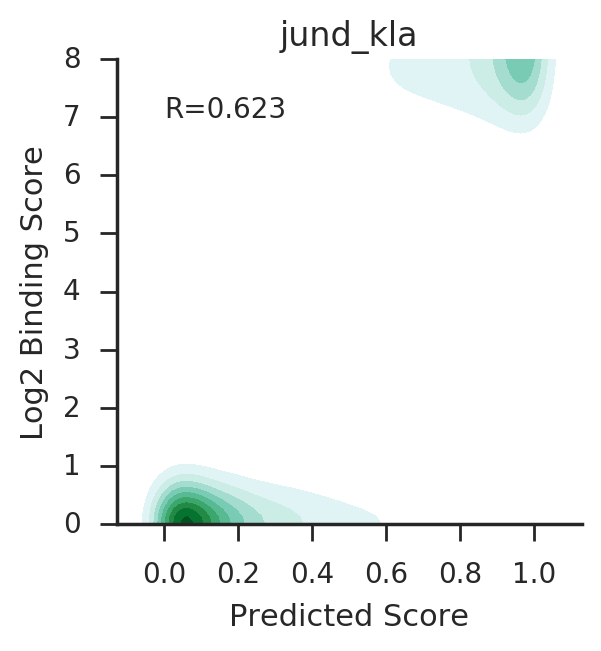

In [325]:
strain = 'c57bl6'
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        print(monomer, treatment)
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) >= 100:

            # calculate probabilities using averaged weights
            weights = factor_meanCoeff_background_dict[monomer + '_' + treatment]
            intercept = factor_meanIntercept_background_dict[monomer + '_' + treatment]
            scores = np.dot(features, weights) + intercept
            probs = np.array([signmoid(x) for x in scores])

            # get real binding scores
            binding_scores = summary_frame[summary_frame.index.isin(labels.index.values)][strain + '_' + monomer + '_' + treatment]
            binding_scores = np.concatenate([binding_scores, np.array([0.0] * len(background_indices))])
            pearson, pval = scipy.stats.pearsonr(scores, binding_scores)
            print(pearson, features.shape, len(binding_scores))
            with sns.axes_style('ticks'):
                fig = plt.figure(figsize=(3,3))
#                 plt.scatter(probs, np.log2(binding_scores + 1), 
#                             marker = '.',
#                             edgecolor='None',
#                             s=1)
                sns.kdeplot(probs, np.log2(binding_scores + 1), 
                            shade=True,
                            shade_lowest = False)
                
                plt.xlabel('Predicted Score')
                plt.ylabel('Log2 Binding Score')
                plt.annotate('R='+str(pearson)[:5], xy = (0,7), size=10)
                sns.despine()
#                 plt.xlim(-0.1,1.1)
                plt.ylim(0,8)
                plt.title(monomer + '_' + treatment)
                ax = plt.gca()
                x0,x1 = ax.get_xlim()
                y0,y1 = ax.get_ylim()
                ax.set_aspect(abs(x1-x0)/abs(y1-y0))
                plt.show()

## Run gkmSVM against Random Genomic Background

In [187]:
!if [ ! -d ./gkmsvm_files ]; then mkdir ./gkmsvm_files; fi
! rm ./gkmsvm_files/*

In [188]:
### read in target sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  
### read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()

for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

In [189]:
### for all peaks in vehicle using gapped k-mers on background data
### write script
background_ratio = 1.0
for treatment in ['veh', 'kla']:
    script_file = open('gkmsvm_' + treatment + '_background.sh', 'w')
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_split(
                    features, labels, test_size = test_size)

                # create fasta files for positive and negative sequences
                training_positive_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_positive_background_' +str(iteration) + '.fa'
                training_negative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_negative_background_' +str(iteration) + '.fa'

                training_positive_file = open(training_positive_path,'w' )
                training_negative_file = open(training_negative_path,'w' )
                test_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_test_background_' + str(iteration) + '.fa'

                test_file = open(test_path,'w')

                numPositiveSeqs = np.sum(training_labels)
                count=0
                for i in range(len(training_labels)):
                    index = training_labels.index[i]
                    label = training_labels[i]
                    seq = _id_sequence_dict[index]

                    if label == True:
                        training_positive_file.write('>' + index + '\n')
                        training_positive_file.write(seq + '\n')
                    else:
                        training_negative_file.write('>' + index + '\n')
                        training_negative_file.write(seq + '\n')
                        count+=1

                for i in range(len(test_labels)):
                    index = test_labels.index[i]
                    label = test_labels[i]
                    seq = _id_sequence_dict[index]
                    test_file.write('>' + index + '\n')
                    test_file.write(seq + '\n')

                training_positive_file.close()
                training_negative_file.close()
                test_file.close()

                #  Run classifier
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration) + '_background'
                model_path = model_prefix + '.model.txt'
                results_path = model_prefix + '_results.txt'

                script_file.write('(gkmtrain '+ training_positive_path + ' ' + training_negative_path + ' ' + model_prefix +
                          ' -T 16 -m 64000;')
                if iteration == (numIterations - 1):
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)\n')
                else:
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)&\n')
                

    script_file.close()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh
cjun_veh
fos_veh
junb_veh
jund_veh
atf3_kla
cjun_kla
fos_kla
junb_kla
jund_kla


In [ ]:
%%bash
chmod a+x ./gkmsvm_veh_background.sh 
./gkmsvm_veh_background.sh

In [ ]:
%%bash
chmod a+x ./gkmsvm_kla_background.sh 
./gkmsvm_kla_background.sh

In [195]:
### for all peaks in vehicle using gapped k-mers on background data
### read performance
factor_auc_dict_gkmSVM = {}
factor_precision_dict_gkmSVM = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices
        background_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                model_prefix = './gkmsvm_files/' + monomer  + '_' + treatment+ '_' +str(iteration) + '_background'
                results_path = model_prefix + '_results.txt'


                index_score_dict = {} #{peakID: gkmSVM score}
                with open(results_path) as f:
                    data = f.readlines()
                for line in data:
                    tokens=line.strip().split()
                    score = float(tokens[1])
                    index = tokens[0]
                    index_score_dict[index] = score
                # define true labels
                index_label_dict = dict(zip(labels.index.values, labels.values))

                sorted_indices = sorted(index_score_dict.keys())

                sorted_scores = np.array([index_score_dict[x] for x in sorted_indices])
                test_labels = np.array([index_label_dict[x] for x in sorted_indices])

                min_score = np.min(sorted_scores)
                if min_score < 0:
                    normalized_scores = sorted_scores + abs(min_score)
                normalized_scores = normalized_scores/np.max(normalized_scores)

                # score predictions          
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
                all_precisions.append(current_precision)
                all_aucs.append(current_roc_auc)

            # average scoring metrics 

            mean_roc_auc = np.mean(all_aucs) 
            mean_precision = np.mean(all_precisions)

            factor_auc_dict_gkmSVM[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_gkmSVM[monomer + '_' + treatment]= all_precisions

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )



atf3_veh
atf3_veh roc: 0.978664113795 precision: 0.977268969262 numTestPositives: 11013
cjun_veh
cjun_veh roc: 0.978179674812 precision: 0.976441174552 numTestPositives: 6335
fos_veh
fos_veh roc: 0.958472363355 precision: 0.959144752866 numTestPositives: 994
junb_veh
junb_veh roc: 0.795931747775 precision: 0.813260721544 numTestPositives: 247
jund_veh
jund_veh roc: 0.977921927548 precision: 0.976773221558 numTestPositives: 9025
atf3_kla
atf3_kla roc: 0.977683990726 precision: 0.975901057135 numTestPositives: 17327
cjun_kla
cjun_kla roc: 0.979348889054 precision: 0.97785240498 numTestPositives: 8068
fos_kla
fos_kla roc: 0.979674771687 precision: 0.977784267093 numTestPositives: 10733
junb_kla
junb_kla roc: 0.975658586486 precision: 0.974483041223 numTestPositives: 7040
jund_kla
jund_kla roc: 0.977665990984 precision: 0.976010959346 numTestPositives: 14982


## Visualize Performance

### ROC

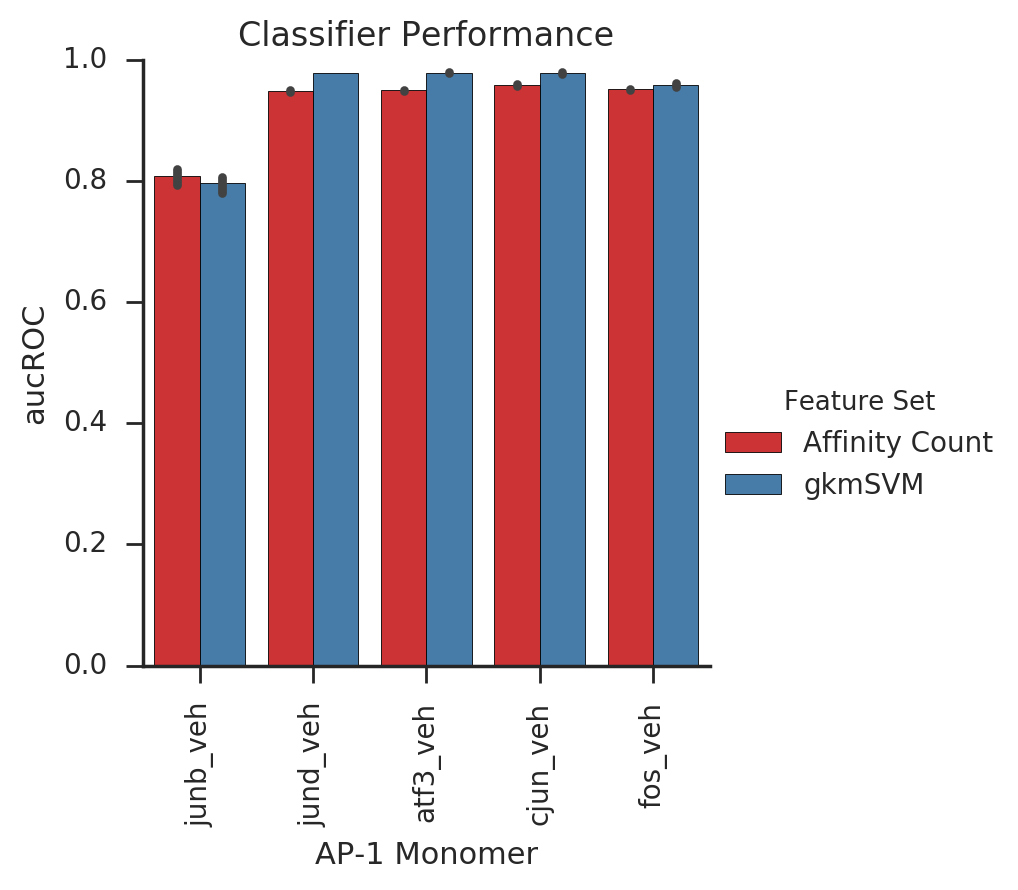

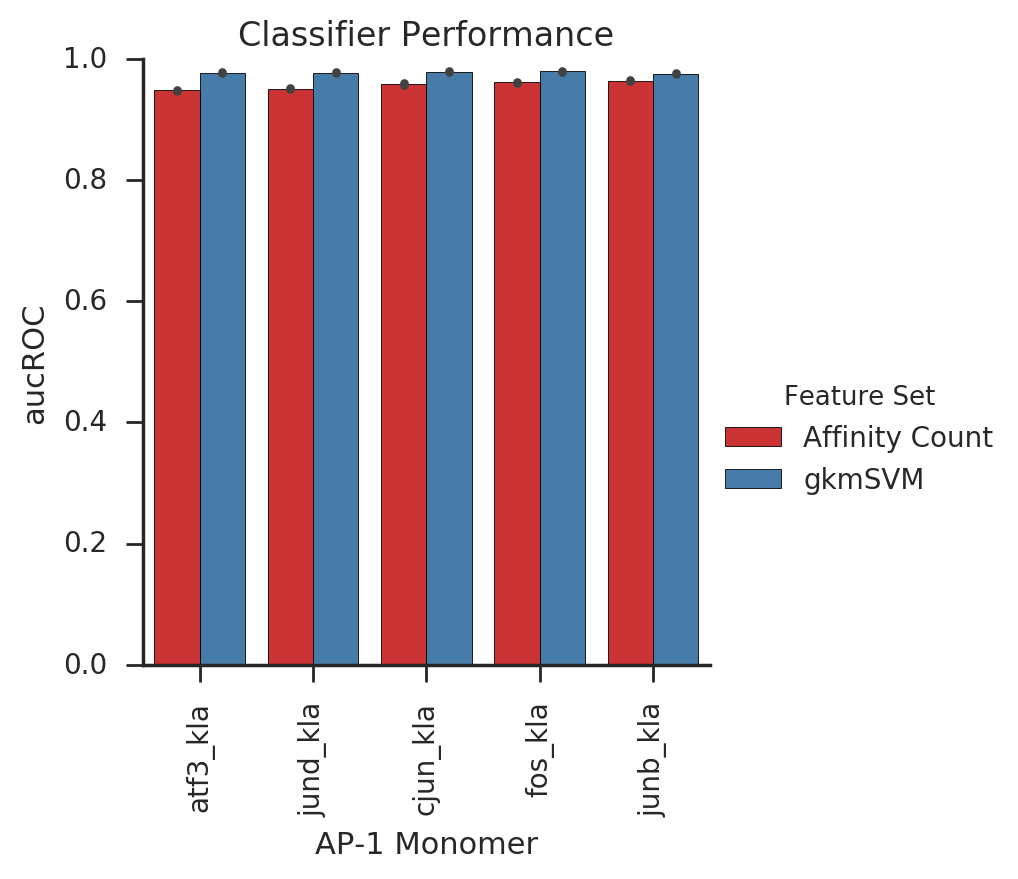

In [631]:
monomers = []
aucs = []
feature_set = []
for factor in sorted(factor_auc_background_dict.keys()):
#     monomers = monomers + numIterations * [factor]
#     aucs = aucs + factor_auc_background_dict[factor]
#     feature_set = feature_set + numIterations * ['LR']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_affinityCount[factor]
    feature_set = feature_set + numIterations * ['Affinity Count']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_gkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'AUC':aucs,
                     'Feature Set': feature_set
                     })

# vehicle plot


for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_auc_background_dict[x])) for x in factor_auc_background_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='AUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=4,
                                    hue='Feature Set',
                                    kind = 'bar')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.0,1)
        plt.title('Classifier Performance')
        plt.show()

    

### Precision Recall

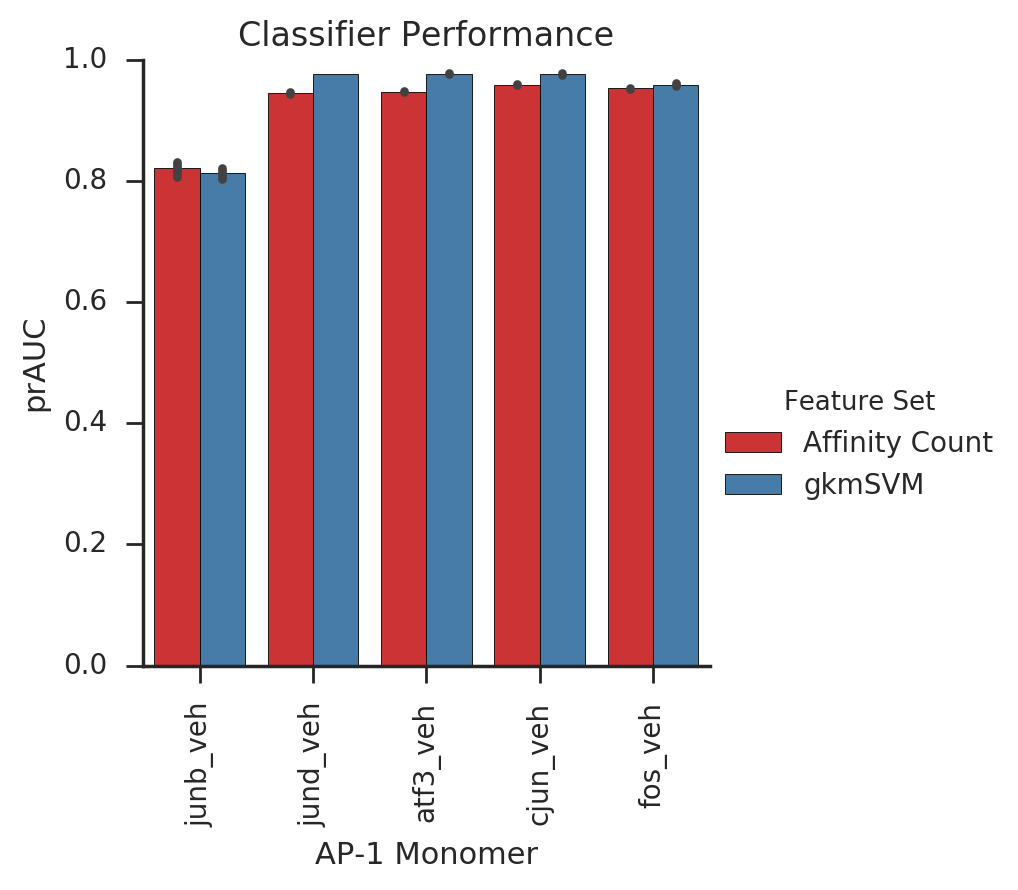

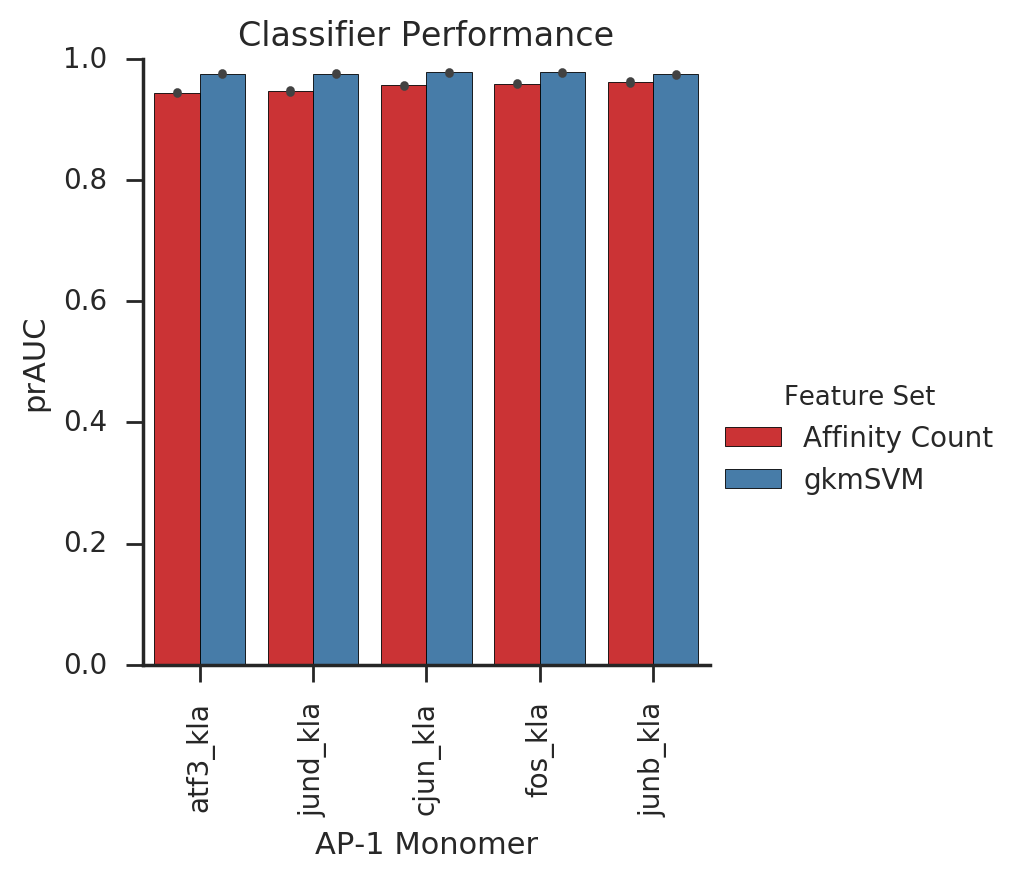

In [329]:
monomers = []
aucs = []
feature_set = []

for factor in sorted(factor_precision_background_dict.keys()):
#     monomers = monomers + numIterations * [factor]
#     aucs = aucs + factor_precision_background_dict[factor]
#     feature_set = feature_set + numIterations * ['LR']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_precision_dict_affinityCount[factor]
    feature_set = feature_set + numIterations * ['Affinity Count']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_precision_dict_gkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'prAUC':aucs,
                     'Feature Set': feature_set
                     })

# vehicle plot


for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_precision_background_dict[x])) for x in factor_precision_background_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='prAUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=4,
                                    hue='Feature Set',
                                    kind = 'bar'), 
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('prAUC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.0,1)
        plt.title('Classifier Performance')
        plt.show()

    

## Strains Stuff

In [651]:
# for monomers using all motifs
strain = 'balbc'
factor_auc_balbc_dict = {}
factor_meanCoeff_background_balbc_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
#         background_indices = motif_score_background_frame.index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == 'c57bl6' + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)
        all_aucs = []
        all_coefficients = []
        all_probs = None
        all_precisions = []
        all_intercepts = []
        for i in range(numIterations):  

            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_split(
                features, labels, test_size = test_size)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)
            all_intercepts.append(lr_classifier.intercept_[0])

            if all_probs == None:
                all_probs = probs
            else:
                all_probs = all_probs + probs
        mean_coefficients = np.mean(all_coefficients, axis=0)
        factor_auc_balbc_dict[monomer + '_' + treatment] = all_aucs
        factor_meanCoeff_background_balbc_dict[monomer + '_' + treatment] = mean_coefficients
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:53: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.925143357692 1.31713035041e-06 precision: 0.920201464469 1.33460882601e-06 numTestPositives: 8728
cjun_veh roc: 0.926177432929 2.11608581502e-06 precision: 0.929872716191 3.0688072425e-06 numTestPositives: 6781
fos_veh roc: 0.961129946555 3.84381163754e-06 precision: 0.963556036334 4.75025141109e-06 numTestPositives: 1232
junb_veh roc: 0.831578947368 0.00262858633681 precision: 0.819875638038 0.00743172515555 numTestPositives: 19
jund_veh roc: 0.887127428726 1.07272817738e-06 precision: 0.893054069609 2.40555360326e-06 numTestPositives: 13768
atf3_kla roc: 0.910494930504 1.16327893877e-06 precision: 0.904270311264 2.07088281695e-06 numTestPositives: 17501
cjun_kla roc: 0.916065842536 5.5105193858e-07 precision: 0.919176958232 1.25581711845e-06 numTestPositives: 7589
fos_kla roc: 0.927699625129 5.29246265836e-07 precision: 0.924891138908 9.86200621188e-07 numTestPositives: 14532
junb_kla roc: 0.940980014571 1.18805384757e-06 precision: 0.940611951242 1.57028320183e-06 nu

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


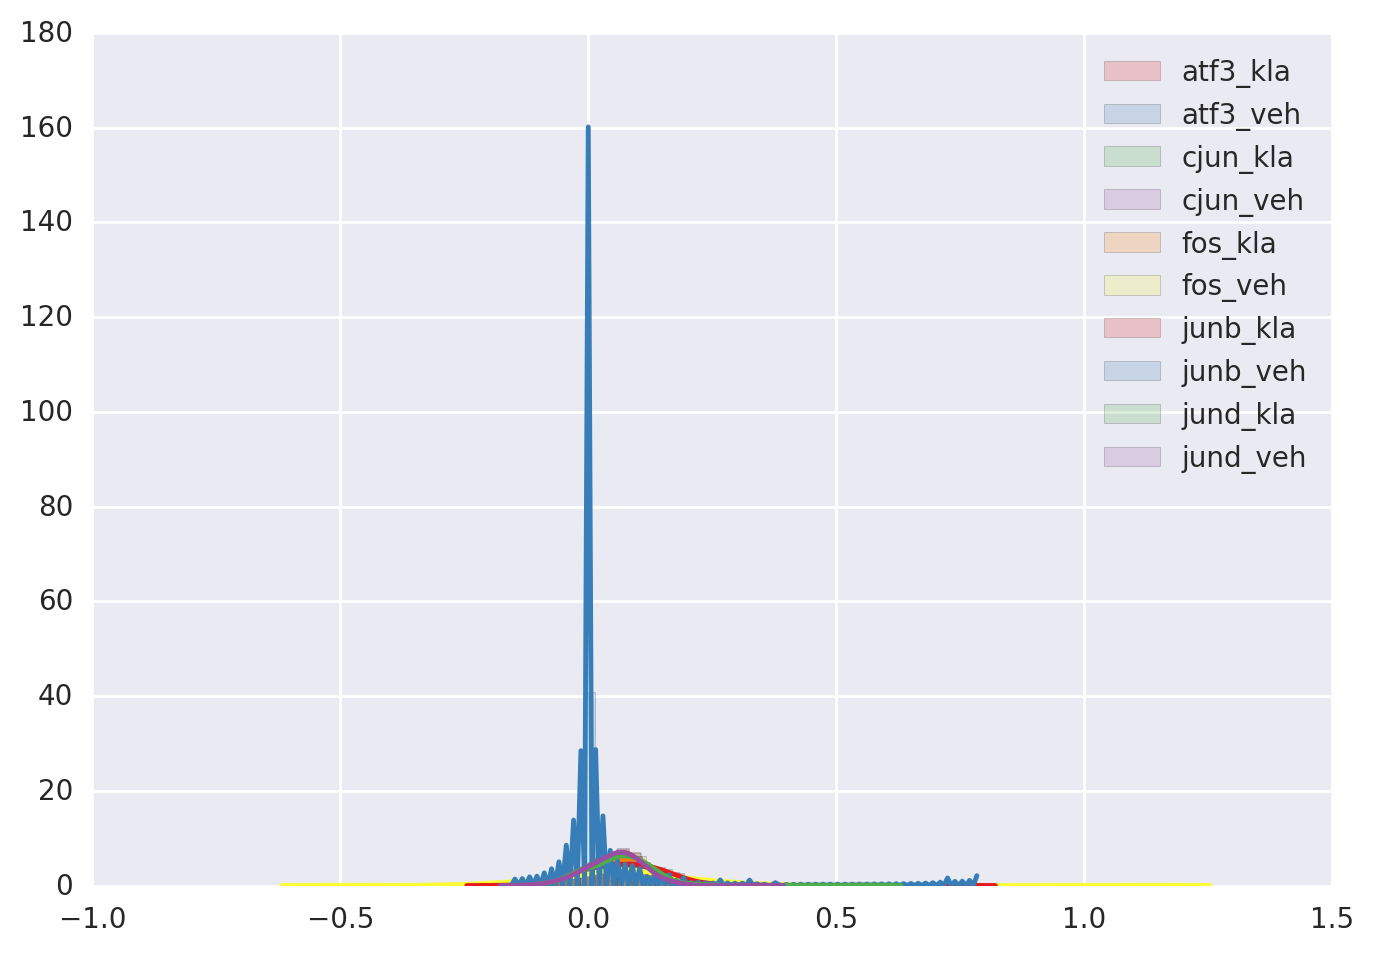

In [580]:
top_motifs_dict = {}
weight_threshold = 1.5
coefficients_background_balbc_frame = pd.DataFrame(factor_meanCoeff_background_balbc_dict)
coefficients_background_balbc_frame.index = standardized_motif_background_frame.columns.values
for col in coefficients_background_balbc_frame.columns.values:
    sns.distplot(coefficients_background_balbc_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_background_balbc_frame = coefficients_background_balbc_frame[[]]
for col in coefficients_background_balbc_frame:
    coefficients_zscore_background_balbc_frame[col] = scipy.stats.mstats.zscore(coefficients_background_balbc_frame[col].values)

coefficients_zscore_background_balbc_frame.index = coefficients_background_balbc_frame.index.values
coefficients_zscore_background_balbc_frame.columns = coefficients_background_balbc_frame.columns.values


### Train on C57BL6 test on BALBC

In [652]:
# for monomers using motif counts and best motif score
strain1 = 'c57bl6'
strain2 = 'balbc'
factor_auc_c57bl6Trained_dict = {}
factor_precision_c57bl6Trained_dict = {}
weight_threshold = 0.0
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        data = coefficients_zscore_background_frame
        data = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ]
        top_motifs = data.index.values
        target_indices = summary_frame[summary_frame[strain1 + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == 'c57bl6' + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]

        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)][top_motifs]
        background_affinity_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)][top_motifs]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        affinity_features = affinity_features[top_motifs]
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)

        # get data for other strain
        target_indices_strain2 = summary_frame[summary_frame[strain2 + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_affinity_features_strain2 = standardized_BALBCJ_motif_frame[standardized_BALBCJ_motif_frame.index.isin(target_indices_strain2)]

        # merge target and background features together 
        affinity_features_strain2 = pd.concat([target_affinity_features_strain2, background_affinity_features])
        affinity_features_strain2 = affinity_features_strain2[top_motifs]
        labels_strain2 = pd.Series(data = [True] * len(target_indices_strain2) + [False] * len(background_indices),
                           index = affinity_features_strain2.index.values)
        
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        all_intercepts = []
        for i in range(numIterations):  

            # split data into training and test sets seperately for each strain
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_affinity_features_strain2, test_affinity_features_strain2, training_labels_strain2, test_labels_strain2 = get_split(
                affinity_features_strain2, labels_strain2, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])

            training_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs]])
            test_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features_strain2)
            test_count_scores = count_classifier.decision_function(test_count_features_strain2)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels_strain2, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels_strain2, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

        factor_auc_c57bl6Trained_dict[monomer + '_' + treatment] = all_aucs
        factor_precision_c57bl6Trained_dict[monomer + '_' + treatment] = all_precisions
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.956126203299 3.58822671111e-07 precision: 0.942588515956 7.3258329436e-07 numTestPositives: 11073
cjun_veh roc: 0.951916325262 1.60935746583e-06 precision: 0.955451995223 9.07100008515e-07 numTestPositives: 6363
fos_veh roc: 0.950935025935 1.97506466316e-05 precision: 0.958511069885 2.50060342628e-05 numTestPositives: 999
junb_veh roc: 0.90123089983 0.00272732030491 precision: 0.548337833777 0.00649530483358 numTestPositives: 248
jund_veh roc: 0.929573688516 2.59014189376e-06 precision: 0.95054766122 1.91543179429e-06 numTestPositives: 9071
atf3_kla roc: 0.948700900819 2.75986081396e-07 precision: 0.946114128144 3.78172006722e-07 numTestPositives: 17428
cjun_kla roc: 0.946560761321 7.27474194506e-07 precision: 0.945054030237 1.12908902813e-06 numTestPositives: 8108
fos_kla roc: 0.950700401909 1.67906310935e-06 precision: 0.964720540717 1.40914258078e-06 numTestPositives: 9628
junb_kla roc: 0.954343223971 3.23044224374e-07 precision: 0.964141794295 1.87463722562e-07 numT

### Train on BALBC test on C57BL6J

In [687]:
# for monomers using motif counts and best motif score
strain1 = 'c57bl6'
strain2 = 'balbc'
factor_auc_balbcTrained_dict = {}
factor_precision_balbcTrained_dict = {}
weight_threshold = 0.0
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        data = coefficients_zscore_background_frame
        data = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ]
        top_motifs = data.index.values
        target_indices = summary_frame[summary_frame[strain1 + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == 'c57bl6' + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]

        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)][top_motifs]
        background_affinity_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)][top_motifs]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        affinity_features = affinity_features[top_motifs]
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)

        # get data for other strain
        target_indices_strain2 = summary_frame[summary_frame[strain2 + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_affinity_features_strain2 = standardized_BALBCJ_motif_frame[standardized_BALBCJ_motif_frame.index.isin(target_indices_strain2)]

        # merge target and background features together 
        affinity_features_strain2 = pd.concat([target_affinity_features_strain2, background_affinity_features])
        affinity_features_strain2 = affinity_features_strain2[top_motifs]
        labels_strain2 = pd.Series(data = [True] * len(target_indices_strain2) + [False] * len(background_indices),
                           index = affinity_features_strain2.index.values)
        
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        all_intercepts = []
        for i in range(numIterations):  

            # split data into training and test sets seperately for each strain
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_affinity_features_strain2, test_affinity_features_strain2, training_labels_strain2, test_labels_strain2 = get_split(
                affinity_features_strain2, labels_strain2, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])

            training_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs]])
            test_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features_strain2, training_labels_strain2)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features_strain2, training_labels_strain2)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features_strain2)
            training_count_scores = count_classifier.decision_function(training_count_features_strain2)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels_strain2)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

        factor_auc_balbcTrained_dict[monomer + '_' + treatment] = all_aucs
        factor_precision_balbcTrained_dict[monomer + '_' + treatment] = all_precisions
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.944983660523 1.03070454273e-06 precision: 0.943306638082 2.37204872649e-06 numTestPositives: 11073
cjun_veh roc: 0.961250556927 2.1859394592e-06 precision: 0.961226884586 2.84100712869e-06 numTestPositives: 6363
fos_veh roc: 0.920112905698 3.36007573994e-05 precision: 0.92980980754 1.64529731201e-05 numTestPositives: 999
junb_veh roc: 0.742548452133 0.00296455603173 precision: 0.77901276078 0.00149321199982 numTestPositives: 248
jund_veh roc: 0.955106445324 6.83889829756e-07 precision: 0.953221567141 7.59599487854e-07 numTestPositives: 9071
atf3_kla roc: 0.942207040789 1.25063224997e-07 precision: 0.93958342545 1.17047102952e-07 numTestPositives: 17428
cjun_kla roc: 0.957817320149 2.65171731573e-06 precision: 0.955480654671 4.00650989082e-06 numTestPositives: 8108
fos_kla roc: 0.959149832644 4.97982723289e-07 precision: 0.957774285662 5.83290652563e-07 numTestPositives: 9628
junb_kla roc: 0.962244214101 3.56190482004e-07 precision: 0.960770446958 7.7197202898e-07 numTes

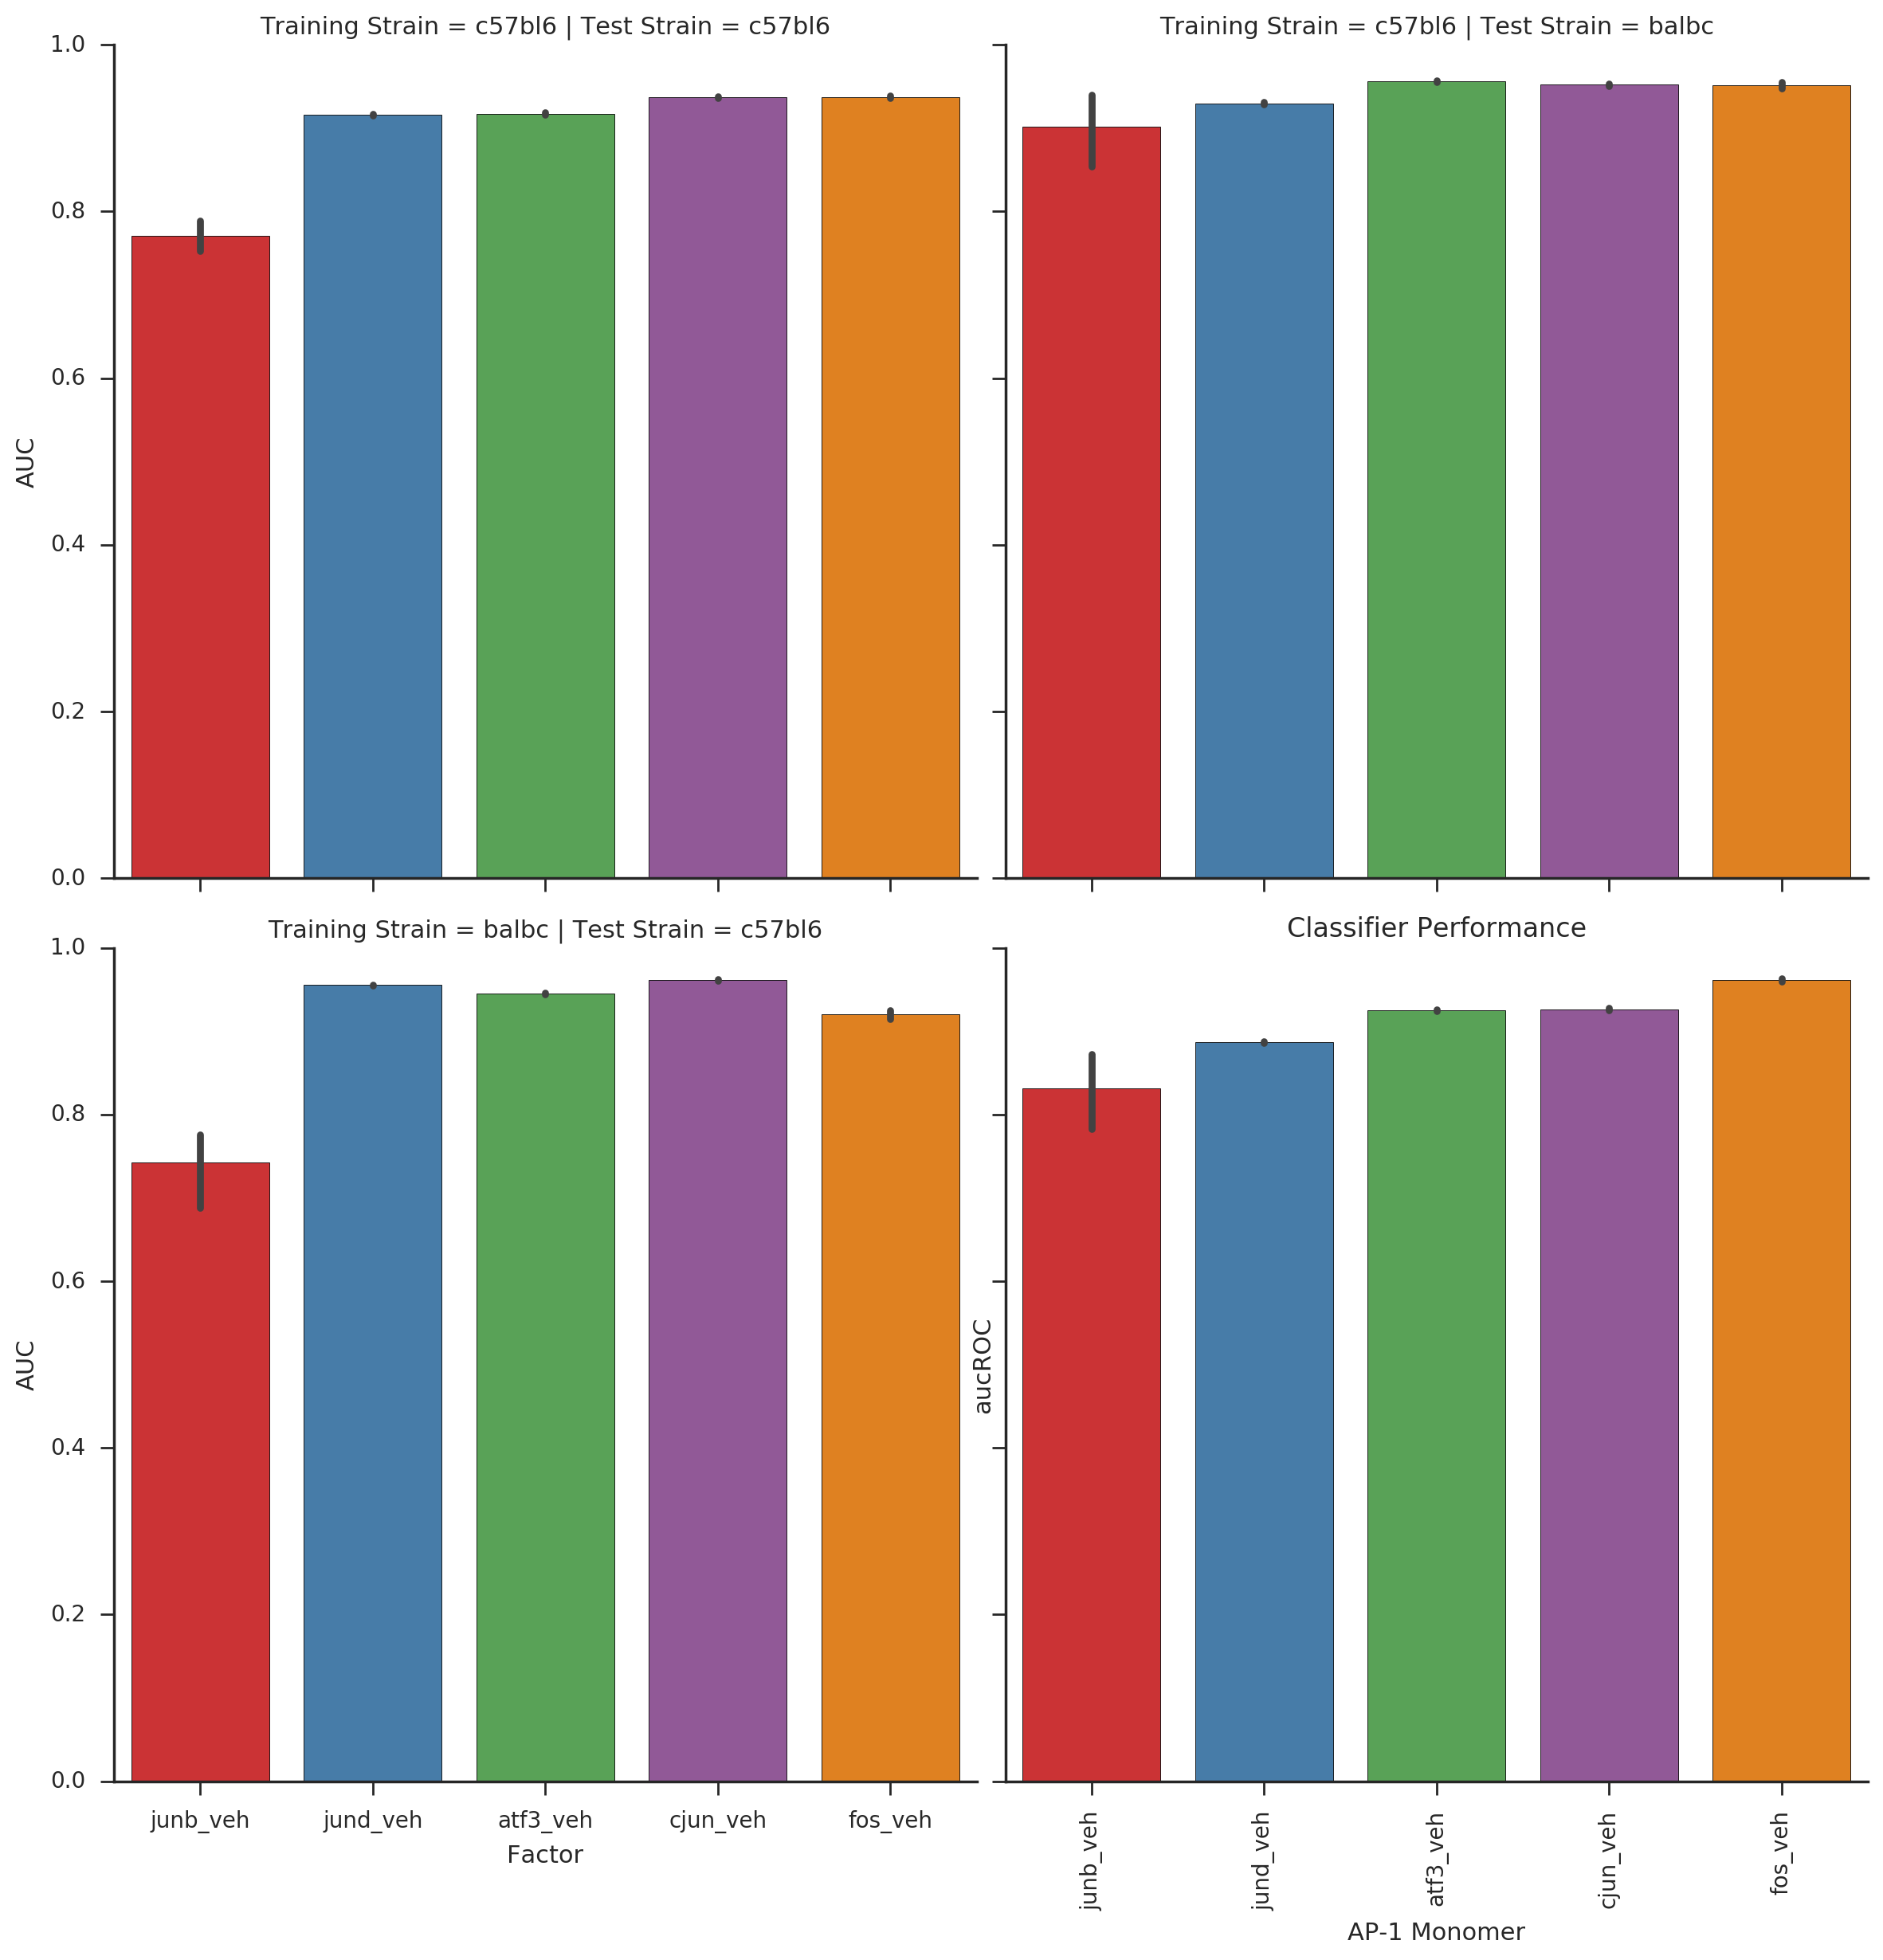

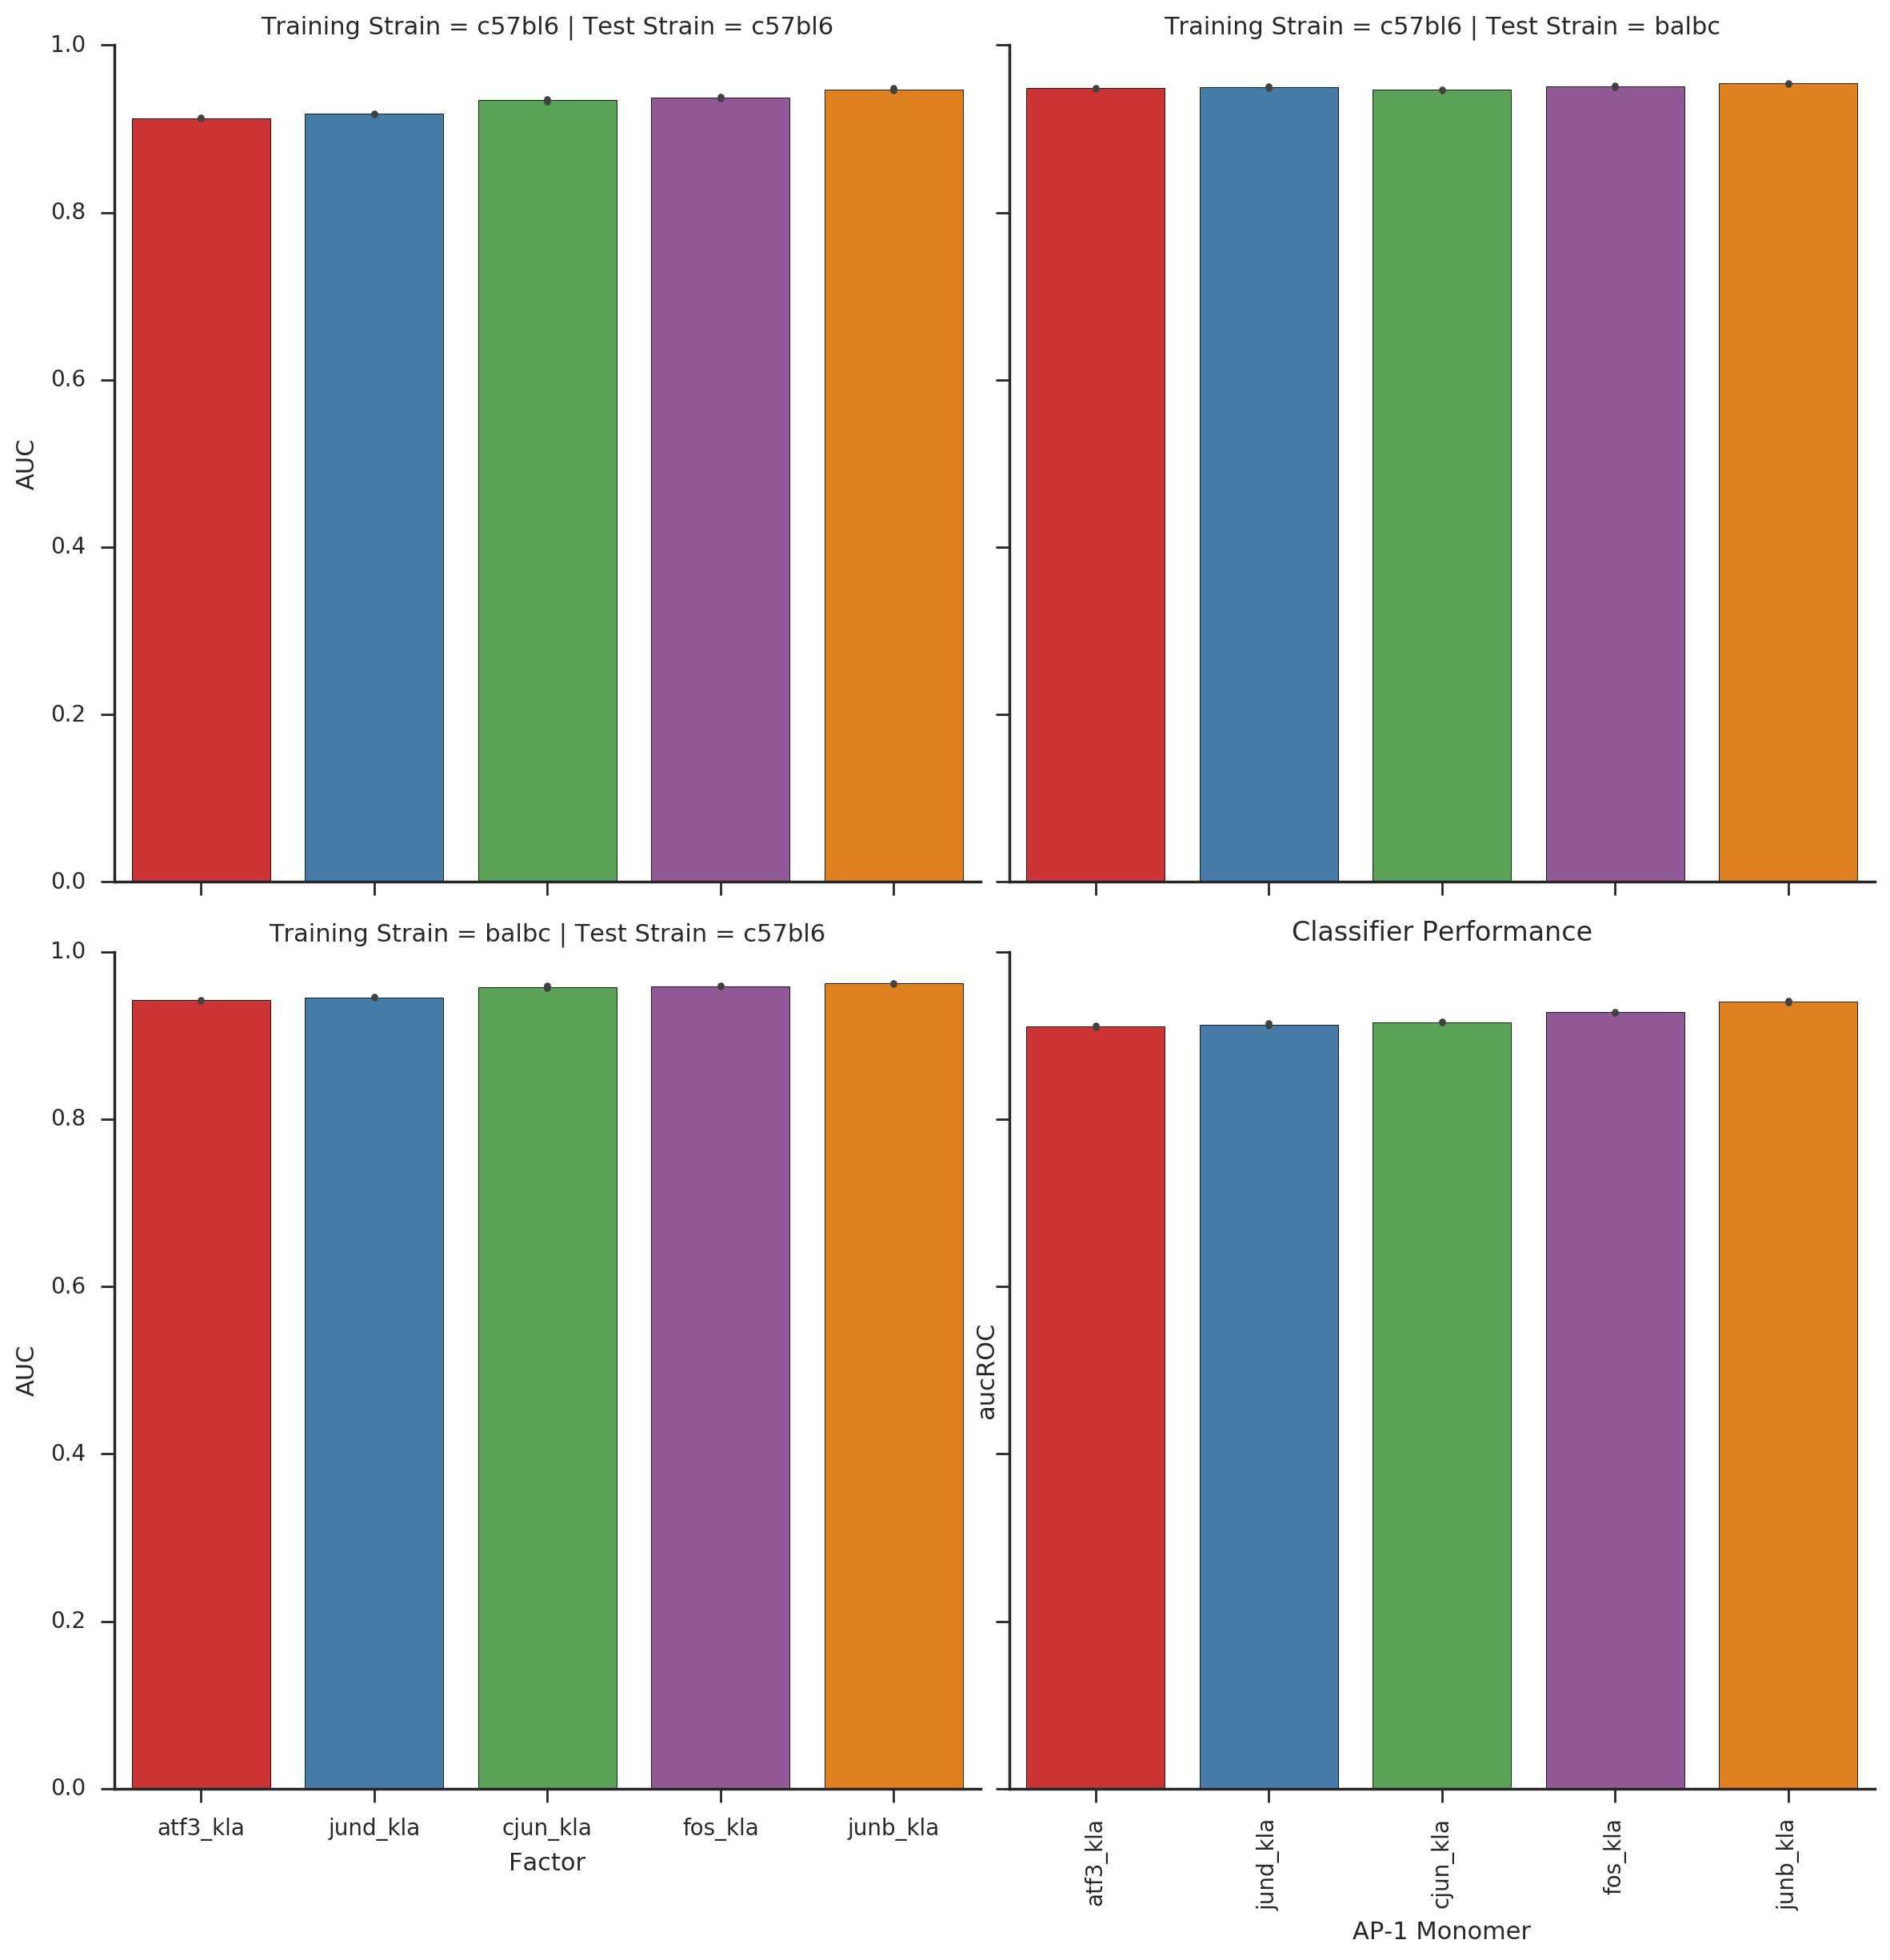

In [688]:
monomers = []
aucs = []
training_strains = []
test_strains = []
for factor in sorted(factor_auc_background_dict.keys()):
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_background_dict[factor]
    training_strains = training_strains + numIterations * ['c57bl6']
    test_strains = test_strains + numIterations * ['c57bl6']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_balbc_dict[factor]
    training_strains = training_strains + numIterations * ['balbc']
    test_strains = test_strains + numIterations * ['balbc']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_c57bl6Trained_dict[factor]
    training_strains = training_strains + numIterations * ['c57bl6']
    test_strains = test_strains + numIterations * ['balbc']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_balbcTrained_dict[factor]
    training_strains = training_strains + numIterations * ['balbc']
    test_strains = test_strains + numIterations * ['c57bl6']
    
data = pd.DataFrame({'Factor':monomers,
                     'AUC':aucs,
                     'Training Strain': training_strains,
                     'Test Strain': test_strains
                     })

# vehicle plot


for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_auc_background_dict[x])) for x in factor_auc_background_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='AUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=6,
                                    row='Training Strain',
                                    col='Test Strain',
                                    kind = 'bar',
                                    color='black')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.0,1)
        plt.title('Classifier Performance')
        plt.show()

    

### Copy Data Files

In [640]:
! cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/merged_annotated_peaks_ap1TagCounts.tsv ./

### Read in Tag Counts Frame

In [641]:
# average tag counts from both replicates
ap1_tag_frame = pd.read_csv('./merged_annotated_peaks_ap1TagCounts.tsv', sep='\t')
ap1_tag_frame.index = ap1_tag_frame.ix[:,0].values
ap1_tag_frame = ap1_tag_frame[[x for x in ap1_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[-1] for x in ap1_tag_frame.columns.values]
ap1_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[0:5]).split('-')[0] for x in columns]))

ap1_meanTag_dict = {}
for ft in factor_treatments:
    ap1_meanTag_dict[ft] = ap1_tag_frame[[x for x in ap1_tag_frame.columns if ft in x]].mean(axis=1).values
ap1_meanTag_frame = pd.DataFrame(ap1_meanTag_dict)
ap1_meanTag_frame = ap1_meanTag_frame[factor_treatments]
ap1_meanTag_frame.columns = [x.replace('_Thiomac_ChIP','').lower() for x in ap1_meanTag_frame.columns.values]
ap1_meanTag_frame.index = ap1_tag_frame.index.values

## Plot Classifier Score Differences and Tag Count Differences

In [643]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  



In [772]:
np.sum((fold_changes >= fold_threshold) | (fold_changes <= 1/fold_threshold))

19

In [ ]:
# for monomers using motif counts and best motif score
strain1 = 'c57bl6'
strain2 = 'balbc'
fold_threshold =4.0
tag_threshold = 16.0
factor_auc_balbcTrained_dict = {}
factor_precision_balbcTrained_dict = {}
weight_threshold = 0.0
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[(summary_frame[strain1 + '_' + monomer + '_' + treatment] > 0.0) |
                                       (summary_frame[strain2 + '_' + monomer + '_' + treatment] > 0.0)].index.values
        current_tag_frame = ap1_meanTag_frame[[strain1 + '_' + monomer + '_' + treatment,
                           strain2 + '_' + monomer + '_' + treatment]]
        current_tag_frame = current_tag_frame[(current_tag_frame.min(axis=1) > tag_threshold) &
                                              (current_tag_frame.index.isin(target_indices))]
        tags_strain1 = current_tag_frame[strain1 + '_' + monomer + '_' + treatment]
        tags_strain2 = current_tag_frame[strain2 + '_' + monomer + '_' + treatment]

        normalized_tags_strain1, normalized_tags_strain2 = quantileNormalize(tags_strain1, tags_strain2)
        normalized_tags_strain1 = pd.Series(data = normalized_tags_strain1, index = tags_strain1.index.values)
        normalized_tags_strain2 = pd.Series(data = normalized_tags_strain2, index = tags_strain2.index.values)
#         fold_changes = (tags_strain1 + 1.0) / (tags_strain2 + 1.0)
        fold_changes = (normalized_tags_strain1 + 1.0) / (normalized_tags_strain2 + 1.0)
        strain_specific_indices = fold_changes[(fold_changes >= fold_threshold) | 
                                               (fold_changes <= 1/fold_threshold)].index.values
        print(monomer, treatment, len(strain_specific_indices))
        
        
        data = coefficients_zscore_background_balbc_frame
        data = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ]
        top_motifs = data.index.values

        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == 'c57bl6' + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(strain_specific_indices))]

        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(strain_specific_indices)]
        background_affinity_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        affinity_features = affinity_features[top_motifs]
        labels = pd.Series(data = [True] * len(strain_specific_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)

        # get data for other strain
        target_affinity_features_strain2 = standardized_BALBCJ_motif_frame[standardized_BALBCJ_motif_frame.index.isin(strain_specific_indices)]

        # merge target and background features together 
        affinity_features_strain2 = pd.concat([target_affinity_features_strain2, background_affinity_features])
        affinity_features_strain2 = affinity_features_strain2[top_motifs]
        labels_strain2 = pd.Series(data = [True] * len(strain_specific_indices) + [False] * len(background_indices),
                           index = affinity_features_strain2.index.values)
        
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        all_intercepts = []
        all_probs = []
        for i in range(numIterations):  

            # split data into training and test sets seperately for each strain
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_affinity_features_strain2, test_affinity_features_strain2, training_labels_strain2, test_labels_strain2 = get_split(
                affinity_features_strain2, labels_strain2, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])

            training_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs]])
            test_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features_strain2)
            test_count_scores = count_classifier.decision_function(test_count_features_strain2)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)
            
            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            
            # score all peaks
            strainSpecific_count_features_strain1 = motif_count_frame[motif_count_frame.index.isin(strain_specific_indices)][top_motifs]
            strainSpecific_count_features_strain2 = motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(strain_specific_indices)][top_motifs]
            
            strainSpecific_affinity_features_strain1 = standardized_motif_frame[standardized_motif_frame.index.isin(strain_specific_indices)][top_motifs]
            strainSpecific_affinity_features_strain2 = standardized_BALBCJ_motif_frame[standardized_BALBCJ_motif_frame.index.isin(strain_specific_indices)][top_motifs]


            affinity_scores_strain1 = affinity_classifier.decision_function(strainSpecific_affinity_features_strain1)
            count_scores_strain1 = count_classifier.decision_function(strainSpecific_count_features_strain1)
            
            affinity_scores_strain2 = affinity_classifier.decision_function(strainSpecific_affinity_features_strain2)
            count_scores_strain2 = count_classifier.decision_function(strainSpecific_count_features_strain2)
            
            
            combined_features_strain1 = pd.DataFrame({'Affinity':affinity_scores_strain1,
                                                       'Count':count_scores_strain1})
            combined_features_strain2 = pd.DataFrame({'Affinity':affinity_scores_strain2,
                                                       'Count':count_scores_strain2})
            
            all_probs_strain1 = combined_classifier.predict_proba(combined_features_strain1)[:, 1]
            all_probs_strain2 = combined_classifier.predict_proba(combined_features_strain2)[:, 1]
            
            all_scores_strain1 = combined_classifier.decision_function(combined_features_strain1)
            all_scores_strain2 = combined_classifier.decision_function(combined_features_strain2)
            
            prob_differences = all_probs_strain1 - all_probs_strain2
            score_differences = all_scores_strain1  - all_scores_strain2
            strainSpecific_logFoldChange = np.log2(fold_changes[fold_changes.index.isin(strain_specific_indices)])
            plt.scatter(strainSpecific_logFoldChange, 
                score_differences,
               marker = '.', 
               edgecolor = 'None')
#             sns.kdeplot(strainSpecific_logFoldChange, 
#                         score_differences,
#                        )
           
#             plt.xlabel('Fold Change')
#             plt.ylabel('Delta Classifier Score')
            plt.title(monomer + '_' + treatment)
    
            ax = plt.gca()
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect(abs(x1-x0)/abs(y1-y0))
            plt.show()
            break
#         print(monomer + '_' + treatment,
#               'roc:', np.mean(all_aucs), np.var(all_aucs),
#               'precision:', np.mean(all_precisions), np.var(all_precisions),  
#               'numTestPositives:', np.sum(test_labels)
#              )
        print(scipy.stats.pearsonr(np.abs(strainSpecific_logFoldChange), 
                        np.abs(score_differences)))
                

## Introspection

atf3 veh ['ap-1', 'arid3a', 'arid3b', 'atf7_batf3_creb5', 'bhlh', 'bhlhe23', 'cebp', 'ctcf', 'dmrt3', 'dux', 'e2f7', 'esr1', 'esrr', 'figla_id4_snai2_tcf3_tcf4', 'homeobox-2', 'hoxa5', 'id2_mlxip', 'irf7-8-9', 'klf', 'maf_nrl', 'msc_myf6_tfap4', 'nfkb', 'nkx2-5var.2', 'nr2_rxr', 'pax1_pax9', 'pax2', 'pax5', 'rel', 'smad3', 'sox10', 'spi1-c', 'spz1', 'tfcp2', 'tp63', 'zfx', 'znf263', 'znf740']


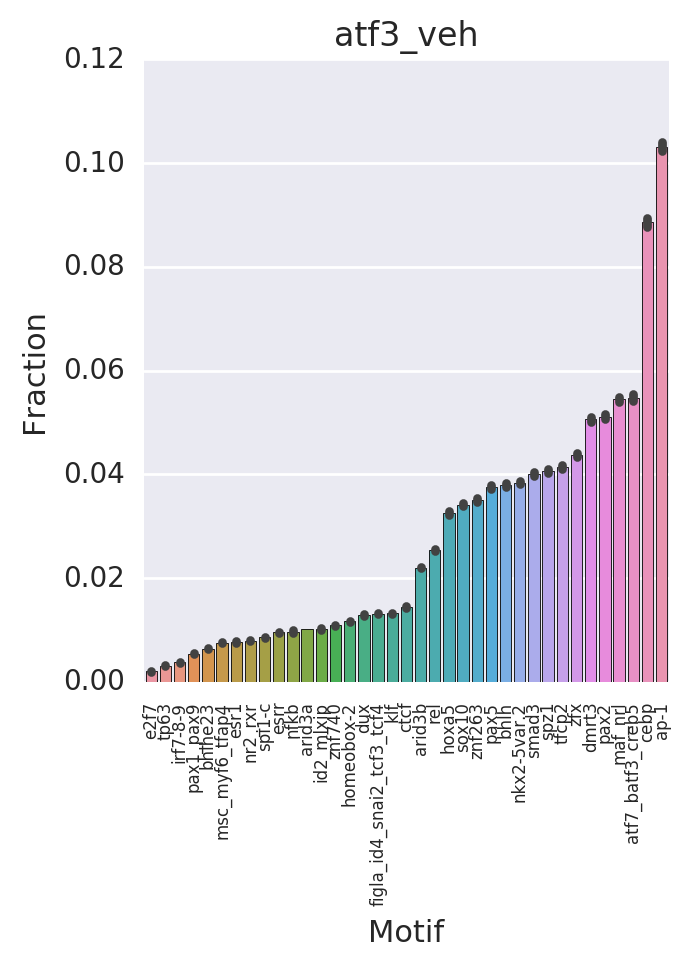

cjun veh ['ap-1', 'arid3a', 'arid3b', 'arnt_mycn', 'atf7_batf3_creb5', 'cebp', 'ctcf', 'dbp_hlf_tef', 'dmrt3', 'e2f7', 'ebox', 'esr1', 'figla_id4_snai2_tcf3_tcf4', 'homeobox-2', 'homeobox-3', 'id2_mlxip', 'irf2', 'klf', 'maf_nrl', 'mef2c', 'meis', 'nkx2-5var.2', 'pax1_pax9', 'pax2', 'pax5', 'rel', 'rreb1', 'runx', 'smad3', 'spz1', 'tfcp2', 'zeb1', 'zfx', 'znf263', 'znf740']


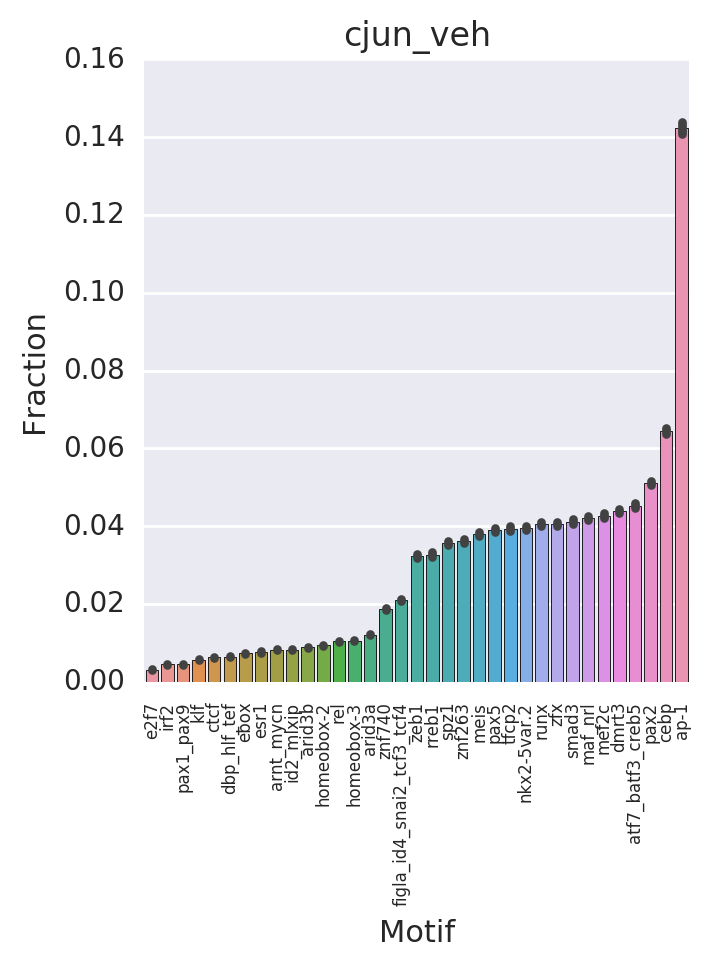

fos veh ['ap-1', 'arid3b', 'arid5a', 'atf7_batf3_creb5', 'ctcf', 'cux', 'dmrt3', 'id2_mlxip', 'irf7-8-9', 'isl2_nkx3-1_nkx3-2', 'myog_tcf12', 'mzf1', 'nfkb', 'nfya', 'nfyb', 'pparg_rxra', 'sox17', 'spib', 'tcf7', 'tcfl5', 'yy2', 'zfx', 'znf354c', 'znf410']


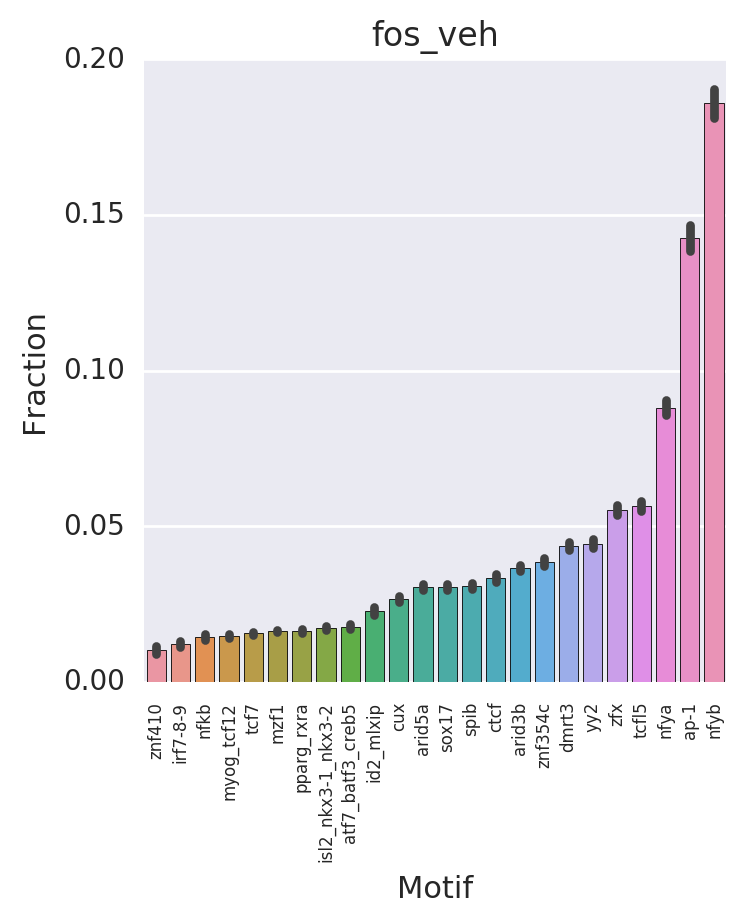

junb veh ['arid3b', 'cdx', 'cux', 'dmrt3', 'e2f8', 'elf', 'hnf1', 'homeobox-3', 'homeobox-5', 'hoxa11', 'lin54', 'mecom', 'mef2a-b-d', 'mga_tbx', 'myog_tcf12', 'nfi', 'nkx2-5', 'nkx2-5var.2', 'nr4a2', 'nrf1', 'pax3_pax7', 'spi1-c', 'spib', 'srf', 'stat1-3', 'stat6', 'tbp', 'tead', 'tfcp2', 'thap1', 'tp53', 'tp73', 'zeb1', 'zfx', 'znf740']


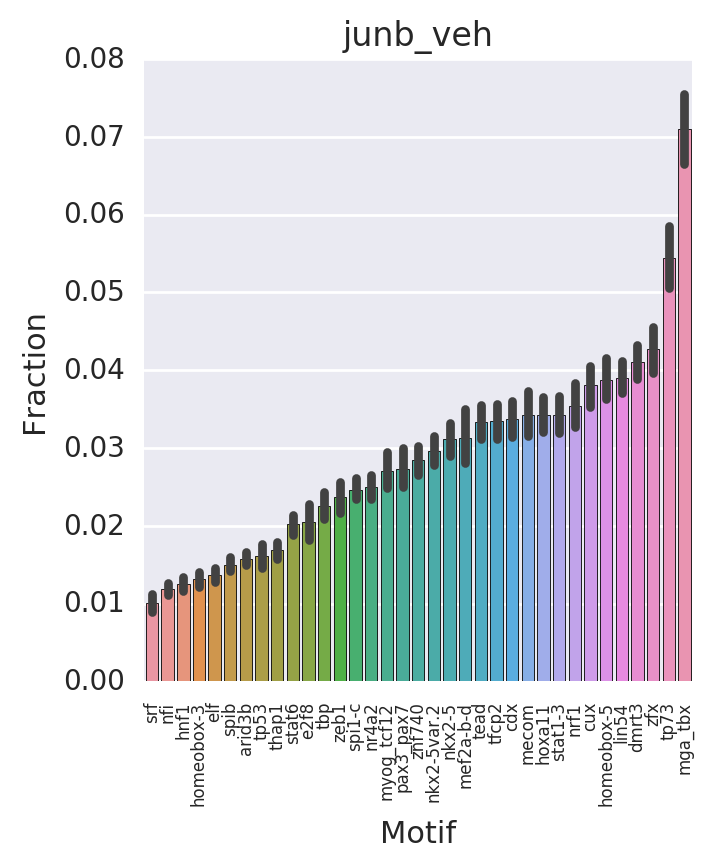

jund veh ['ap-1', 'arid3a', 'arid3b', 'arnt_mycn', 'ascl2_nhlh1', 'cebp', 'dbp_hlf_tef', 'dmrt3', 'e2f2', 'esr1', 'figla_id4_snai2_tcf3_tcf4', 'hnf4a', 'homeobox-3', 'hoxd8', 'id2_mlxip', 'irf7-8-9', 'maf_nrl', 'nfkb', 'nkx2-5var.2', 'nr2_rxr', 'pax1_pax9', 'pax2', 'pax3_pax7', 'pax5', 'rel', 'runx', 'smad3', 'spz1', 'tcf21', 'tfcp2', 'tp63', 'znf263', 'znf740']


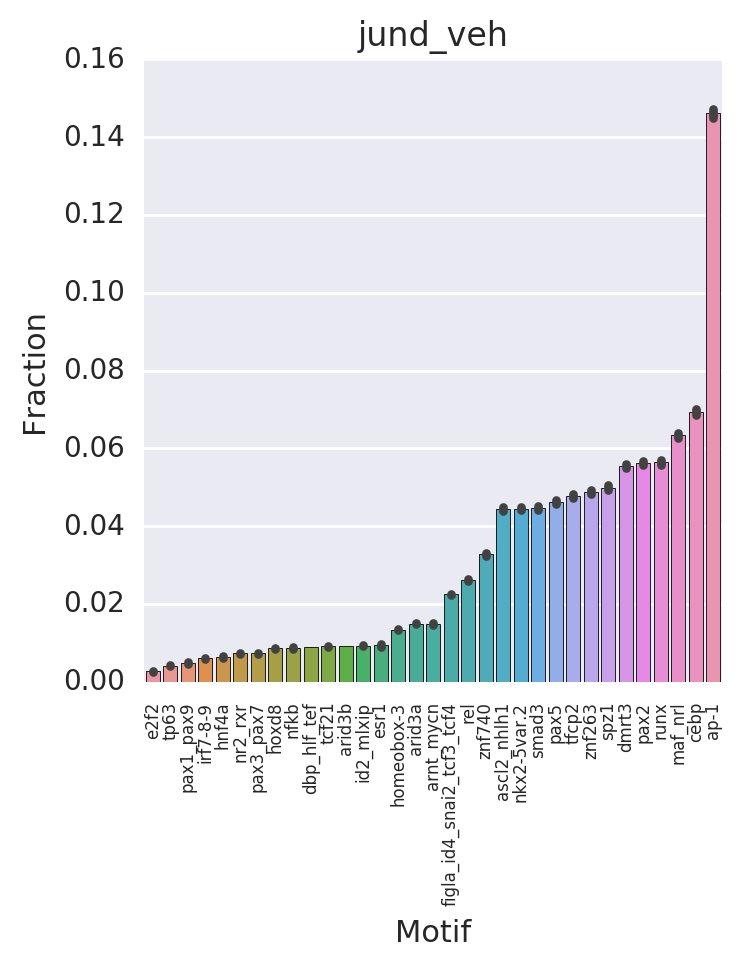

atf3 kla ['ap-1', 'arid3a', 'arid3b', 'atf7_batf3_creb5', 'cebp', 'creb3-l1', 'ctcf', 'dmrt3', 'dux', 'dux4', 'duxa', 'e2f7', 'ebox', 'elk_etv', 'esr1', 'figla_id4_snai2_tcf3_tcf4', 'homeobox-2', 'hoxa5', 'hoxc9', 'maf_nrl', 'meis', 'nkx2-5var.2', 'nr2_rxr', 'nr2f1', 'pax2', 'pax3_pax7', 'rreb1', 'runx', 'spi1-c', 'tp63', 'zfx', 'znf263', 'znf740']


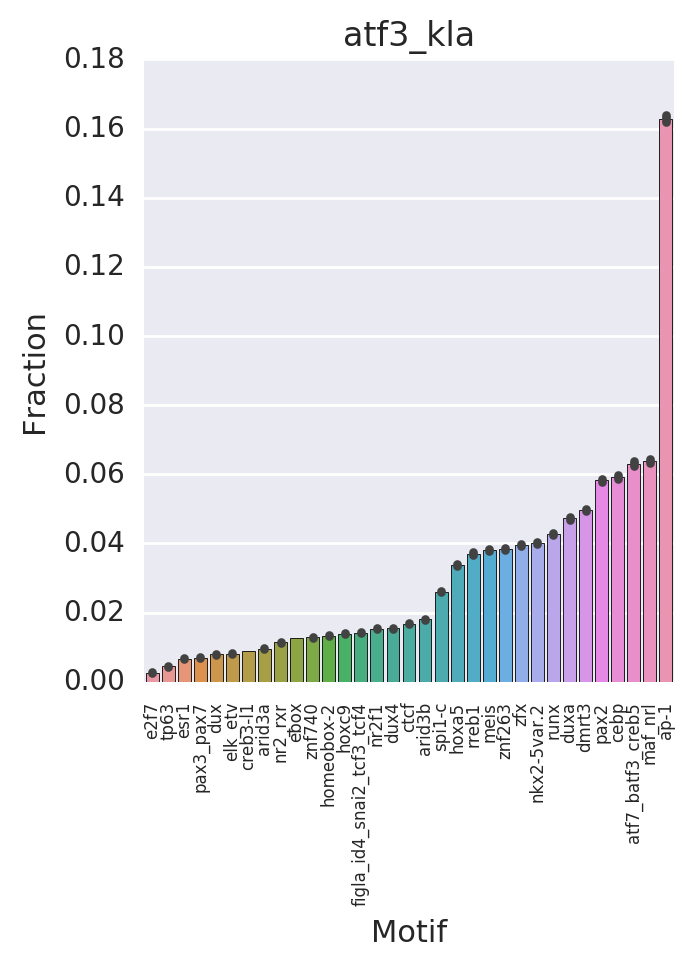

cjun kla ['ap-1', 'arid3a', 'arid3b', 'arnt_mycn', 'atf7_batf3_creb5', 'cebp', 'ctcf', 'dux', 'esr1', 'esr2', 'esrr', 'figla_id4_snai2_tcf3_tcf4', 'homeobox-2', 'homeobox-3', 'hoxc9', 'id2_mlxip', 'maf_nrl', 'nfi', 'pax2', 'pax5', 'rel', 'runx', 'smad3', 'spi1-c', 'znf740']


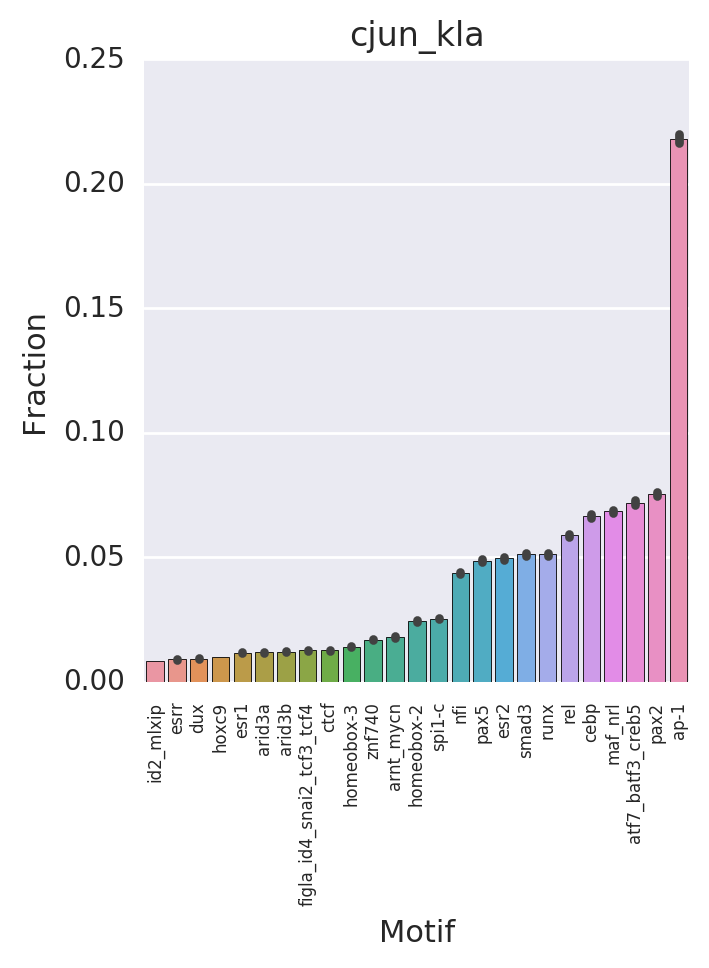

fos kla ['ap-1', 'arid3b', 'ctcf', 'dbp_hlf_tef', 'dmrt3', 'ebox', 'esr1', 'esr2', 'maf_nrl', 'myog_tcf12', 'nkx2-5var.2', 'nr2e1', 'nr2f1', 'pax2', 'pax3_pax7', 'phox2_prop', 'prdm1', 'rreb1', 'runx', 'sp4']


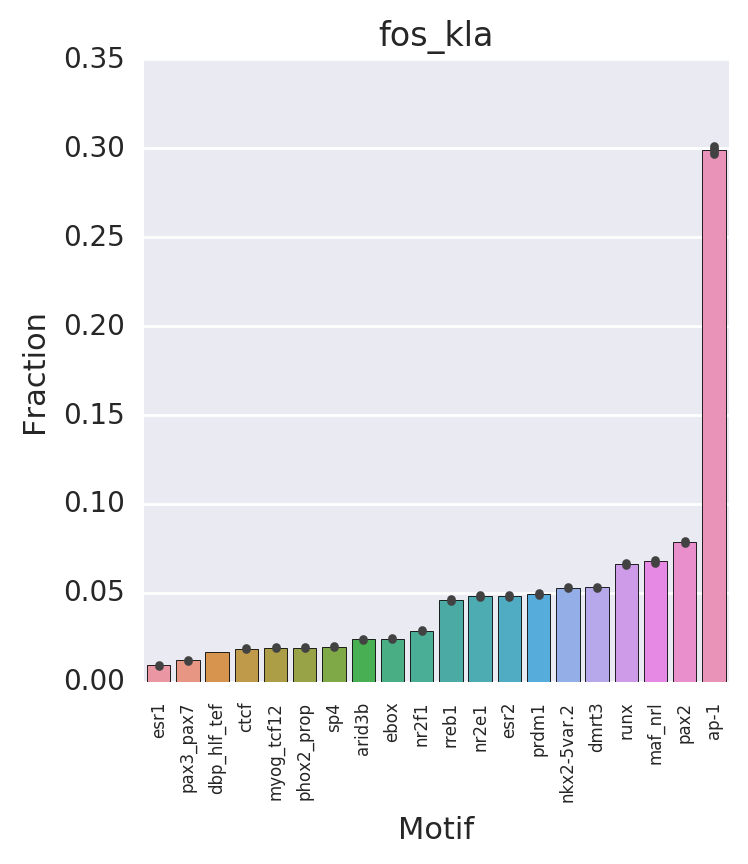

junb kla ['ap-1', 'arid3a', 'bhlhe23', 'cebp', 'ctcf', 'dbp_hlf_tef', 'e2f7', 'egr', 'esr1', 'esr2', 'hltf', 'homeobox-2', 'id2_mlxip', 'maf_nrl', 'meis', 'nkx2-5var.2', 'nr2_rxr', 'pax2', 'pax3_pax7', 'pax5', 'rel', 'rreb1', 'runx', 'sp4', 'spi1-c', 'tcf21', 'znf354c']


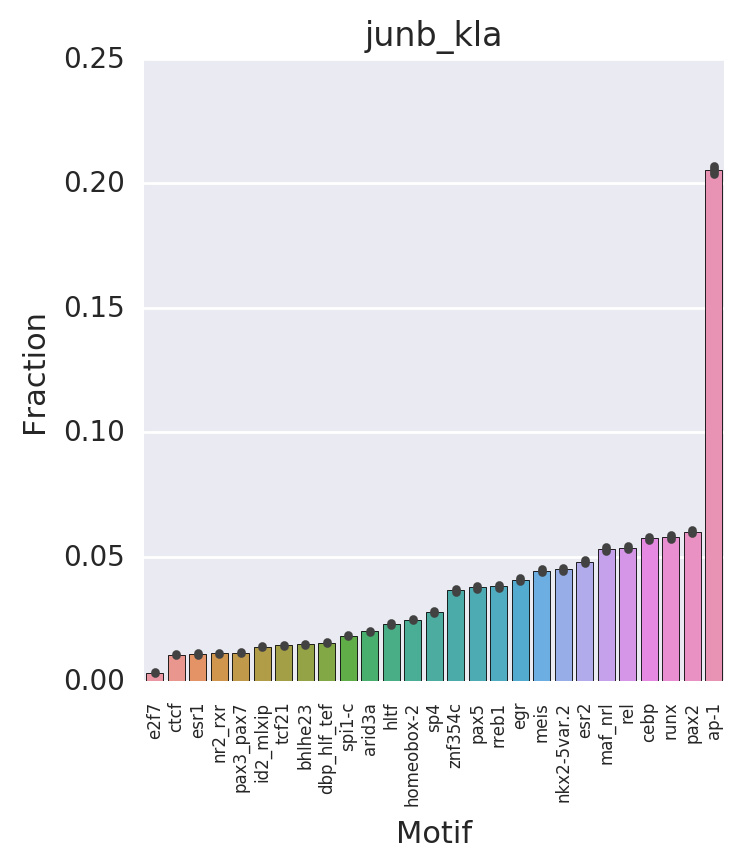

jund kla ['ap-1', 'arid3a', 'arid3b', 'arnt_mycn', 'atf7_batf3_creb5', 'cebp', 'ctcf', 'dbp_hlf_tef', 'dmrt3', 'dux', 'e2f7', 'egr', 'esr1', 'figla_id4_snai2_tcf3_tcf4', 'hltf', 'homeobox-2', 'homeobox-4', 'hoxa5', 'maf_nrl', 'mef2c', 'nkx2-5var.2', 'nr2f1', 'pax2', 'pax3_pax7', 'runx', 'sox10', 'spi1-c', 'tfcp2', 'zfx', 'znf263', 'znf740']


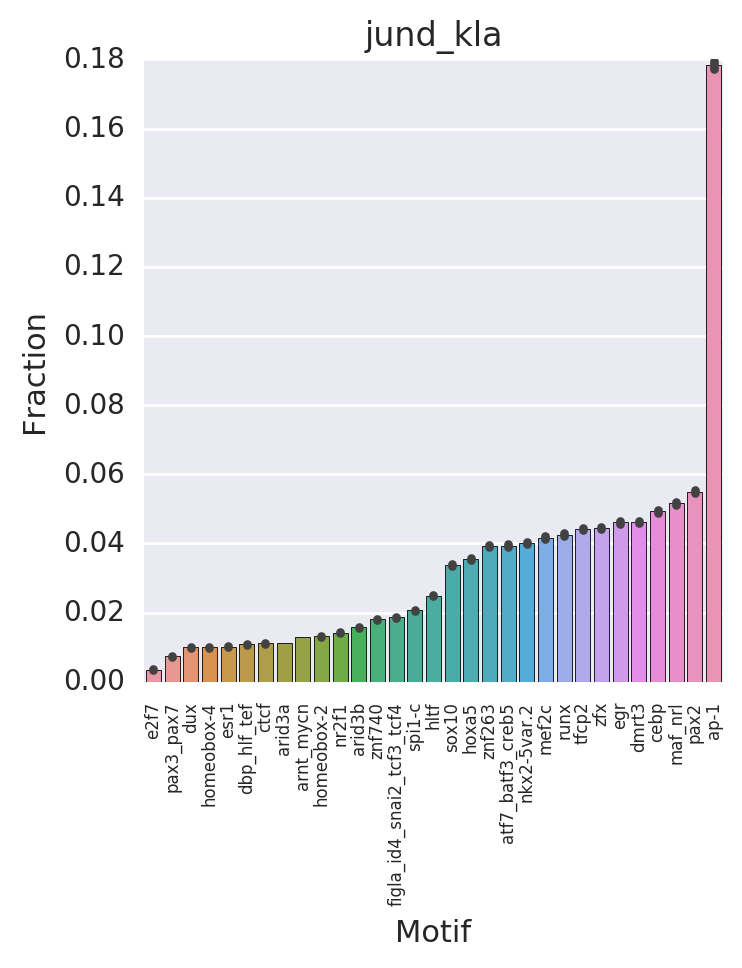

In [760]:
# for monomers using motif counts and best motif score
strain1 = 'c57bl6'
weight_threshold = 1.25
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        data = coefficients_zscore_background_frame
        data = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ]
        top_motifs = data.index.values
        print(monomer, treatment, sorted(top_motifs))
        target_indices = summary_frame[summary_frame[strain1 + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)][top_motifs]
        
        weights = coefficients_background_frame.ix[top_motifs, monomer + '_' + treatment].values
        abs_products = np.abs(weights * target_affinity_features)
        sums = np.abs(abs_products.sum(axis=1))
        fractions = abs_products.div(sums, axis=0)
        
        motif_list = []
        fraction_list = []
        for col in fractions:
            motif_list = motif_list + [col]*len(fractions[col])
            fraction_list = fraction_list + list(fractions[col])
        
        motif_fraction_tuples = [(x, np.mean(fractions[x])) for x in fractions.columns]
        sorted_motifs = [y[0] for y in sorted(motif_fraction_tuples, key=lambda x:x[1])]

        data_frame = pd.DataFrame({'Motif':motif_list,
                                   'Fraction':fraction_list})
        sns.factorplot(data=data_frame,
                       x='Motif',
                       y='Fraction', 
                       kind='bar',
                       order=sorted_motifs)
        plt.title(monomer + '_' + treatment)
        plt.xticks(rotation=90, size=6)
        plt.show()

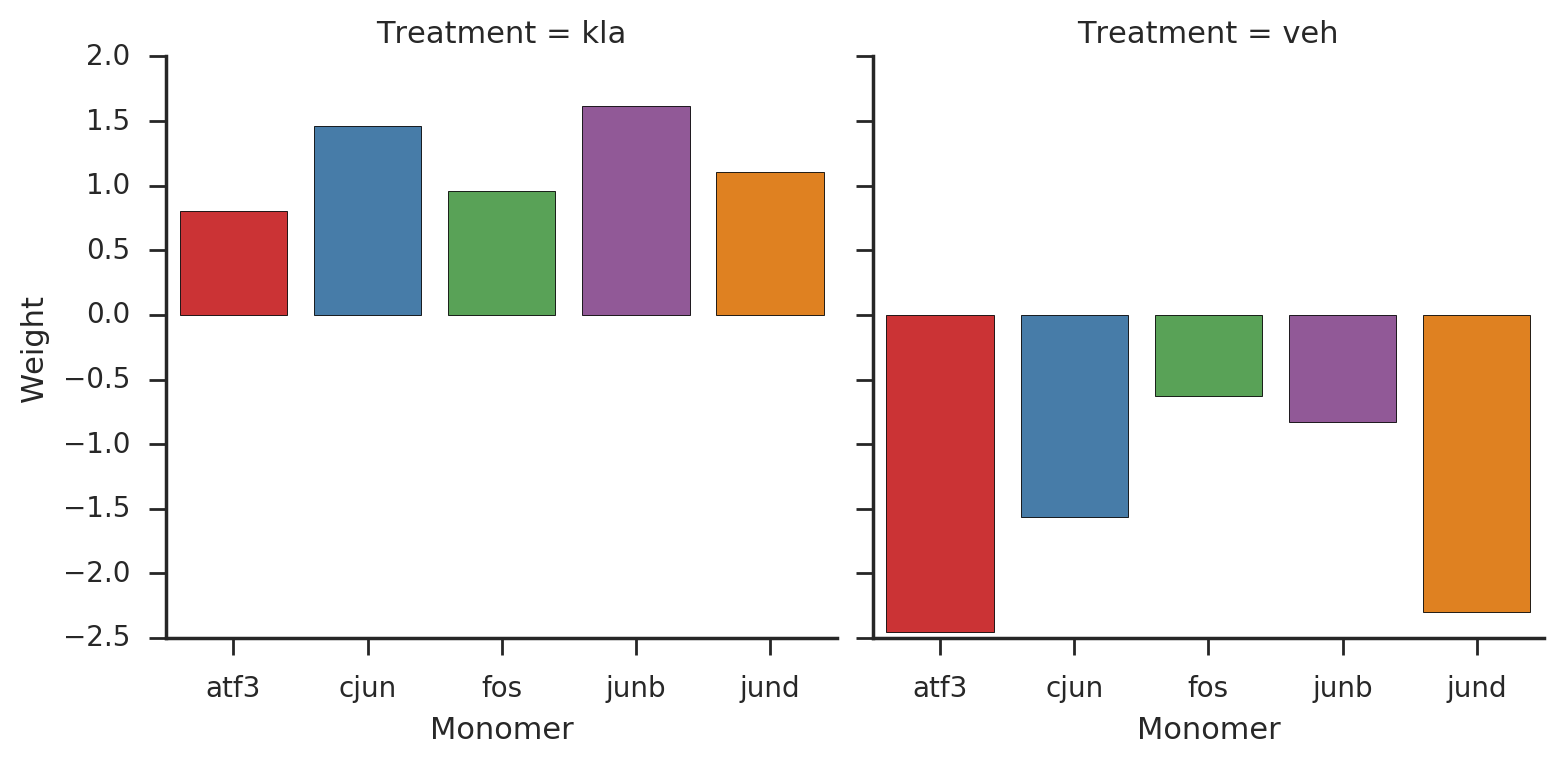

In [768]:
with sns.axes_style('ticks'):
    weights = coefficients_zscore_background_frame.ix['rel']
    monomers = [x.split('_')[0] for x in weights.index.values]
    treatments = [x.split('_')[1] for x in weights.index.values]
    sns.factorplot(data = pd.DataFrame({'Weight':weights, 
                                 'Monomer':monomers,
                                 'Treatment':treatments}),
                   kind='bar',
                   x='Monomer', 
                   y='Weight', 
                   col='Treatment')

## Correlation with Tag Count

atf3 veh


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.449376701709 (44290, 196) 44290


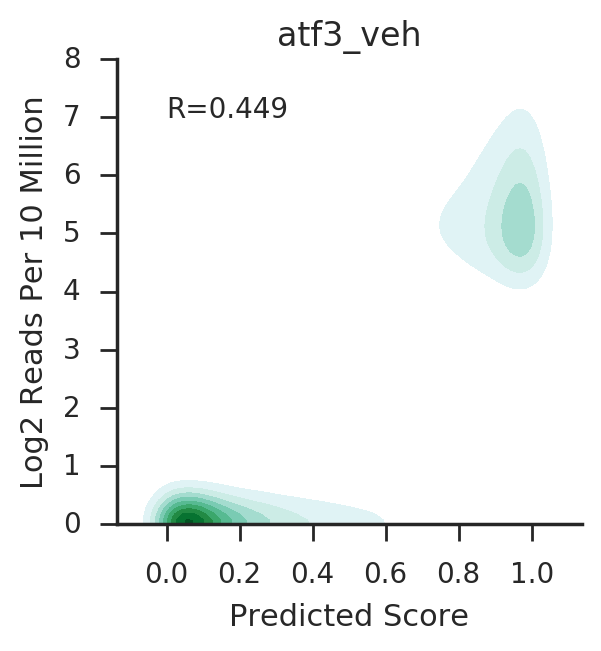

cjun veh
0.563571196433 (25452, 196) 25452


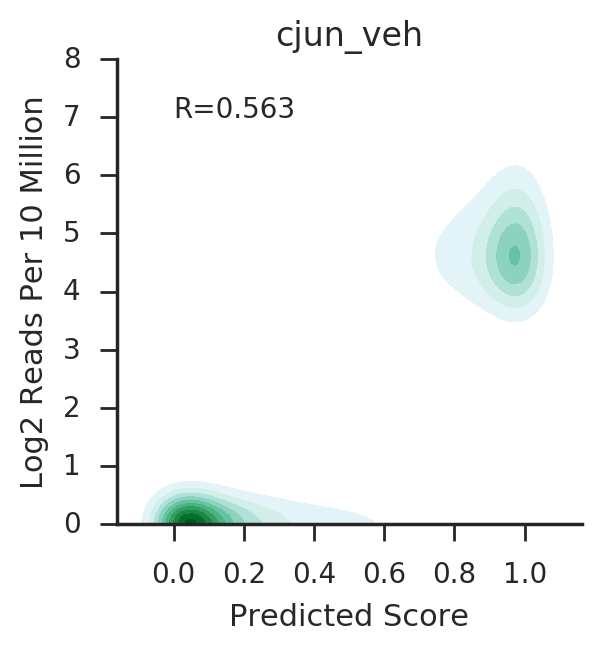

fos veh
0.492123085474 (3996, 196) 3996


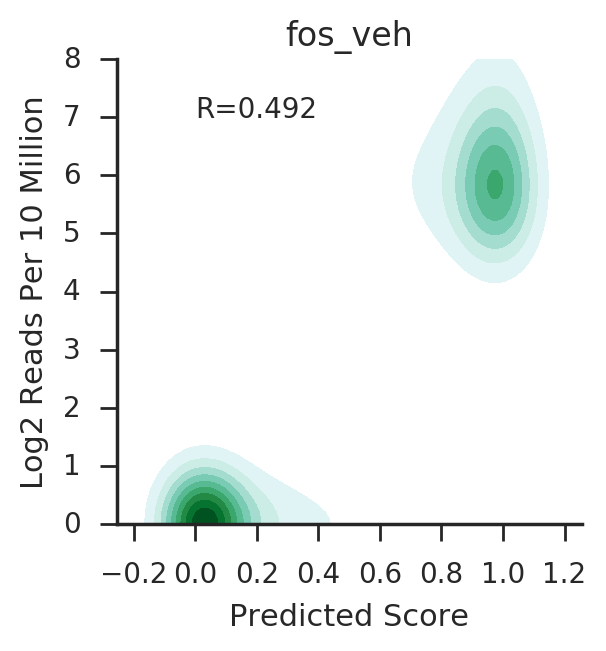

junb veh
0.475162253901 (992, 196) 992


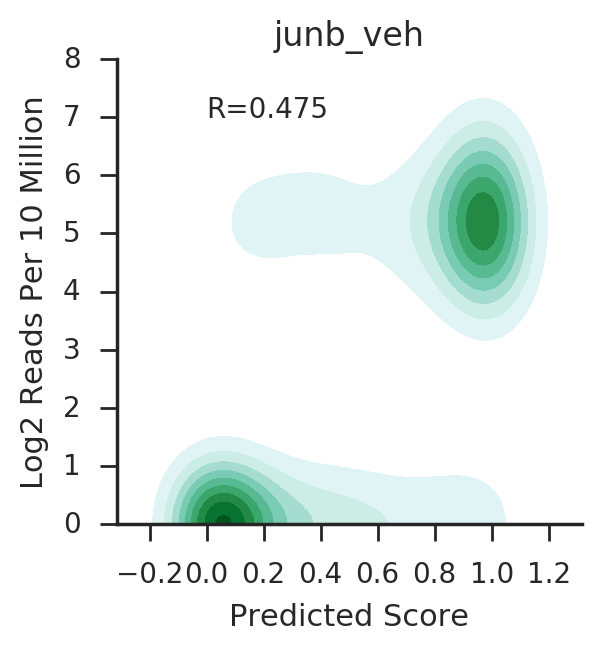

jund veh
0.517018723519 (36282, 196) 36282


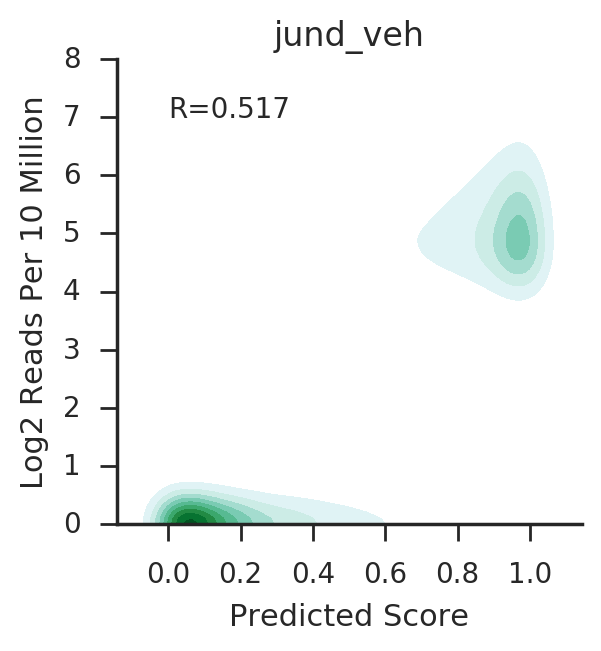

atf3 kla
0.430697093769 (69712, 196) 69712


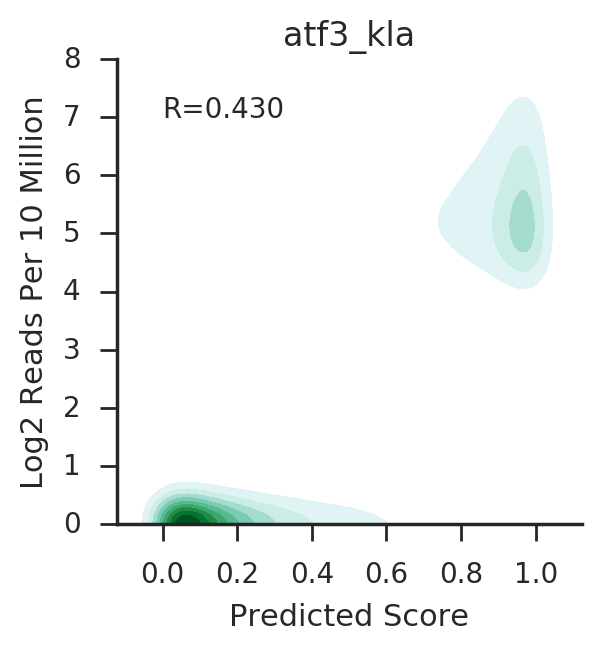

cjun kla
0.553019843689 (32430, 196) 32430


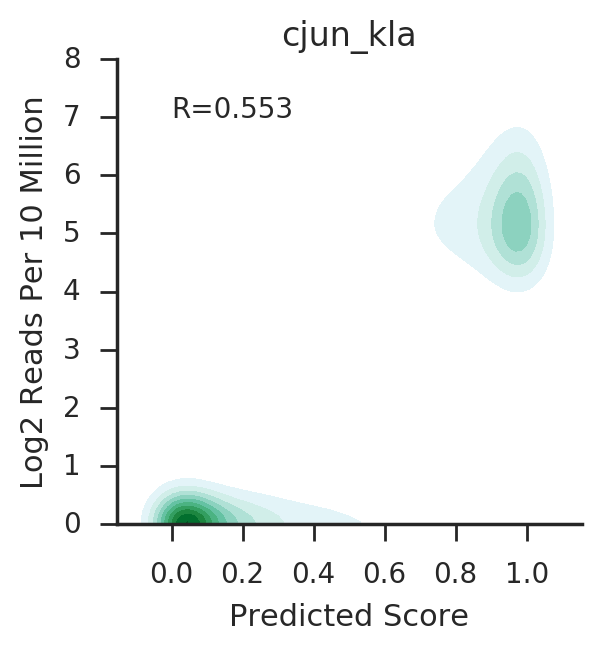

fos kla
0.547219976809 (38510, 196) 38510


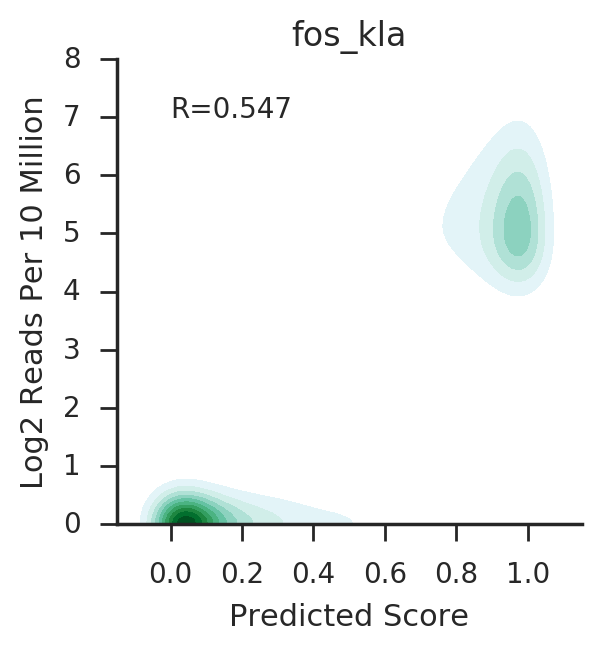

junb kla
0.525284654239 (28272, 196) 28272


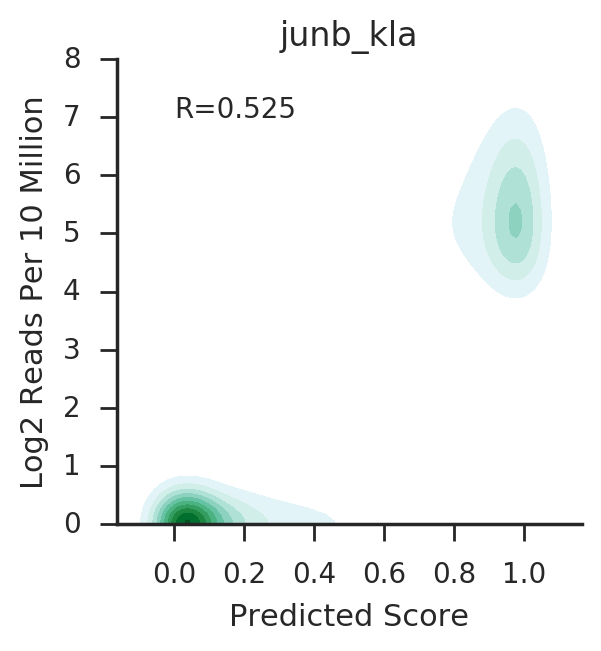

jund kla
0.484143840304 (60244, 196) 60244


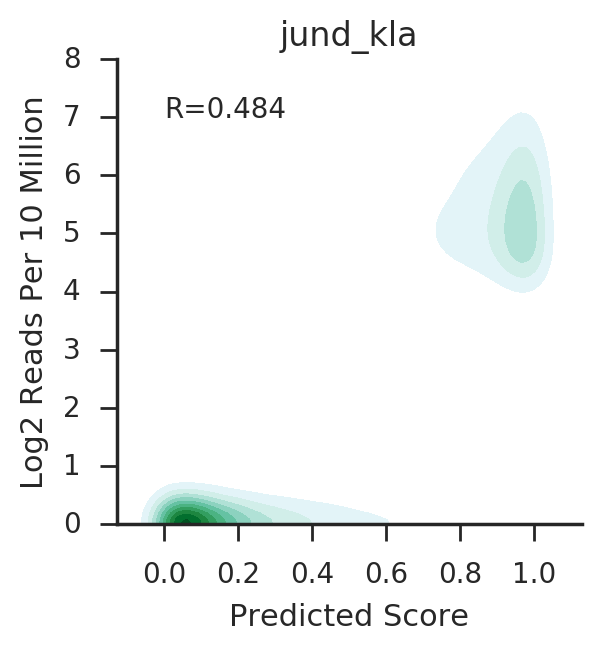

In [754]:
strain = 'c57bl6'
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        print(monomer, treatment)
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) >= 100:

            # calculate probabilities using averaged weights
            weights = factor_meanCoeff_background_dict[monomer + '_' + treatment]
            intercept = factor_meanIntercept_background_dict[monomer + '_' + treatment]
            scores = np.dot(features, weights) + intercept
            probs = np.array([signmoid(x) for x in scores])

            # get real binding scores
            binding_scores = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(labels.index.values)][strain + '_' + monomer + '_' + treatment]
            binding_scores = np.concatenate([binding_scores, np.array([0.0] * len(background_indices))])
            pearson, pval = scipy.stats.pearsonr(scores, binding_scores)
            print(pearson, features.shape, len(binding_scores))
            with sns.axes_style('ticks'):
                fig = plt.figure(figsize=(3,3))
#                 plt.scatter(probs, np.log2(binding_scores + 1), 
#                             marker = '.',
#                             edgecolor='None',
#                             s=1)
                sns.kdeplot(probs, np.log2(binding_scores + 1), 
                            shade=True,
                            shade_lowest = False)
                
                plt.xlabel('Predicted Score')
                plt.ylabel('Log2 Reads Per 10 Million')
                plt.annotate('R='+str(pearson)[:5], xy = (0,7), size=10)
                sns.despine()
#                 plt.xlim(-0.1,1.1)
                plt.ylim(0,8)
                plt.title(monomer + '_' + treatment)
                ax = plt.gca()
                x0,x1 = ax.get_xlim()
                y0,y1 = ax.get_ylim()
                ax.set_aspect(abs(x1-x0)/abs(y1-y0))
                plt.show()

## Looking at PU.1

### Combined Classifier and Subcomponents

In [1077]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

In [1099]:
auc_list = []
monomer_list = []
treatment_list = []
feature_list = []
# for monomers using all motifs
strain = 'c57bl6'
factor_coeff_affinity_ldtf_dict = {}
factor_coeff_count_ldtf_dict = {}
for treatment in ['veh']:
    for monomer in ['atf3', 'cjun', 'jund', 'pu1', 'cebpa']:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
#         target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        target_features = normed_motif_frame[normed_motif_frame.index.isin(target_indices)]
#         background_indices = motif_score_background_frame.index.values     # select subset of background indices to use
        background_indices = normed_motif_background_frame.index.values 
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
#         background_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]
        background_features = normed_motif_background_frame[normed_motif_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        all_aucs = []
        all_count_aucs = []
        all_affinity_aucs = []
        all_count_coefficients = []
        all_affinity_coefficients = []
        all_precisions = []
        for i in range(numIterations):
            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            scaler = preprocessing.StandardScaler()
            training_combined_standardized_features = pd.DataFrame(scaler.fit_transform(training_combined_features[['Affinity', 'Count']]))
            training_combined_standardized_features.index = training_combined_features.index.values
            training_combined_standardized_features.columns = training_combined_features.columns.values
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_standardized_features, training_labels)
            print('affinity, count', combined_classifier.coef_.flatten())

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            scaler = preprocessing.StandardScaler()
            test_combined_standardized_features = pd.DataFrame(scaler.fit_transform(test_combined_features[['Affinity', 'Count']]))
            test_combined_standardized_features.index = test_combined_features.index.values
            test_combined_standardized_features.columns = test_combined_features.columns.values
            probas = combined_classifier.predict_proba(test_combined_features)
            affinity_probas = affinity_classifier.predict_proba(test_affinity_features)
            count_probas = count_classifier.predict_proba(test_count_features)
            
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            affinity_roc_auc = sklearn.metrics.roc_auc_score(test_labels, affinity_probas[:, 1], average = None)
            count_roc_auc = sklearn.metrics.roc_auc_score(test_labels, count_probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_count_aucs.append(count_roc_auc)
            all_affinity_aucs.append(affinity_roc_auc)
            all_precisions.append(current_precision)
            
            affinity_coefficients = affinity_classifier.coef_.flatten()
            all_affinity_coefficients.append(affinity_coefficients)
            count_coefficients = count_classifier.coef_.flatten()
            all_count_coefficients.append(count_coefficients)
                
            auc_list = auc_list + [current_roc_auc, count_roc_auc, affinity_roc_auc]
            monomer_list = monomer_list + 3*[monomer]
            treatment_list = treatment_list + 3*[treatment]
            feature_list = feature_list + ['Both', 'Count', 'Affinity']
            
        mean_coefficients = np.mean(all_coefficients, axis=0)
        factor_coeff_affinity_ldtf_dict[monomer + '_' + treatment] = np.mean(all_affinity_coefficients, axis = 0)
        factor_coeff_count_ldtf_dict[monomer + '_' + treatment] = np.mean(all_count_coefficients, axis = 0)
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.mean(all_affinity_aucs), np.mean(all_count_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
             )
        

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


affinity, count [ 2.66395263  1.65050774]
affinity, count [ 2.63186115  1.68124008]
affinity, count [ 2.58700724  1.63887271]
affinity, count [ 2.65867975  1.62096934]
affinity, count [ 2.57074473  1.64714246]
atf3_veh roc: 0.949721000088 0.9229573631 0.862879590025 precision: 0.950830109424 2.40425185317e-06
affinity, count [ 2.86059879  1.62042051]
affinity, count [ 2.84764701  1.61671976]
affinity, count [ 2.79539403  1.55972718]
affinity, count [ 2.72527002  1.59051235]
affinity, count [ 2.77288757  1.61541846]
cjun_veh roc: 0.951400643982 0.929000192626 0.854855563911 precision: 0.952442206628 1.32330283649e-06
affinity, count [ 2.67323529  1.5891058 ]
affinity, count [ 2.73907402  1.57848506]
affinity, count [ 2.64857058  1.5501842 ]
affinity, count [ 2.66758812  1.58429418]
affinity, count [ 2.6944547   1.53456636]
jund_veh roc: 0.950605110718 0.926814465936 0.864053545372 precision: 0.951941319643 7.59138248891e-07
affinity, count [ 2.55106666  2.06342149]
affinity, count [ 2.5

### Summed Scores

In [1100]:
# for monomers using all motifs
strain = 'c57bl6'
factor_coeff_summedScore_ldtf_dict = {}
for treatment in ['veh']:
    for monomer in ['atf3', 'cjun', 'jund', 'pu1', 'cebpa']:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = normed_summedScore_frame[normed_summedScore_frame.index.isin(target_indices)]
        background_indices = normed_summedScore_background_frame.index.values     # select subset of background indices to use
        
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = normed_summedScore_background_frame[normed_summedScore_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        all_aucs = []
        all_coefficients = []
        all_probs = None
        all_precisions = []
        all_intercepts = []
        for i in range(numIterations):

            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            probas = affinity_classifier.predict_proba(test_affinity_features)
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            current_coefficients = affinity_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)
            auc_list.append(current_roc_auc)
            monomer_list.append(monomer)
            treatment_list.append(treatment)
            feature_list.append('Summed Affinity')
                
        mean_coefficients = np.mean(all_coefficients, axis=0)
        factor_coeff_summedScore_ldtf_dict[monomer + '_' + treatment] = mean_coefficients
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )
        

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.996193869655 4.8987464887e-08 precision: 0.997102579385 1.57633653129e-08 numTestPositives: 11073
cjun_veh roc: 0.996946971813 3.02125879491e-08 precision: 0.997688770647 9.89623455546e-09 numTestPositives: 6363
jund_veh roc: 0.997058031679 3.18087173412e-08 precision: 0.997730041296 8.33871538095e-09 numTestPositives: 9071
pu1_veh roc: 0.996081289587 4.16714185862e-08 precision: 0.996771272233 2.10578420658e-08 numTestPositives: 20067
cebpa_veh roc: 0.997788485288 7.63678121453e-08 precision: 0.99814824695 4.02242829084e-08 numTestPositives: 5876


(0.5, 1)

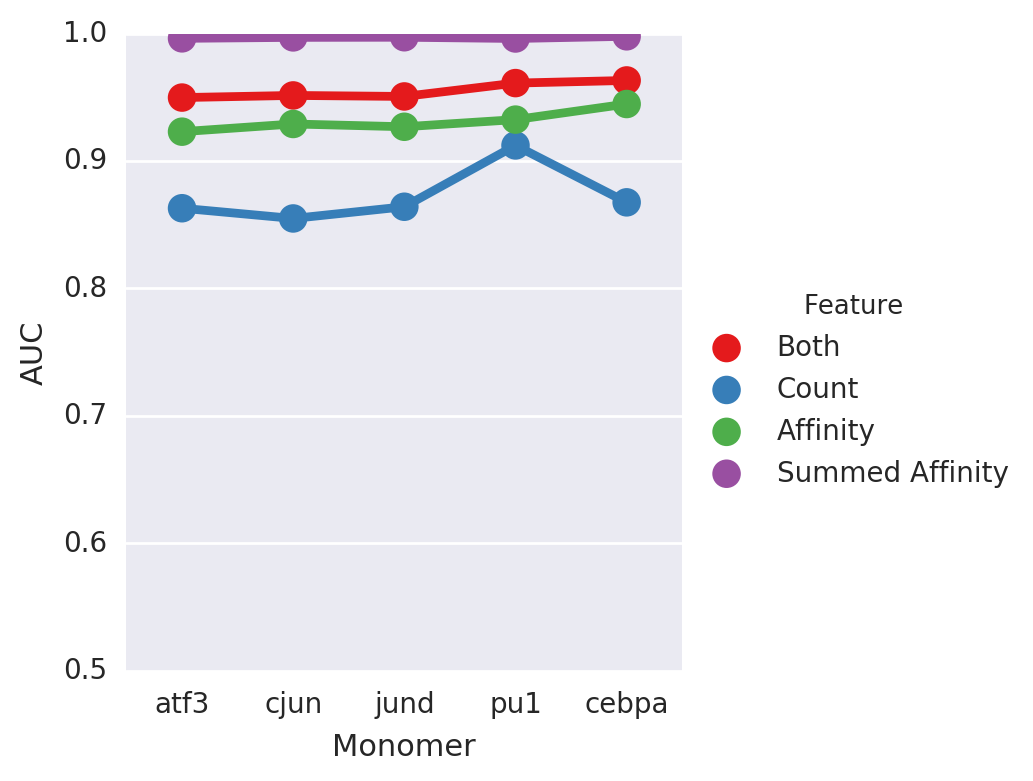

In [1101]:
performance_frame = pd.DataFrame({'AUC':auc_list,
                                  'Monomer':monomer_list,
                                  'Treatment':treatment_list,
                                  'Feature':feature_list})
sns.factorplot(data=performance_frame, 
               x='Monomer', 
               y= 'AUC', 
#                col='Treatment', 
               hue='Feature')
plt.ylim(0.5,1)

### Visualize Coefficients

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


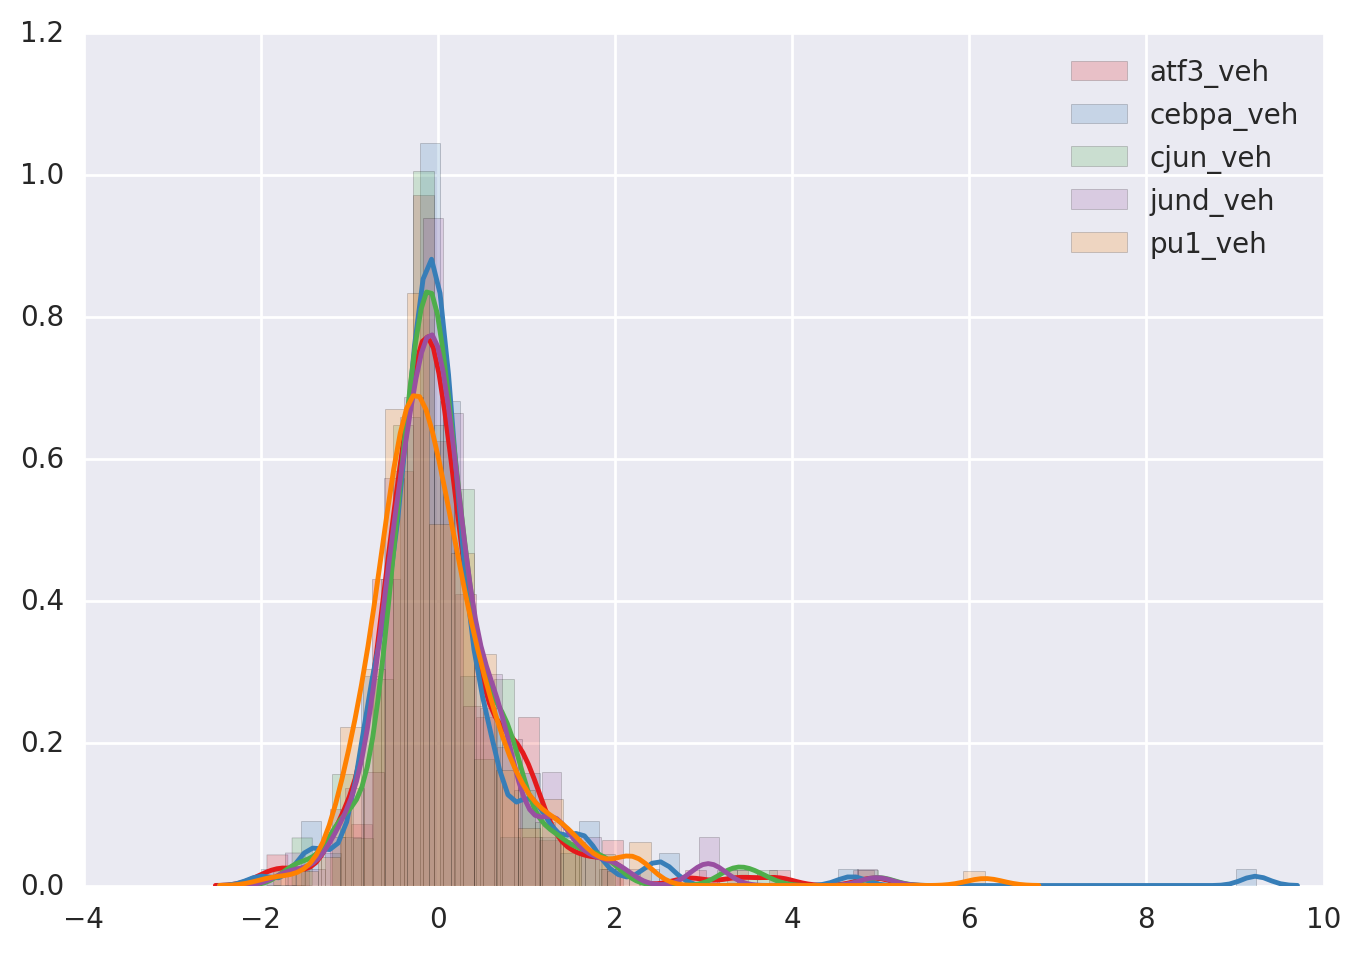

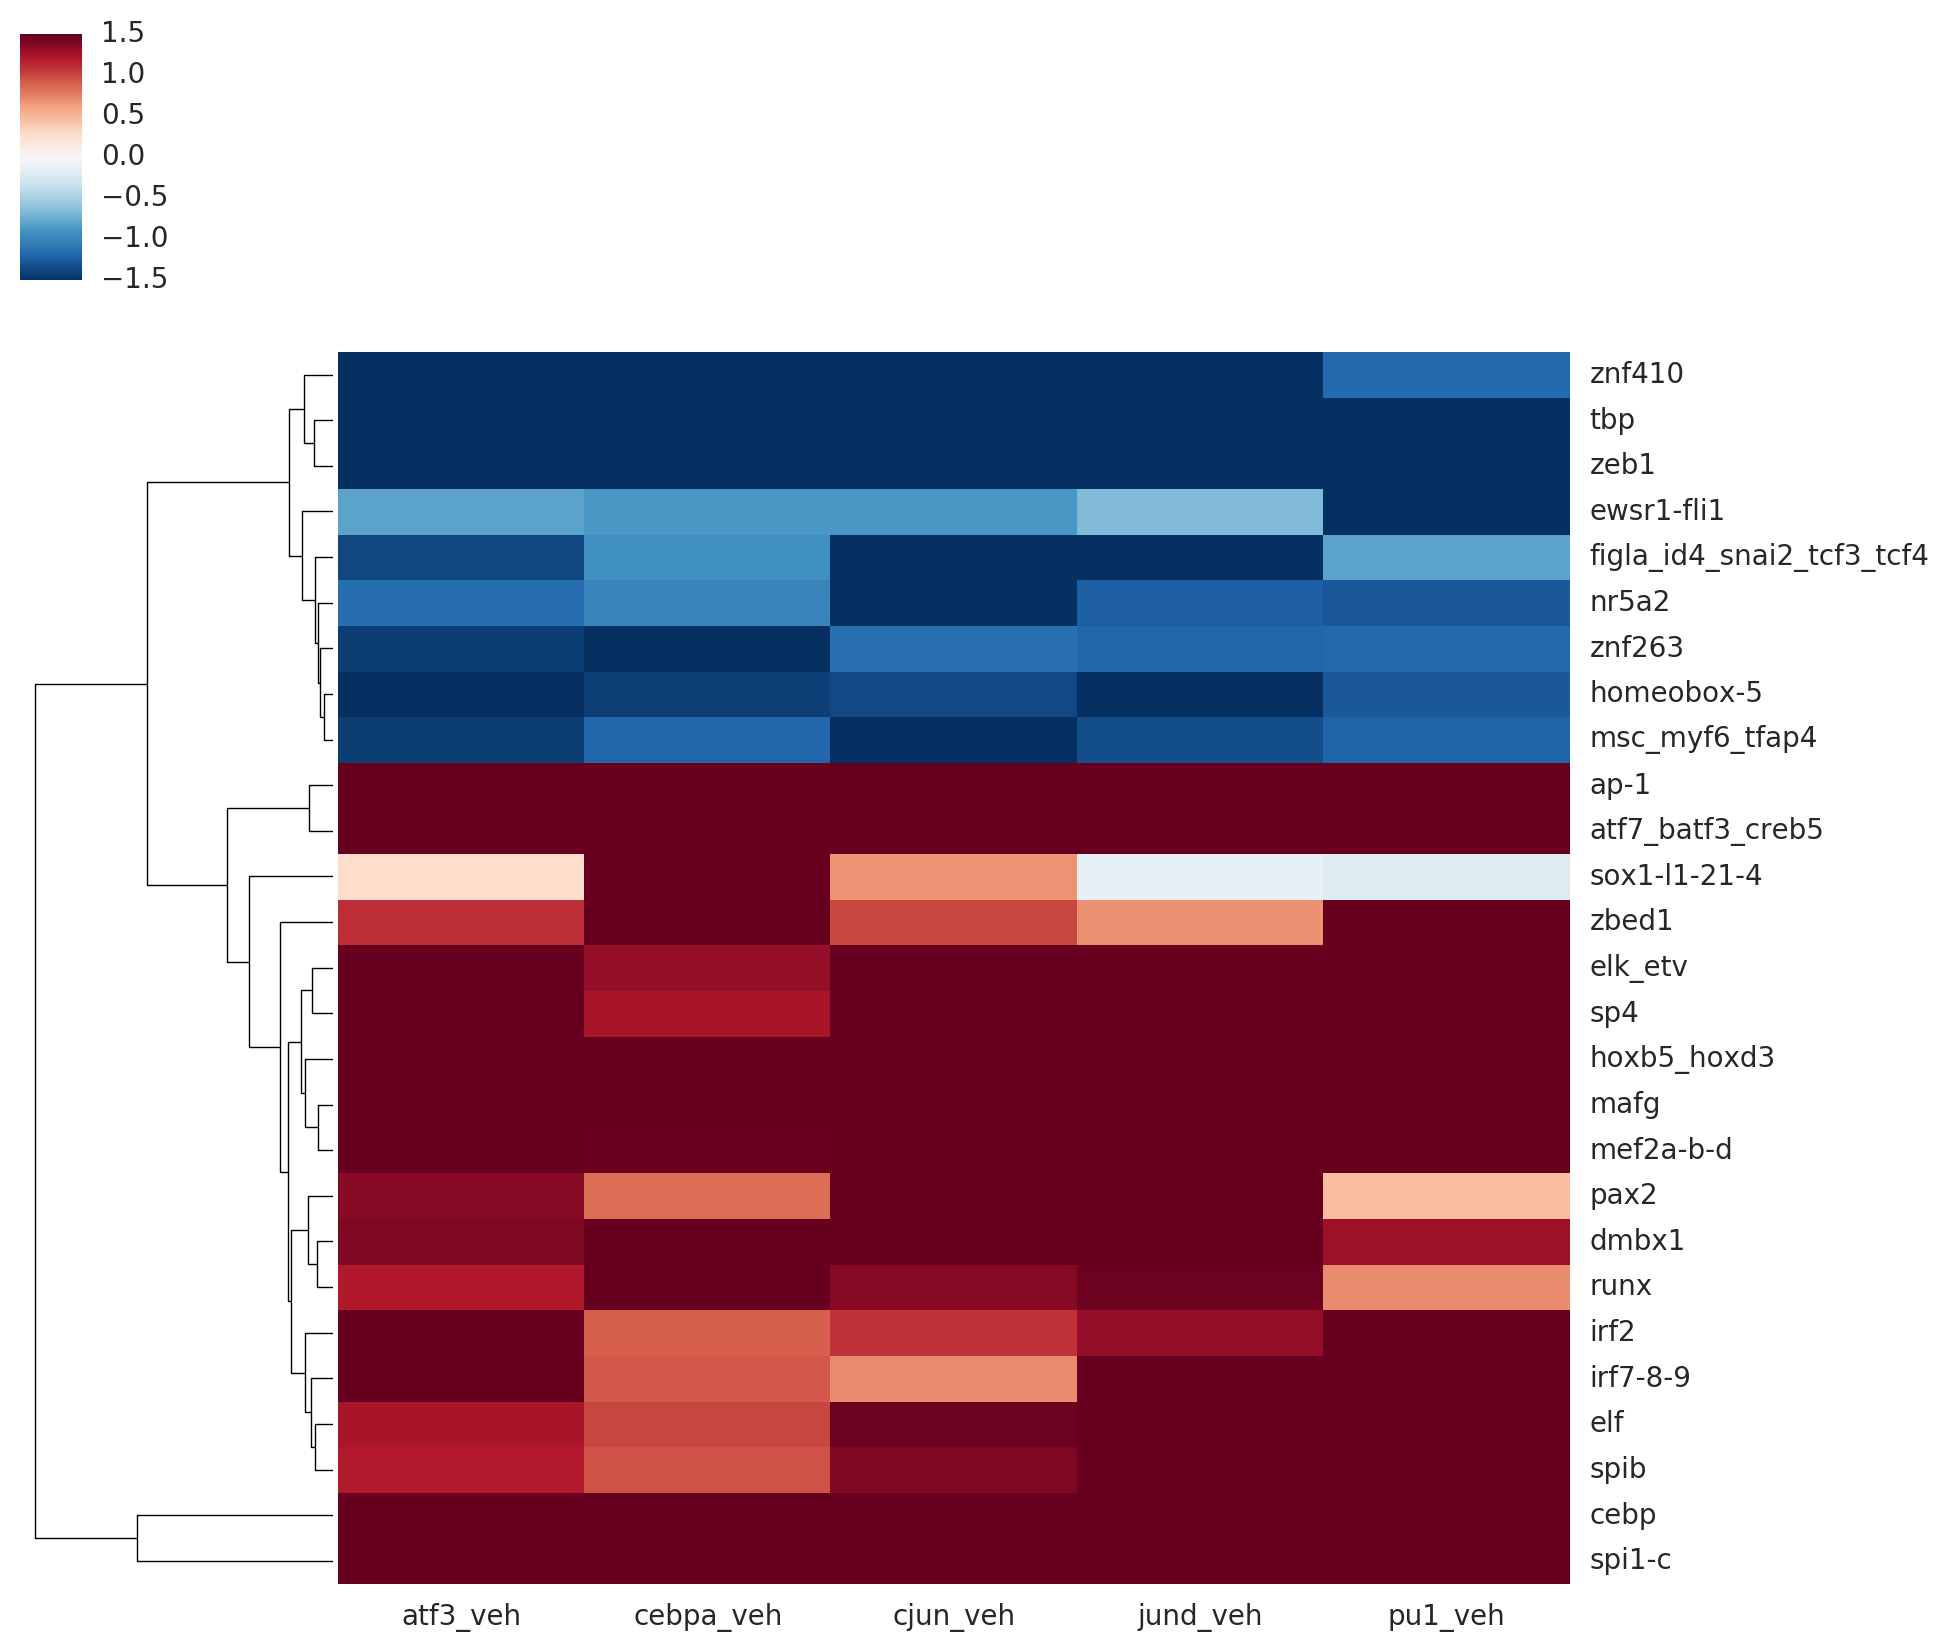

In [1102]:
coefficients_affinity_ldtf_frame = pd.DataFrame(factor_coeff_affinity_ldtf_dict)
coefficients_affinity_ldtf_frame.index = standardized_motif_frame.columns.values
for col in coefficients_affinity_ldtf_frame.columns.values:
    sns.distplot(coefficients_affinity_ldtf_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_ldtf_affinity_frame = coefficients_affinity_ldtf_frame[[]]
for col in coefficients_affinity_ldtf_frame:
    coefficients_zscore_ldtf_affinity_frame[col] = scipy.stats.mstats.zscore(coefficients_affinity_ldtf_frame[col].values)

coefficients_zscore_ldtf_affinity_frame.index = coefficients_affinity_ldtf_frame.index.values
coefficients_zscore_ldtf_affinity_frame.columns = coefficients_affinity_ldtf_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 1.5

for treatment in ['veh']:
    data = coefficients_zscore_ldtf_affinity_frame
    data = data[[x for x in coefficients_zscore_ldtf_affinity_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


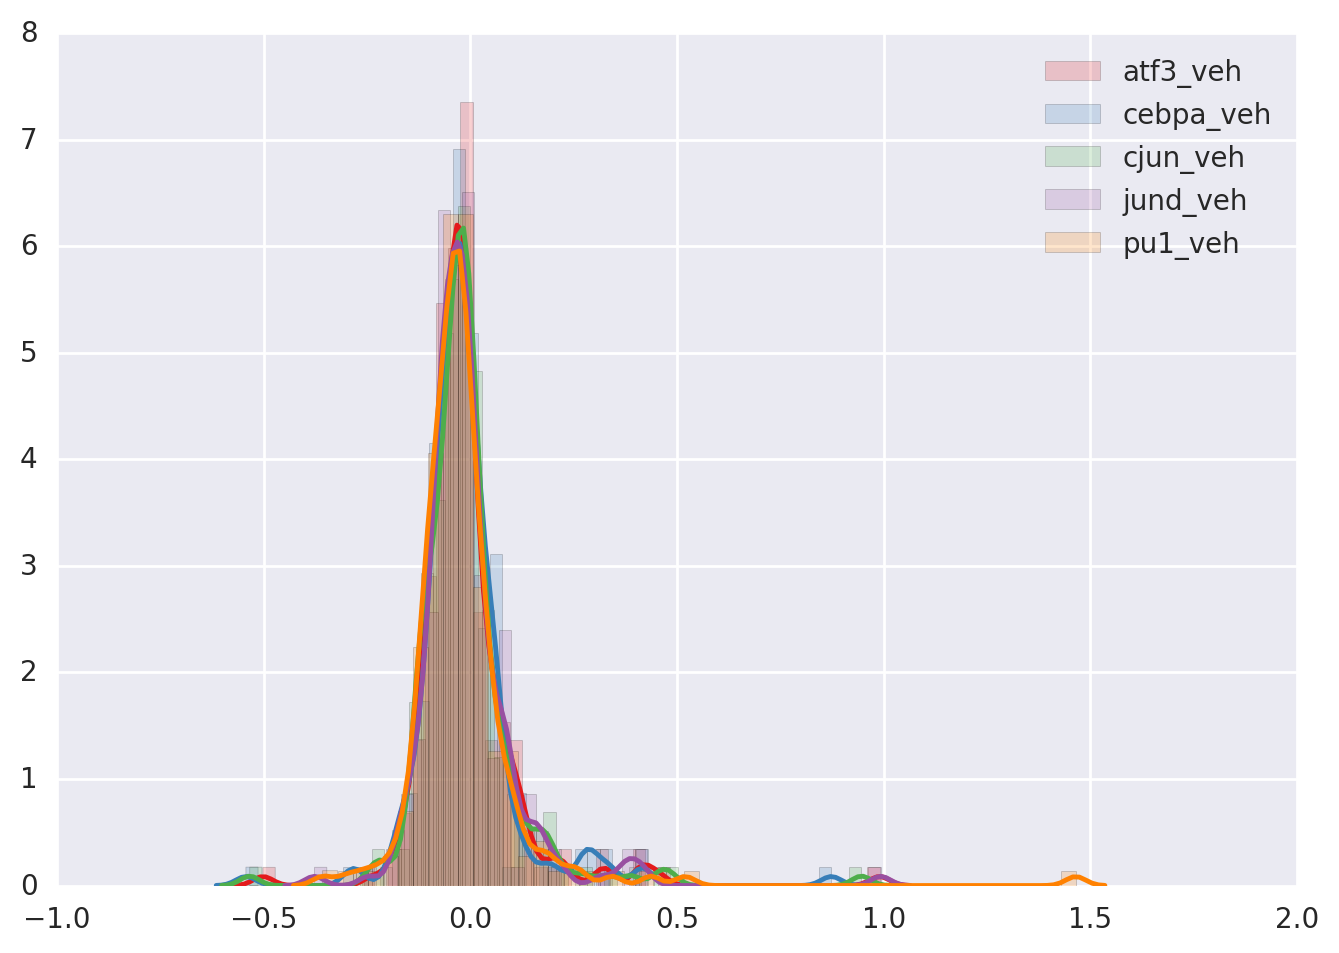

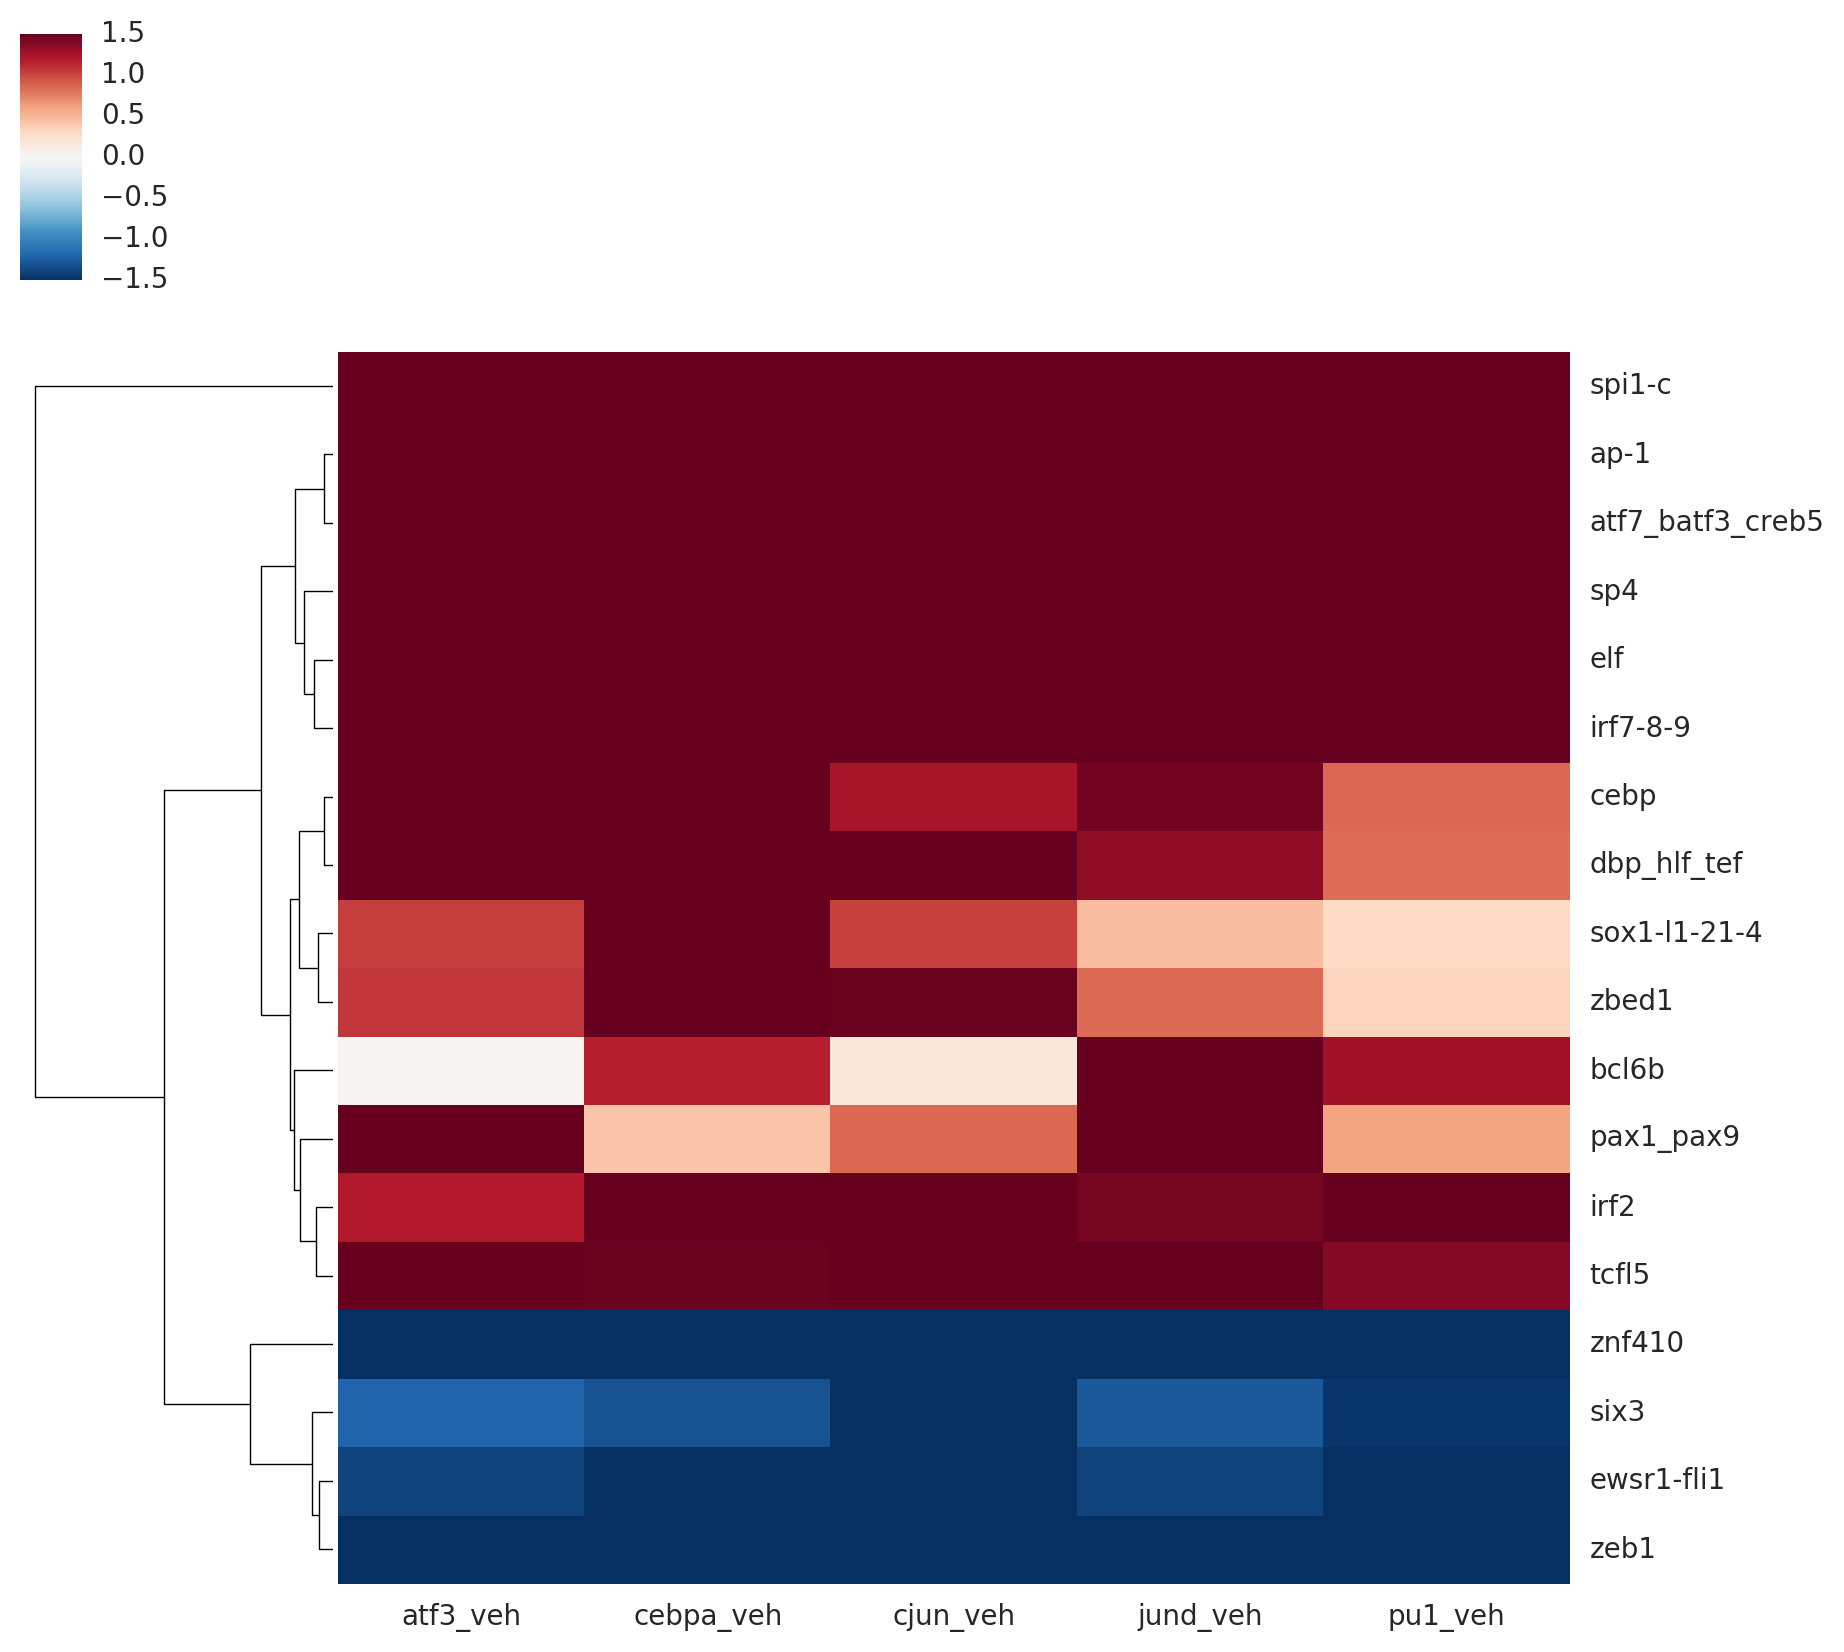

In [1103]:
coefficients_ldtf_counts_frame = pd.DataFrame(factor_coeff_count_ldtf_dict)
coefficients_ldtf_counts_frame.index = standardized_motif_frame.columns.values
for col in coefficients_ldtf_counts_frame.columns.values:
    sns.distplot(coefficients_ldtf_counts_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_ldtf_counts_frame = coefficients_ldtf_counts_frame[[]]
for col in coefficients_ldtf_counts_frame:
    coefficients_zscore_ldtf_counts_frame[col] = scipy.stats.mstats.zscore(coefficients_ldtf_counts_frame[col].values)

coefficients_zscore_ldtf_counts_frame.index = coefficients_ldtf_counts_frame.index.values
coefficients_zscore_ldtf_counts_frame.columns = coefficients_ldtf_counts_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 1.5

for treatment in ['veh']:
    data = coefficients_zscore_ldtf_counts_frame
    data = data[[x for x in coefficients_zscore_ldtf_counts_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


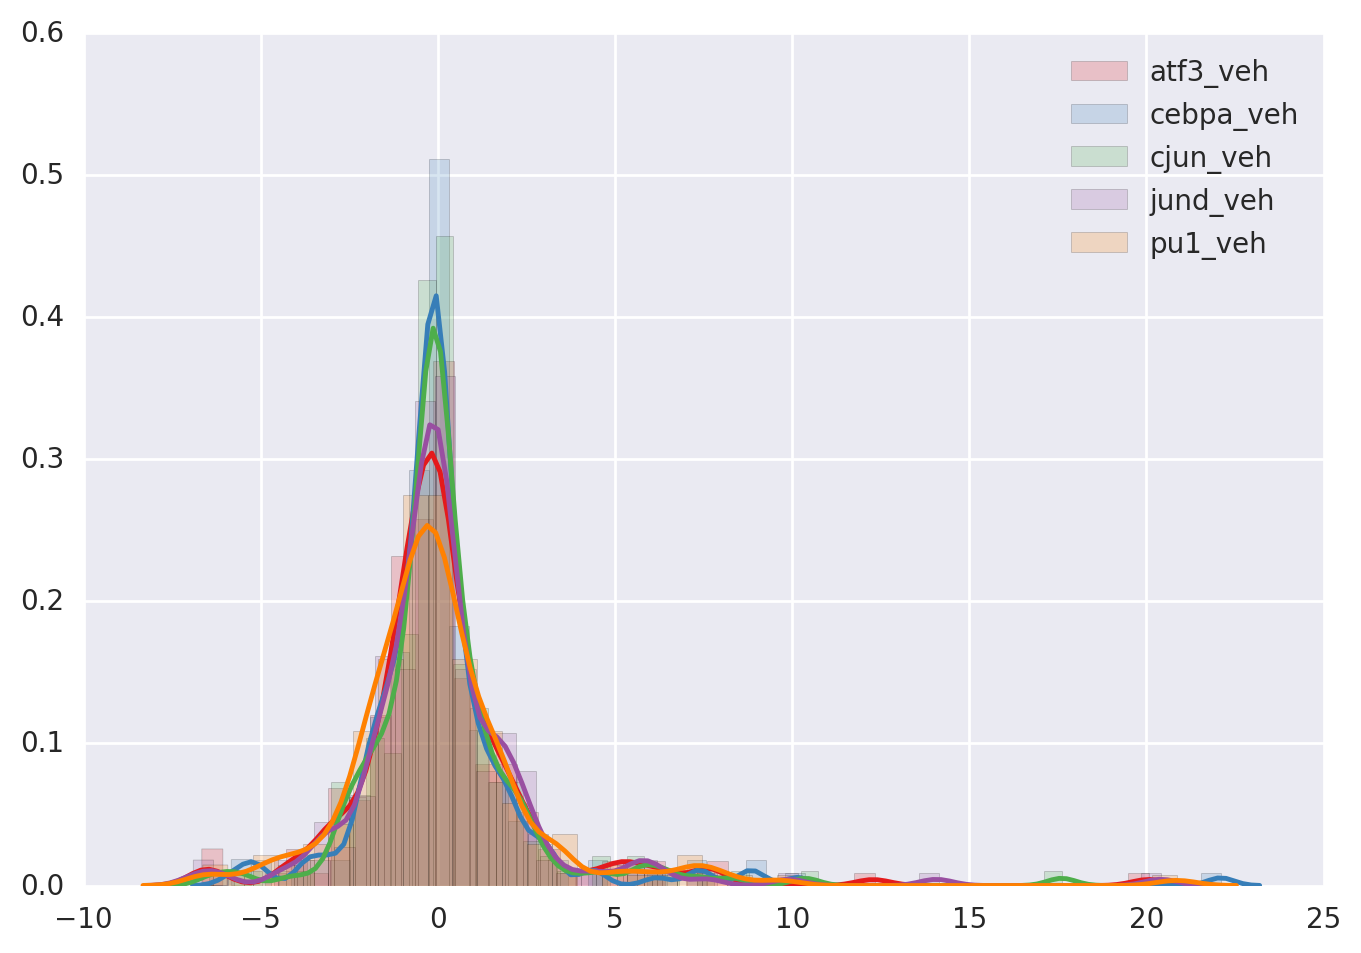

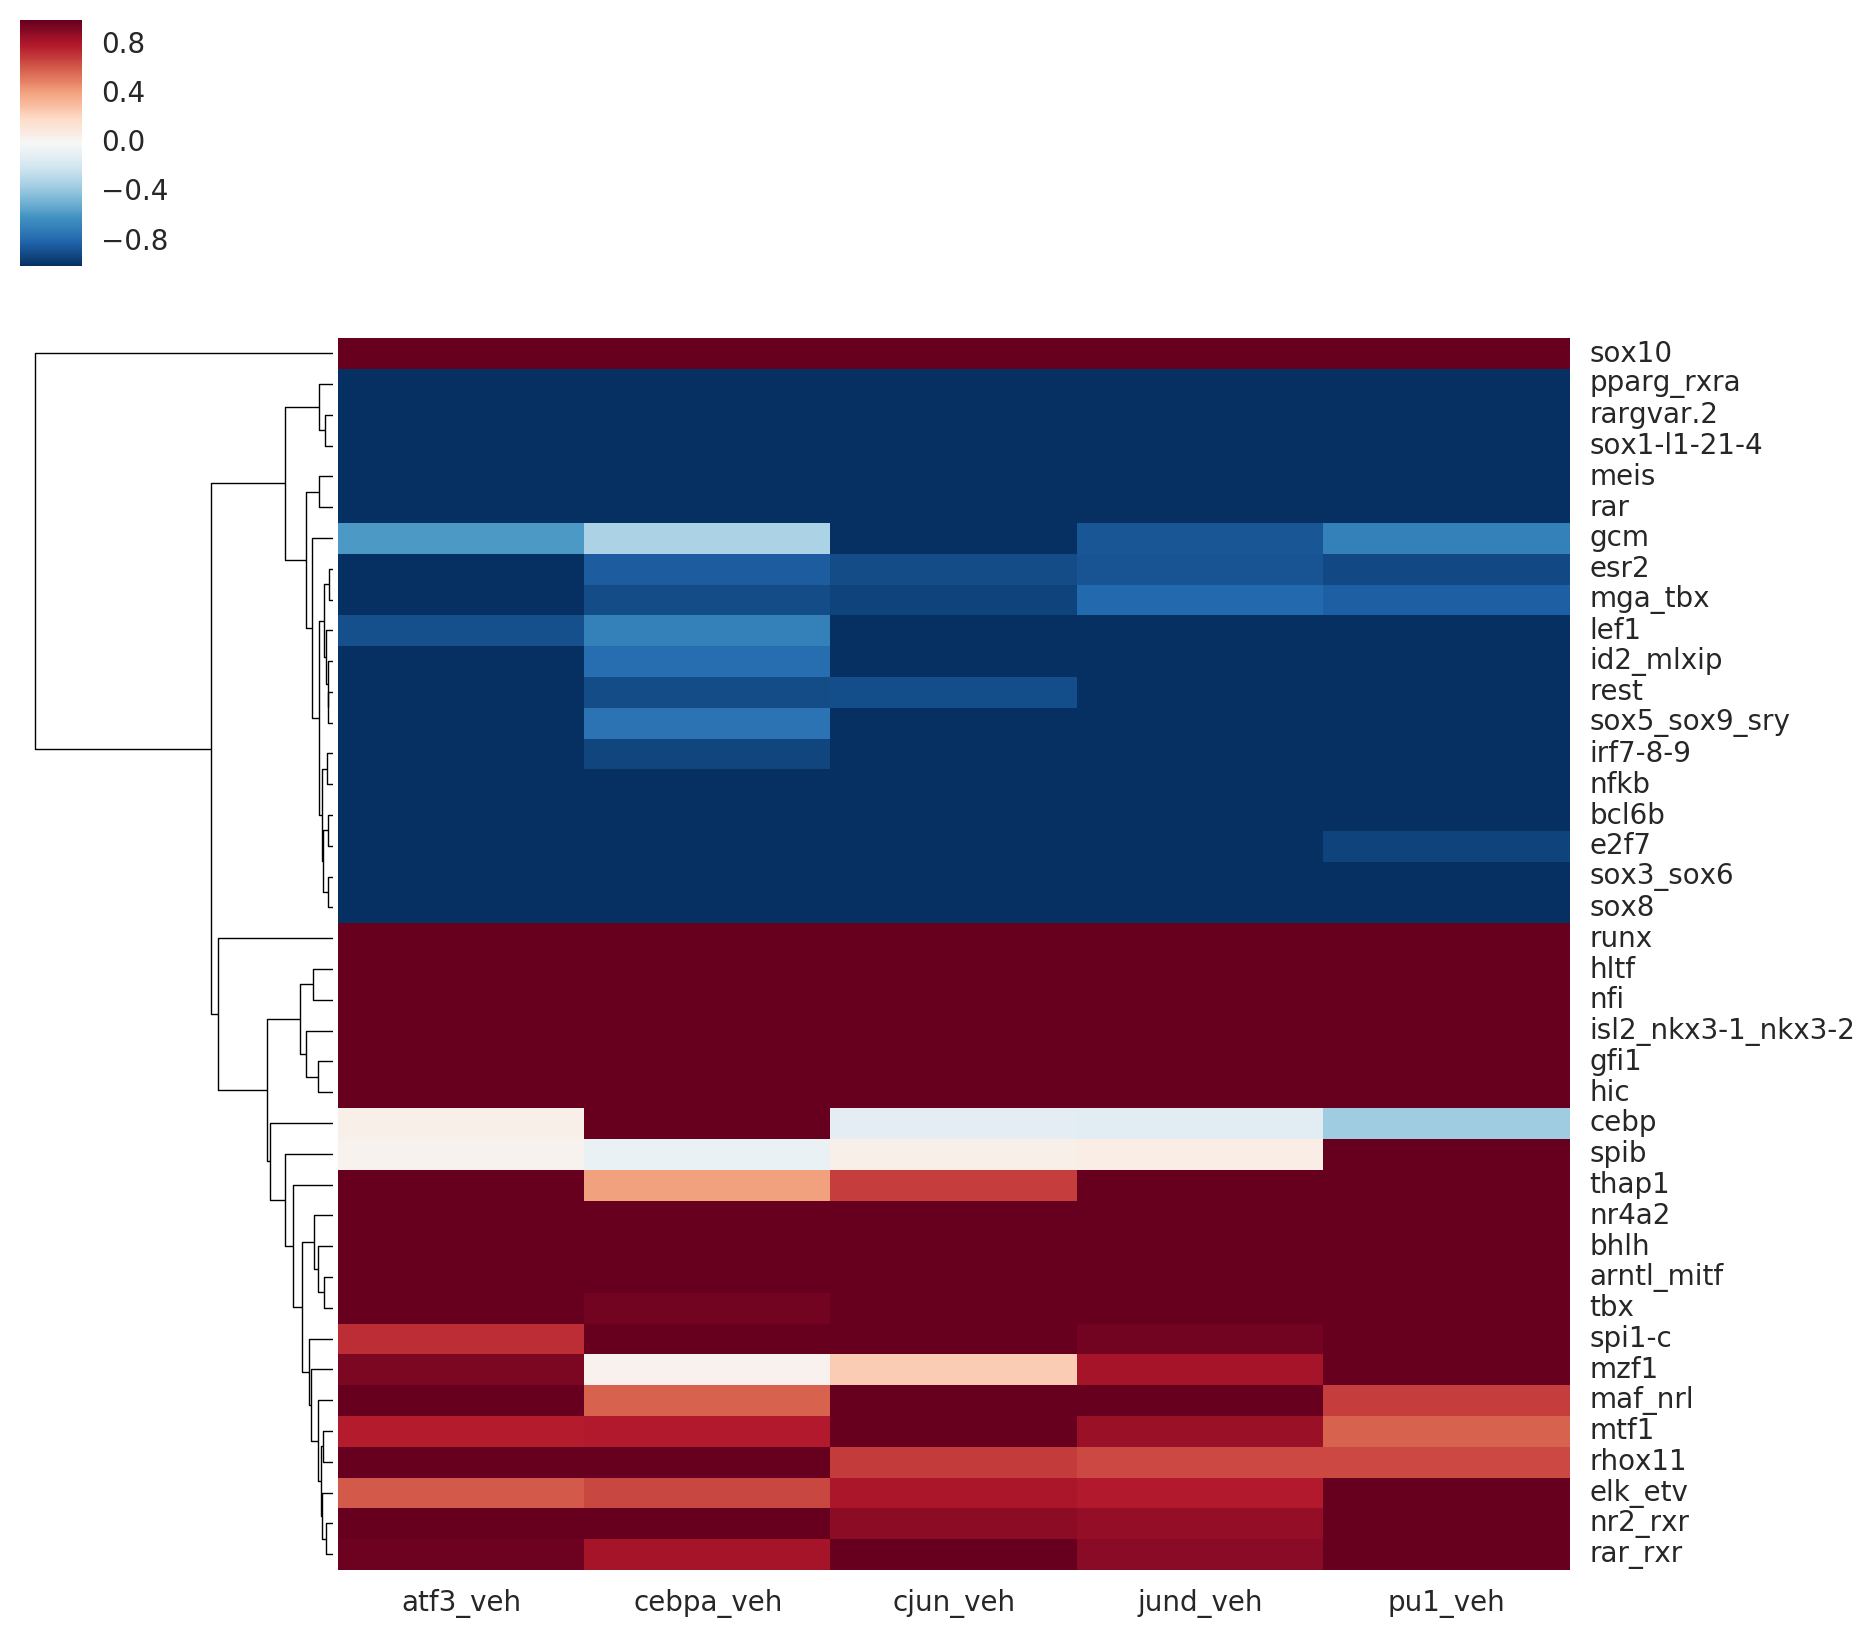

In [1104]:
coefficients_ldtf_summedScore_frame = pd.DataFrame(factor_coeff_summedScore_ldtf_dict)
coefficients_ldtf_summedScore_frame.index = normed_summedScore_frame.columns.values
for col in coefficients_ldtf_summedScore_frame.columns.values:
    sns.distplot(coefficients_ldtf_summedScore_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_ldtf_summedScore_frame = coefficients_ldtf_summedScore_frame[[]]
for col in coefficients_ldtf_summedScore_frame:
    coefficients_zscore_ldtf_summedScore_frame[col] = scipy.stats.mstats.zscore(coefficients_ldtf_summedScore_frame[col].values)

coefficients_zscore_ldtf_summedScore_frame.index = coefficients_ldtf_summedScore_frame.index.values
coefficients_zscore_ldtf_summedScore_frame.columns = coefficients_ldtf_summedScore_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 1.0

for treatment in ['veh']:
    data = coefficients_zscore_ldtf_summedScore_frame
    data = data[[x for x in coefficients_zscore_ldtf_summedScore_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );

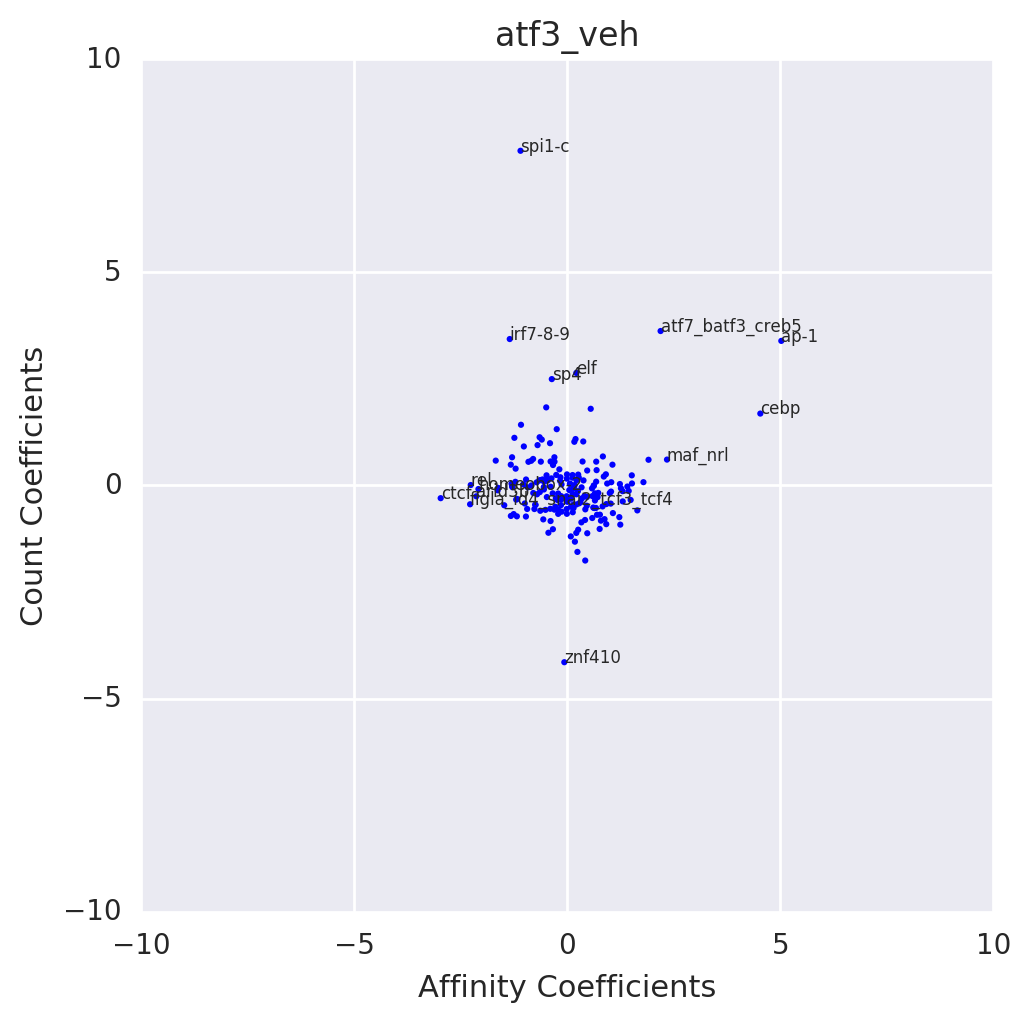

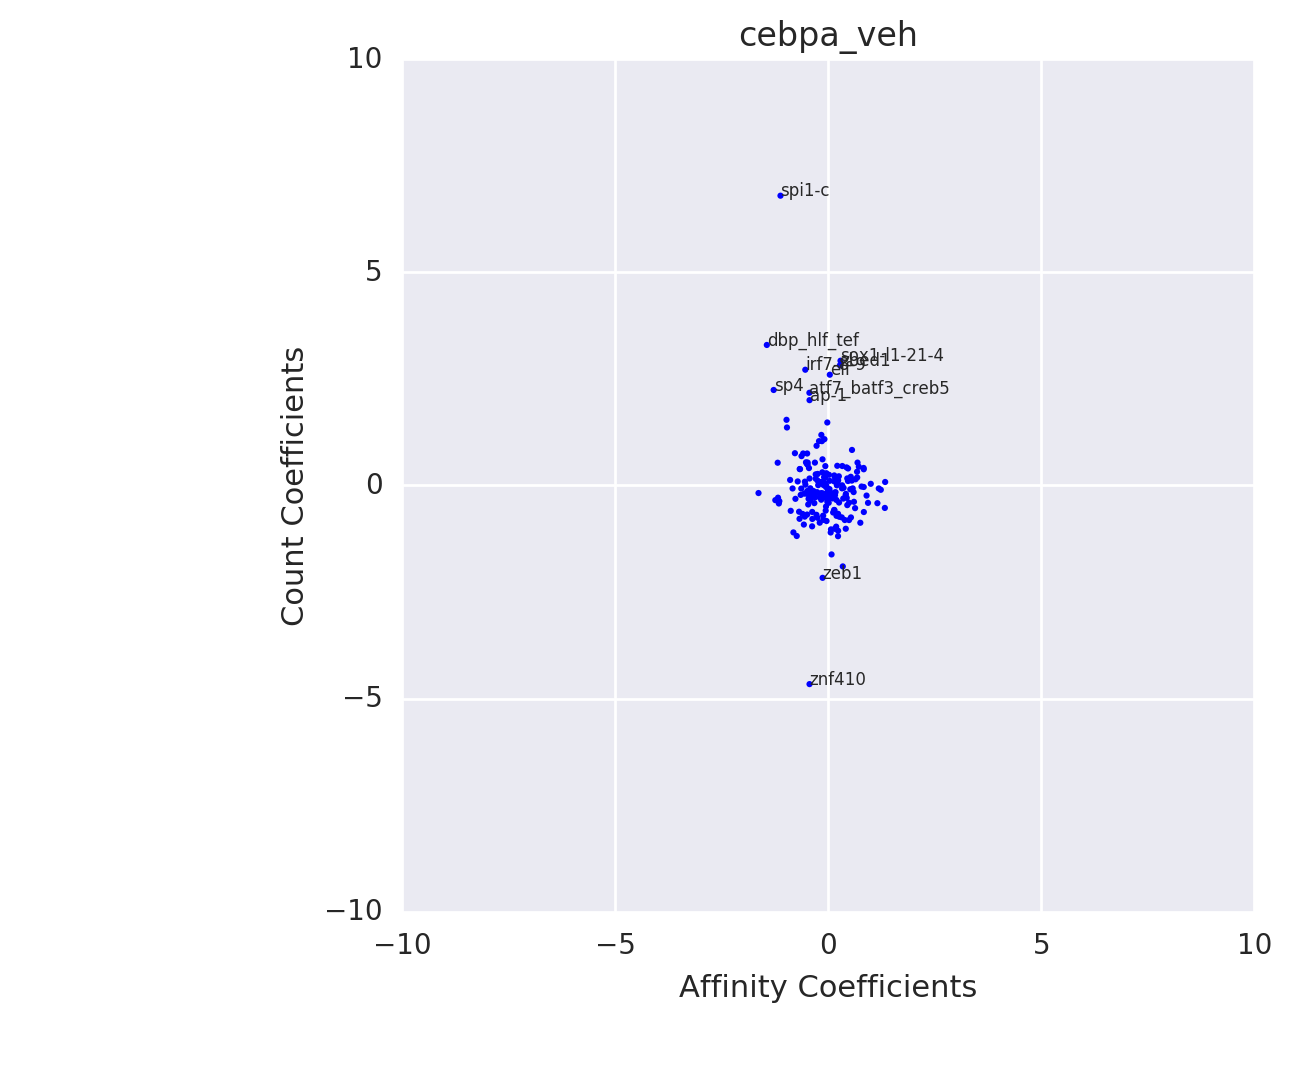

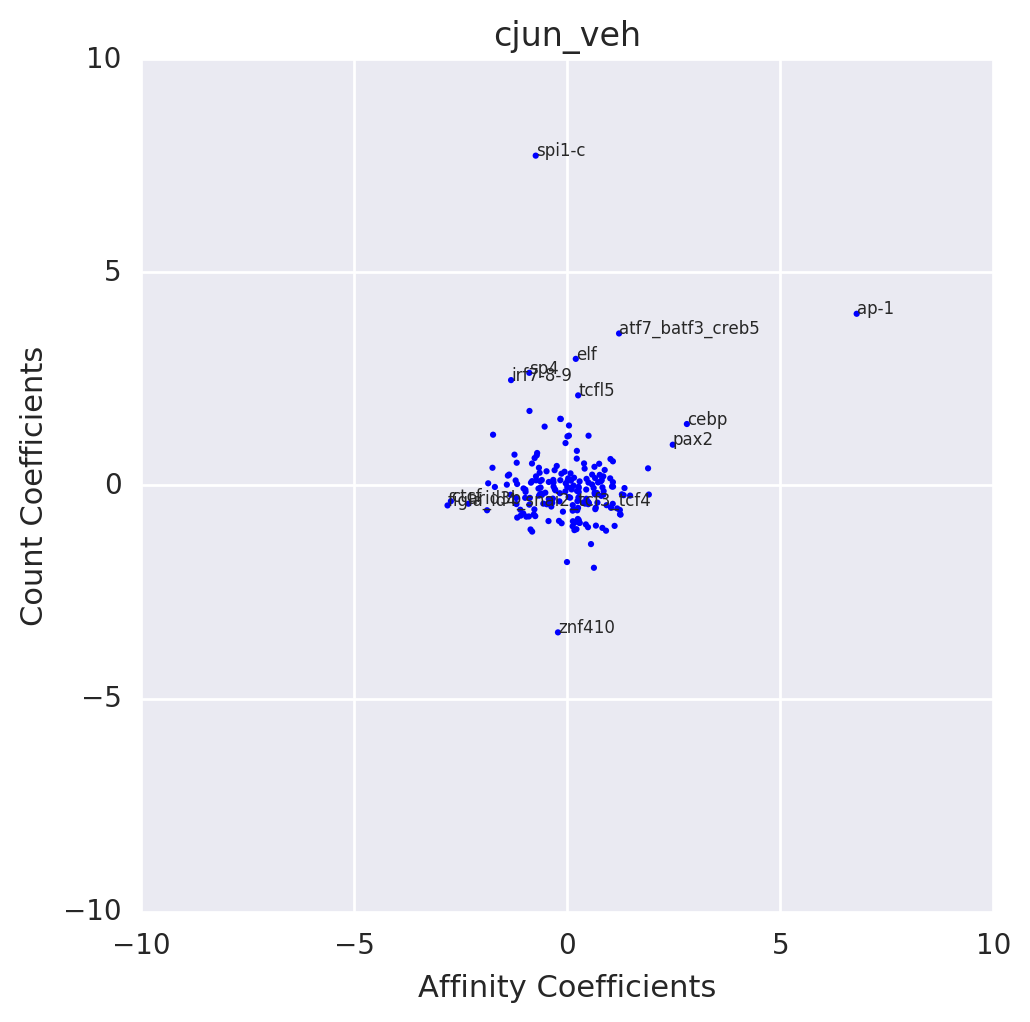

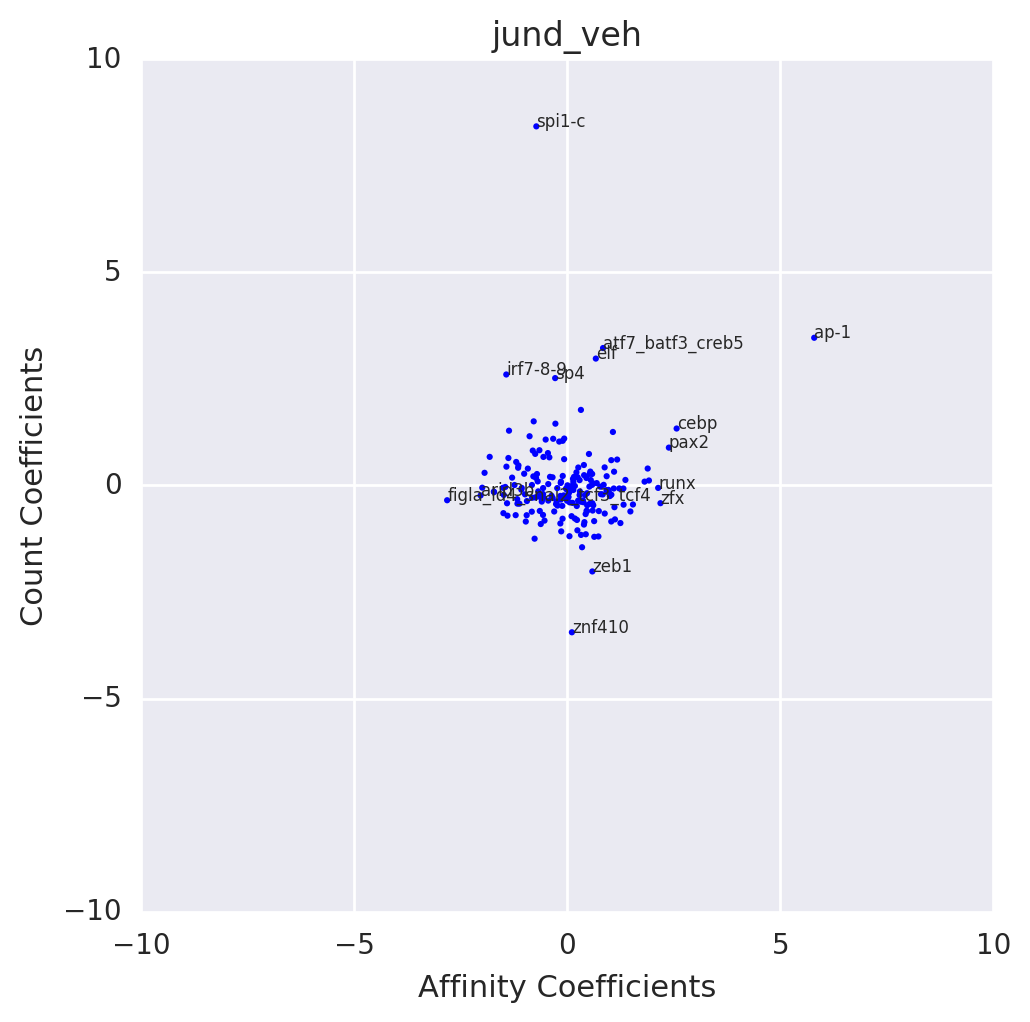

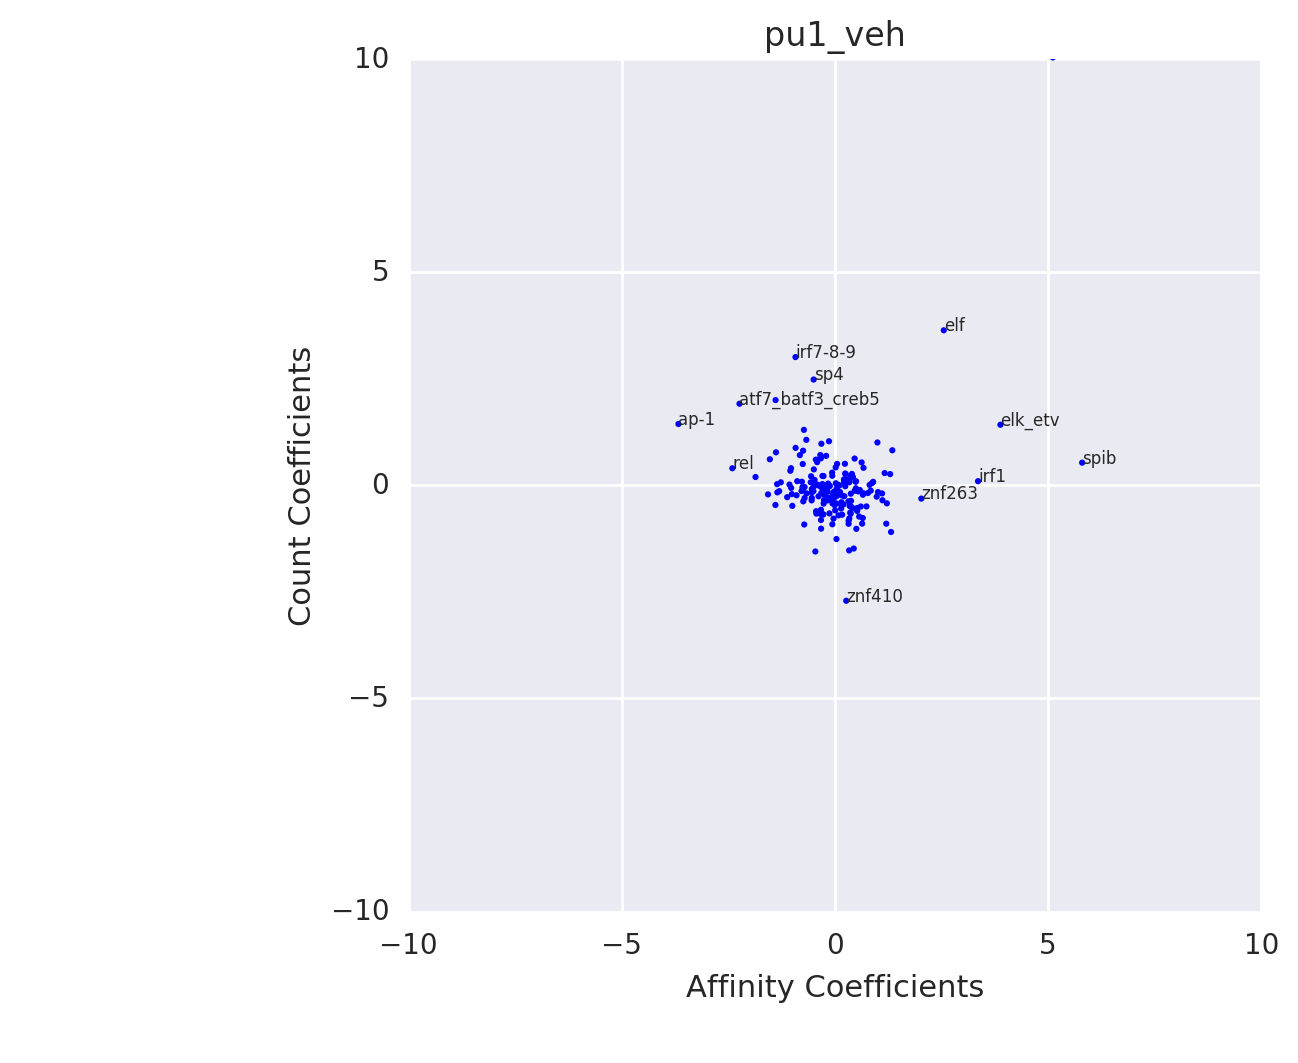

In [968]:
threshold = 2.0
for col in coefficients_ldtf_summedScore_frame:
    weights_summedScore = coefficients_zscore_ldtf_summedScore_frame[col]
    weights_affinity = coefficients_zscore_ldtf_affinity_frame[col]
    weights_count = coefficients_zscore_ldtf_counts_frame[col]
    x_vals = weights_affinity.values
    y_vals = weights_count.values
    motifs = coefficients_affinity_ldtf_frame.index.values
    for i in range(len(x_vals)):
        if abs(x_vals[i]) >= threshold or abs(y_vals[i]) >= threshold:
            plt.annotate(xy=(x_vals[i],y_vals[i]), s = motifs[i], size=6)
    plt.scatter(x_vals, 
                y_vals,
                marker = '.',
               edgecolor='None')
    
    ax = plt.gca()
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    plt.xlabel('Affinity Coefficients')
    plt.ylabel('Count Coefficients')
    plt.title(col)
    plt.show()

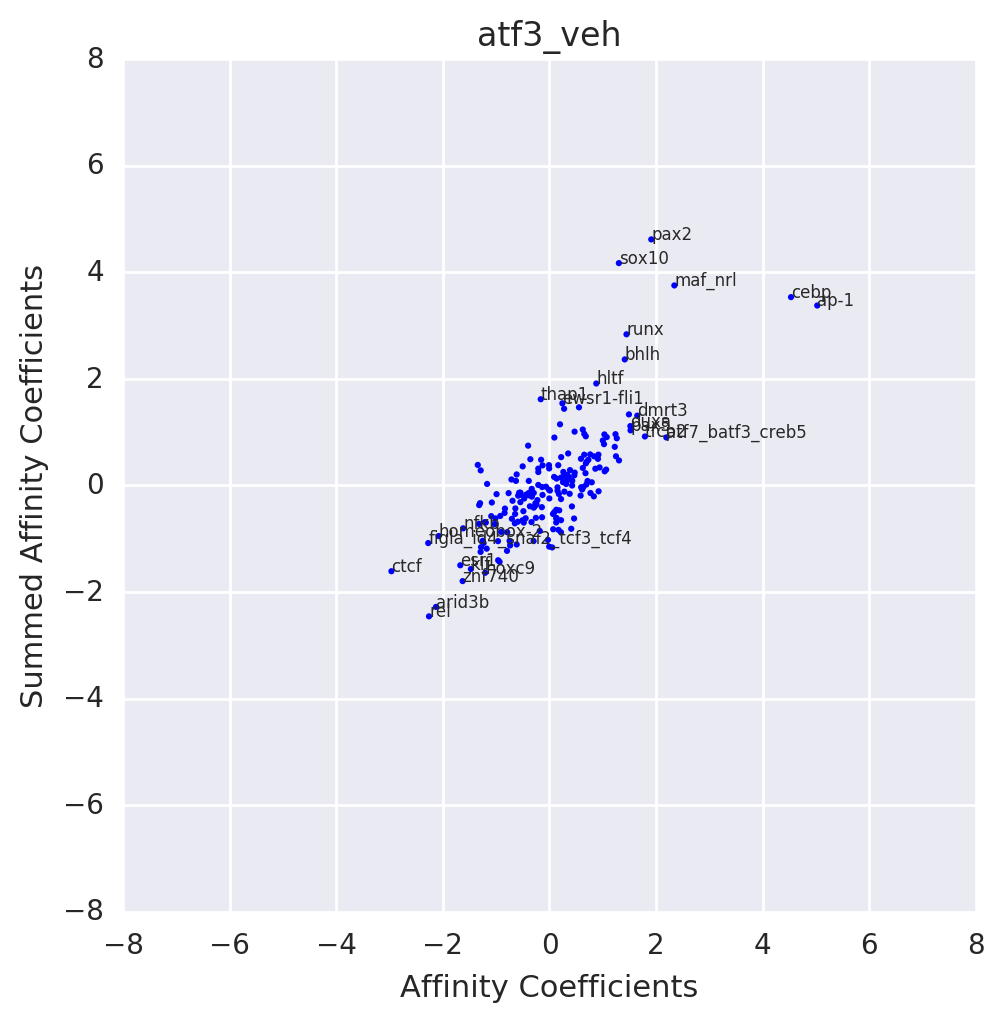

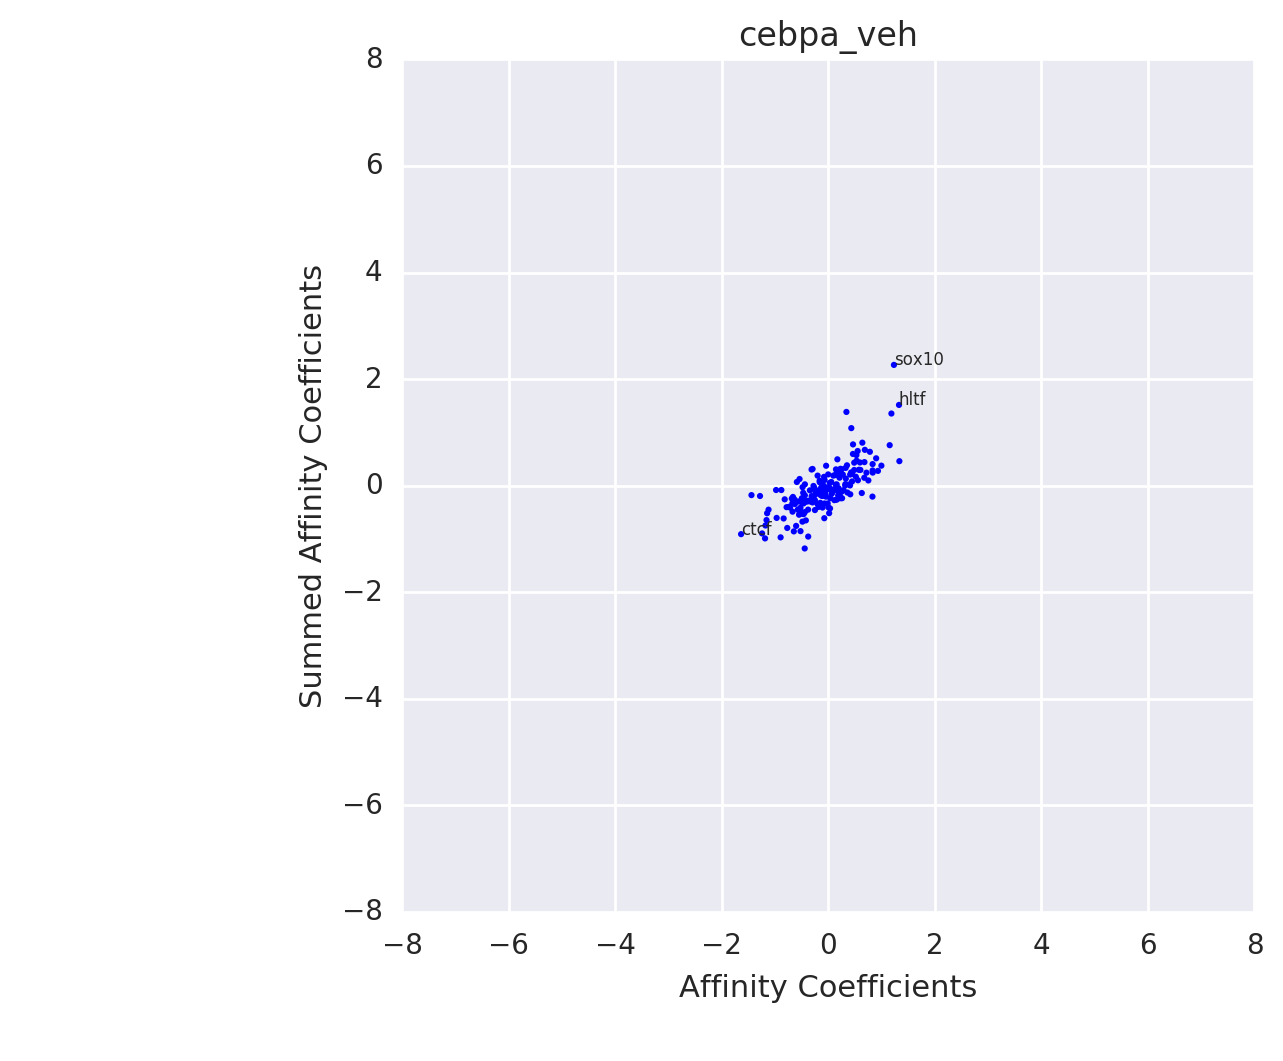

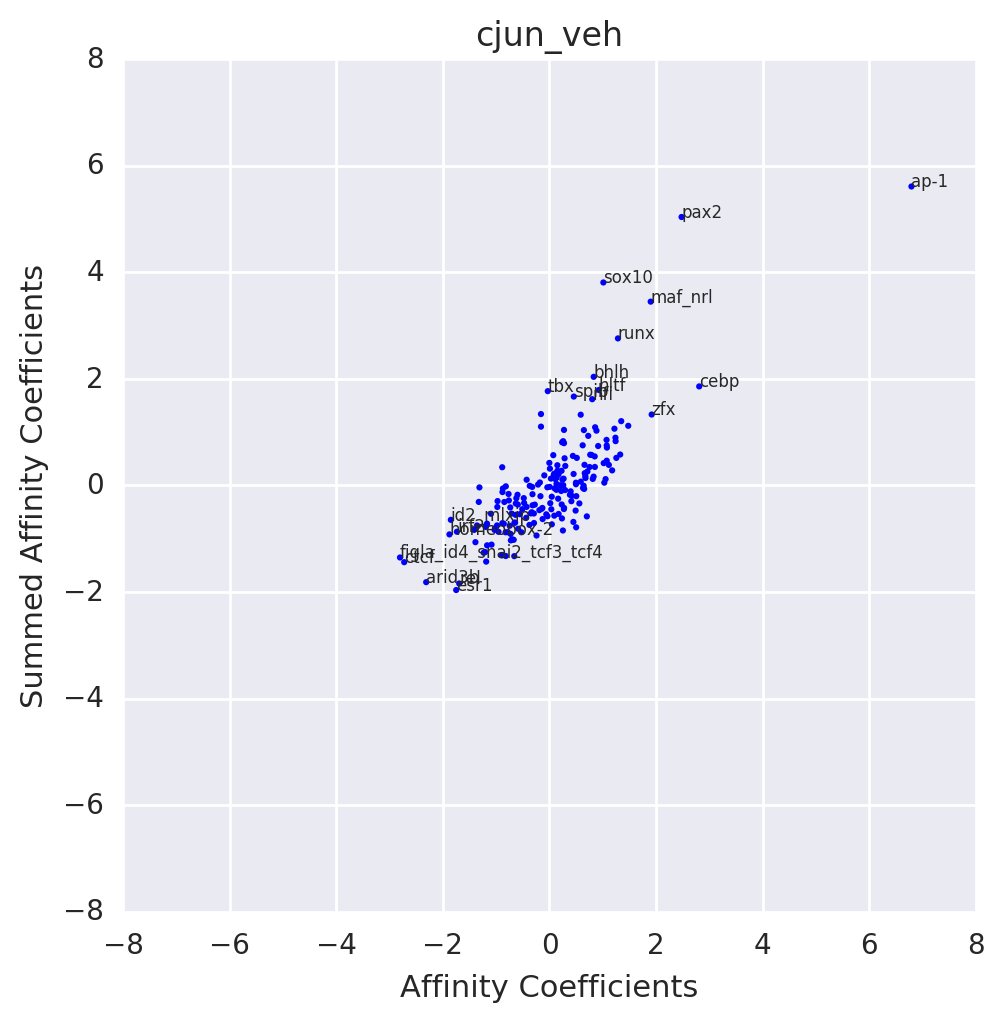

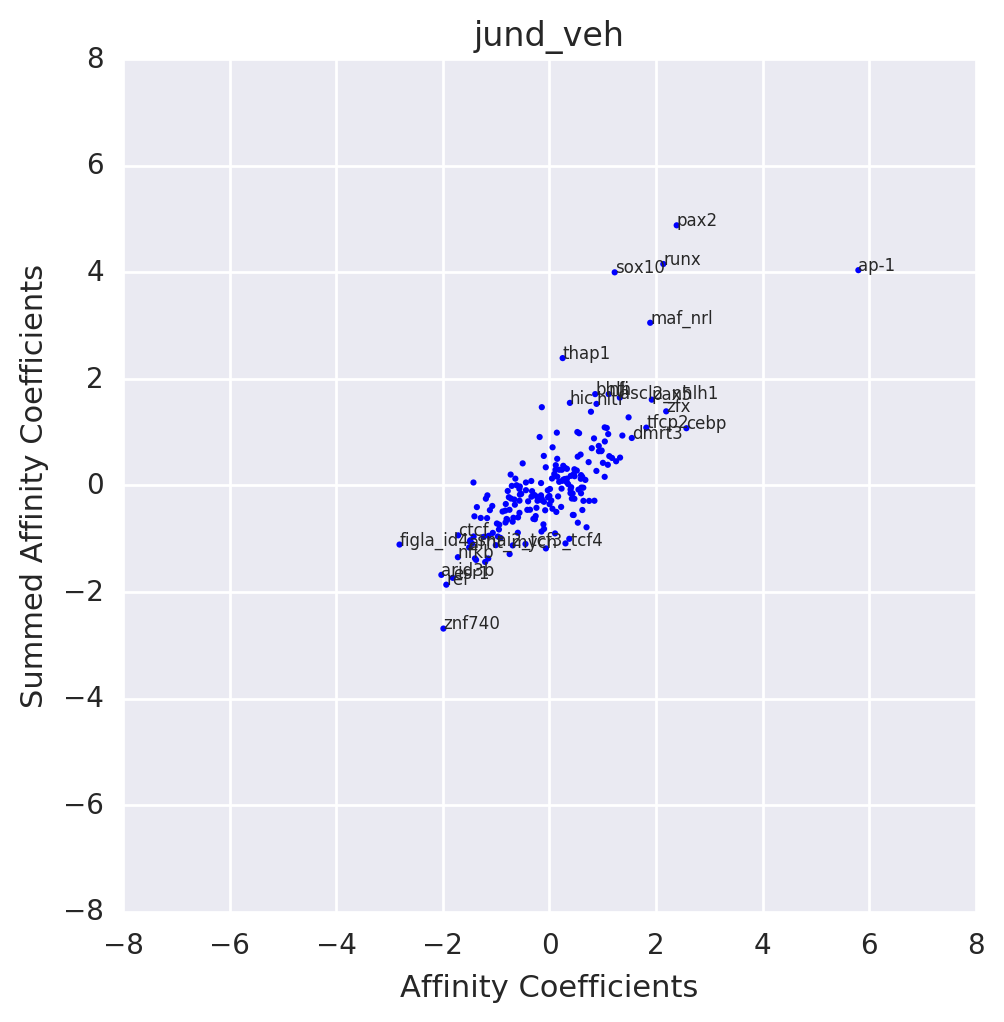

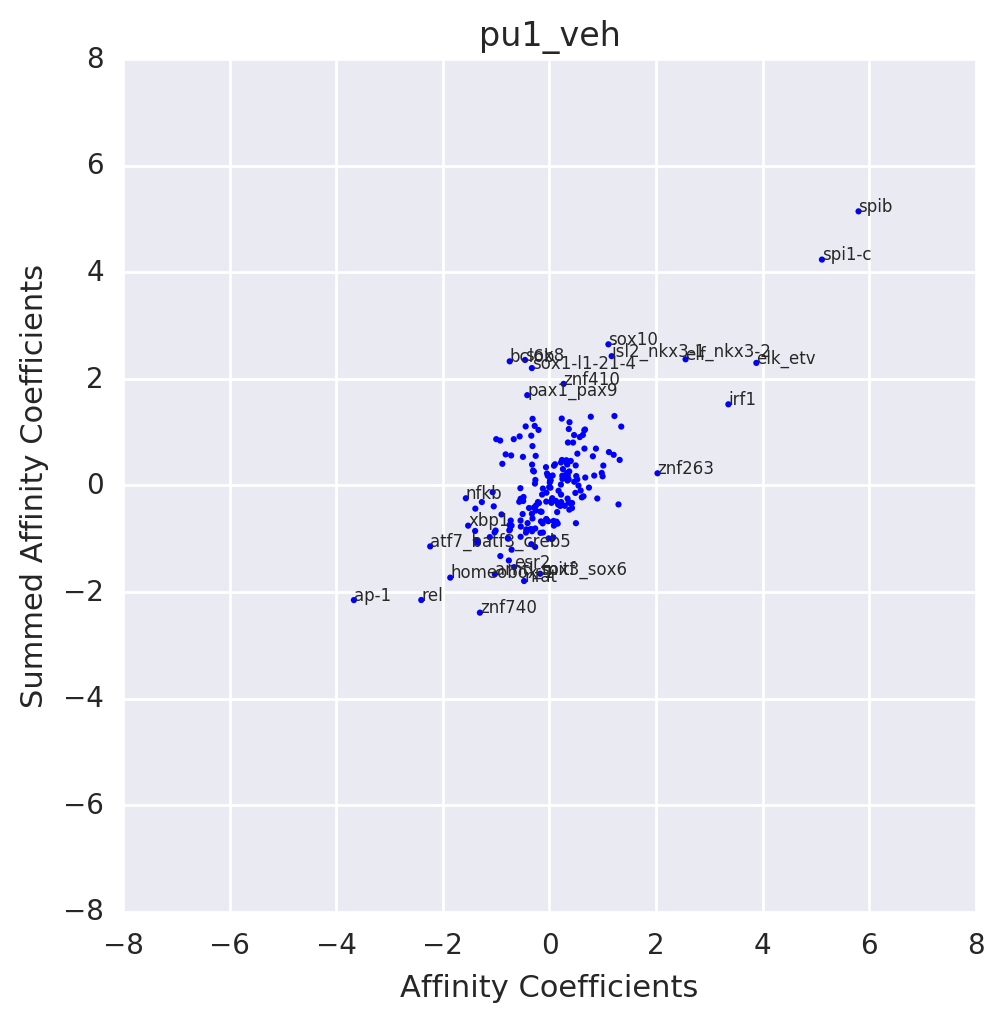

In [970]:
threshold = 1.5
for col in coefficients_ldtf_summedScore_frame:
    weights_summedScore = coefficients_zscore_ldtf_summedScore_frame[col]
    weights_affinity = coefficients_zscore_ldtf_affinity_frame[col]
    weights_count = coefficients_zscore_ldtf_counts_frame[col]
    x_vals = weights_affinity.values
    y_vals = weights_summedScore.values
    motifs = coefficients_affinity_ldtf_frame.index.values
    for i in range(len(x_vals)):
        if abs(x_vals[i]) >= threshold or abs(y_vals[i]) >= threshold:
            plt.annotate(xy=(x_vals[i],y_vals[i]), s = motifs[i], size=6)
    plt.scatter(x_vals, 
                y_vals,
                marker = '.',
               edgecolor='None')
    
    ax = plt.gca()
    plt.xlim(-8,8)
    plt.ylim(-8,8)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    plt.xlabel('Affinity Coefficients')
    plt.ylabel('Summed Affinity Coefficients')
    plt.title(col)
    plt.show()

### AP-1 Only Sanity Check

In [989]:
# for monomers using all motifs
strain = 'c57bl6'
for treatment in ['veh']:
    for monomer in ['atf3', 'cjun', 'jund', 'pu1', 'cebpa']:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        background_indices = standardized_motif_background_frame.index.values     # select subset of background indices to use
        
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_background_frame[standardized_motif_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_features, background_features])[['spib']]
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        all_aucs = []
        all_coefficients = []
        all_probs = None
        all_precisions = []
        all_intercepts = []
        for i in range(numIterations):

            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            probas = affinity_classifier.predict_proba(test_affinity_features)
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            current_coefficients = affinity_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)
            
        mean_coefficients = np.mean(all_coefficients, axis=0)
            
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
               mean_coefficients
             )
        

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.554008675658 5.83595806465e-06 precision: 0.478813919828 9.28641111072e-07 [ 0.27707159]
cjun_veh roc: 0.571510818489 2.02435628056e-05 precision: 0.485790362814 5.27533764801e-06 [ 0.34457273]
jund_veh roc: 0.577626060272 9.3469988583e-06 precision: 0.488874076088 2.64488842429e-06 [ 0.34295669]
pu1_veh roc: 0.635023538242 2.1396654121e-06 precision: 0.503974339988 5.27295783228e-07 [ 0.65475628]
cebpa_veh roc: 0.548763694061 2.06042021698e-06 precision: 0.477218630582 1.74278797115e-06 [ 0.22711522]


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


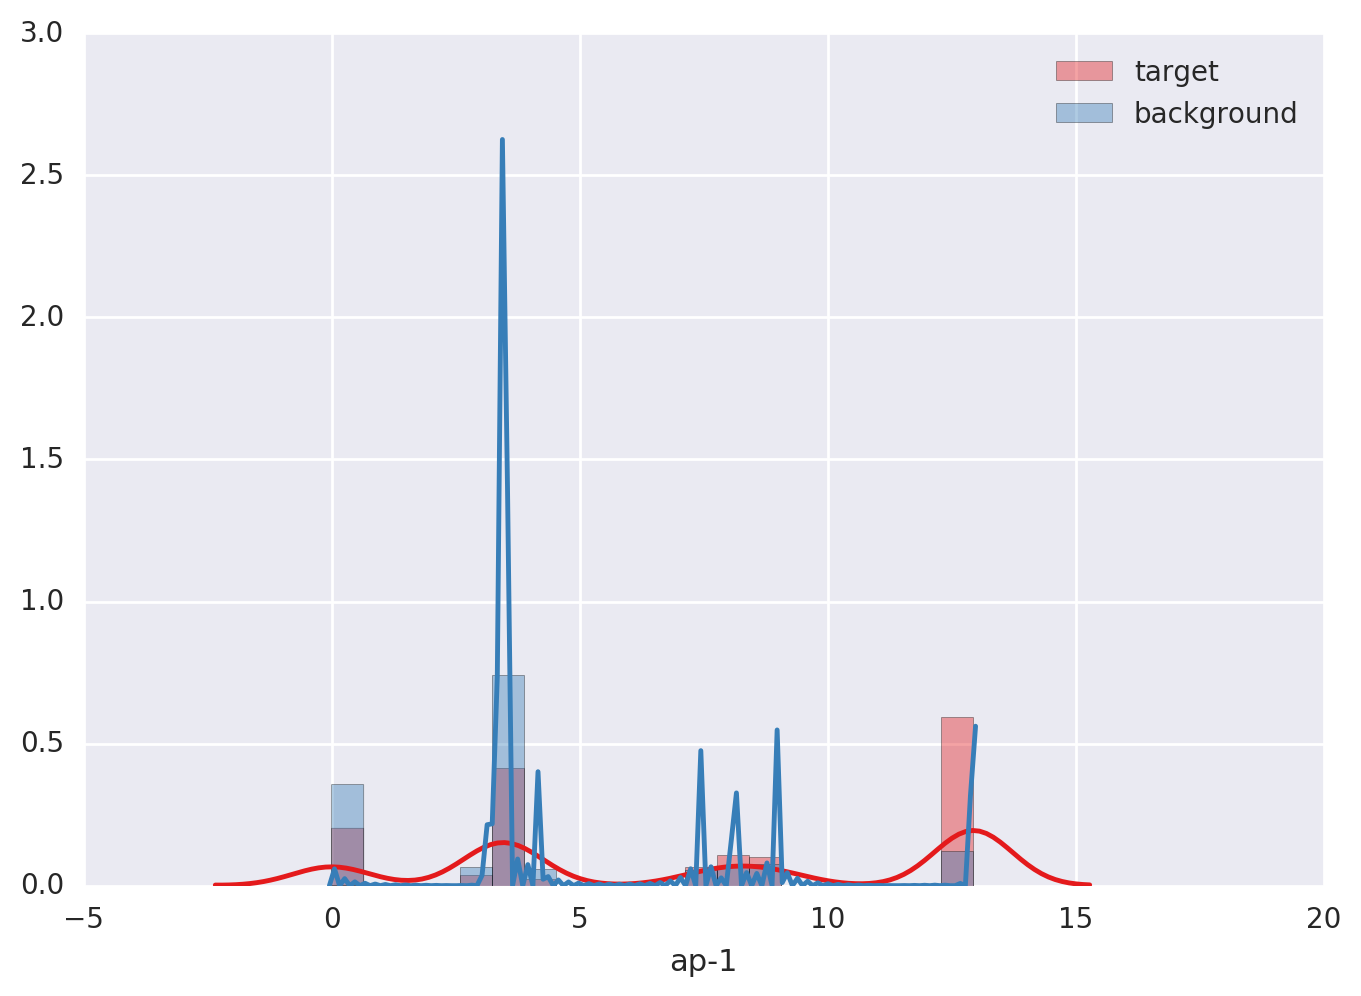

In [1020]:
sns.distplot(motif_score_frame[motif_score_frame.index.isin(
            summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)]['ap-1'], label='target',
            bins=20)
sns.distplot(motif_score_background_frame['ap-1'], label='background', bins=20)
plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


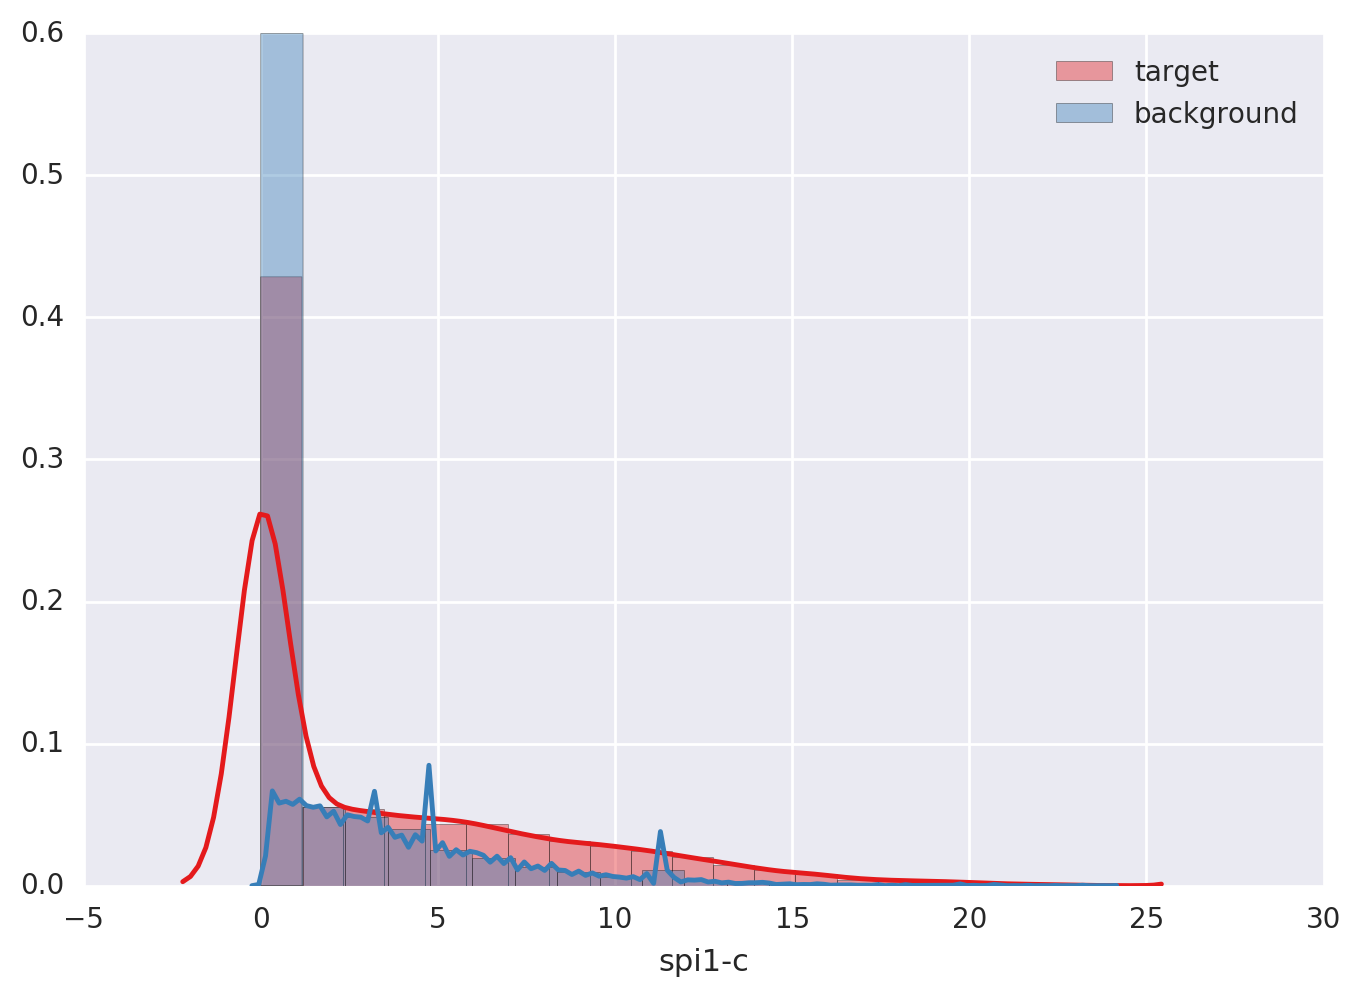

In [1025]:
sns.distplot(motif_score_frame[motif_score_frame.index.isin(
            summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)]['spi1-c'], label='target',
            bins=20)
sns.distplot(motif_score_background_frame['spi1-c'], label='background', bins=20)
plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


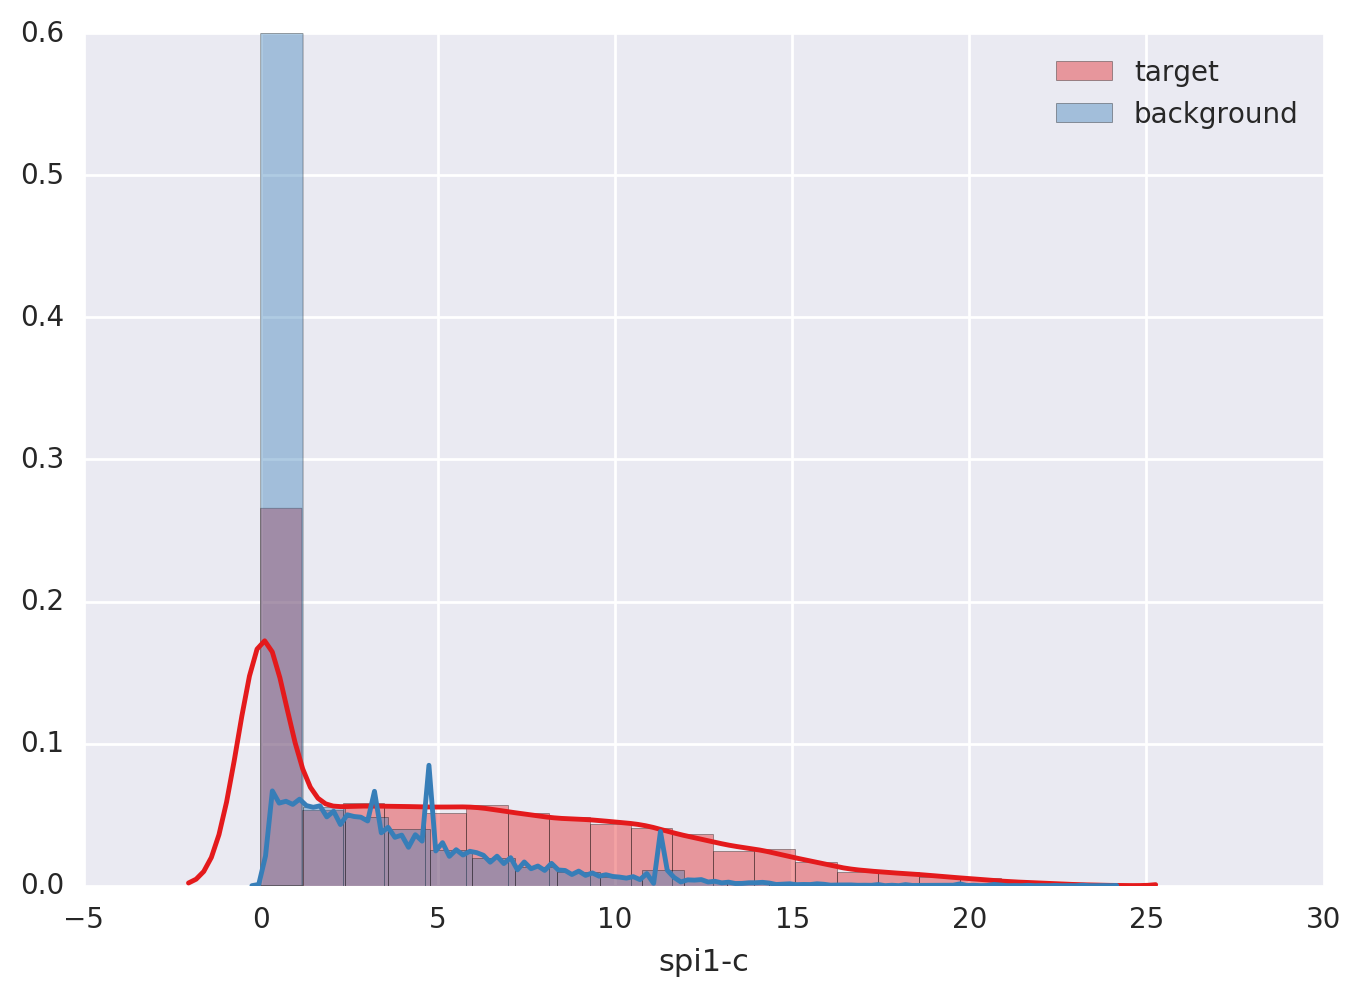

In [1021]:
sns.distplot(motif_score_frame[motif_score_frame.index.isin(
            summary_frame[summary_frame['c57bl6_pu1_veh'] > 0].index.values)]['spi1-c'], label='target',
            bins=20)
sns.distplot(motif_score_background_frame['spi1-c'], label='background', bins=20)
plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


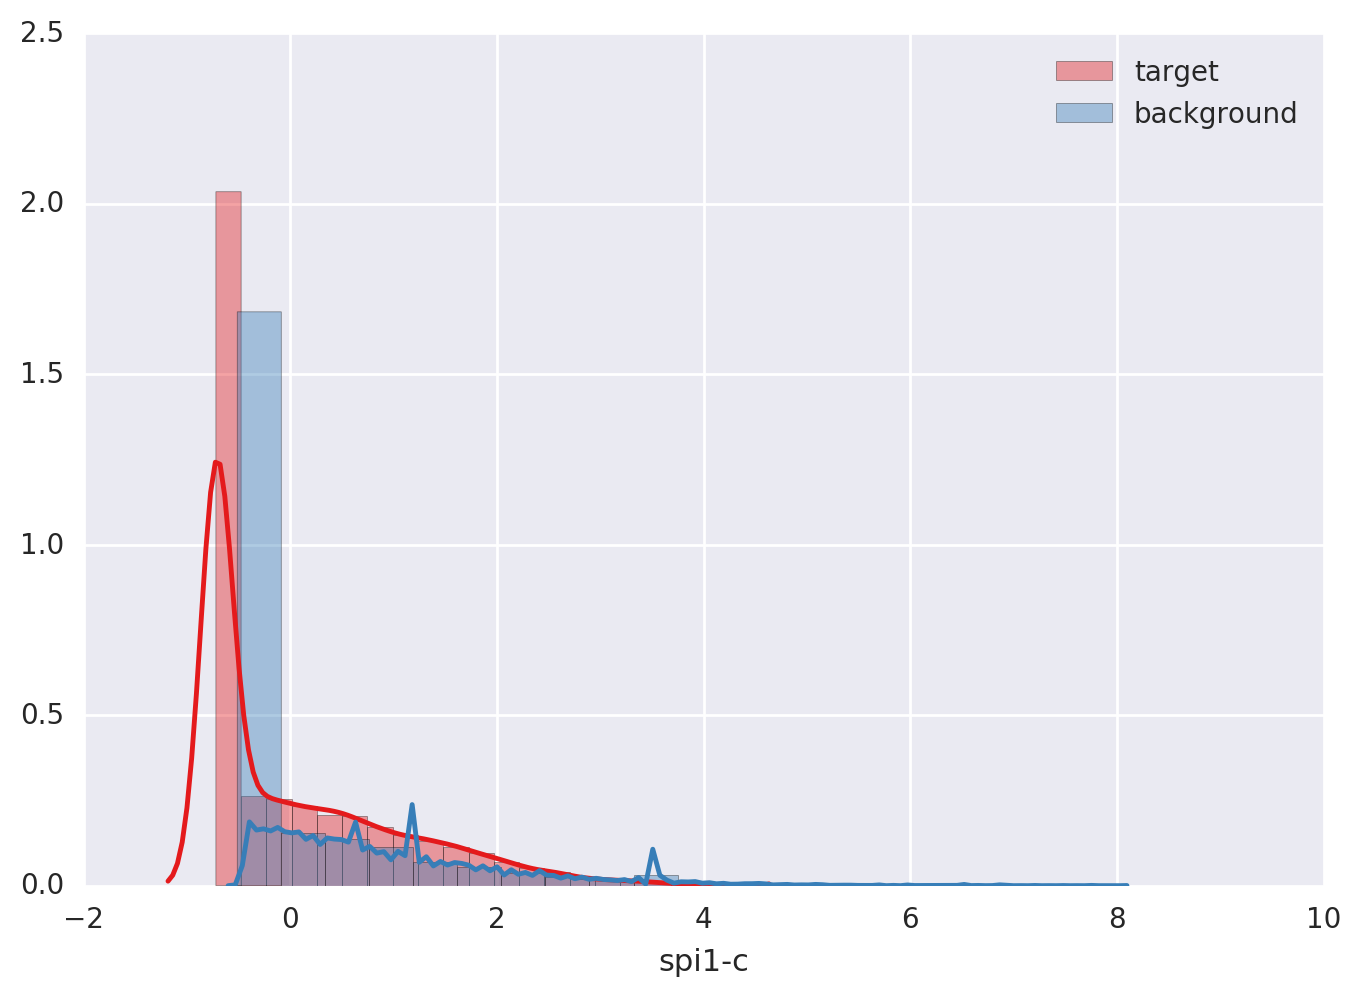

In [1033]:
sns.distplot(standardized_motif_frame[standardized_motif_frame.index.isin(
            summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)]['spi1-c'], label='target',
            bins=20)
sns.distplot(standardized_motif_background_frame['spi1-c'], label='background', bins=20)
plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


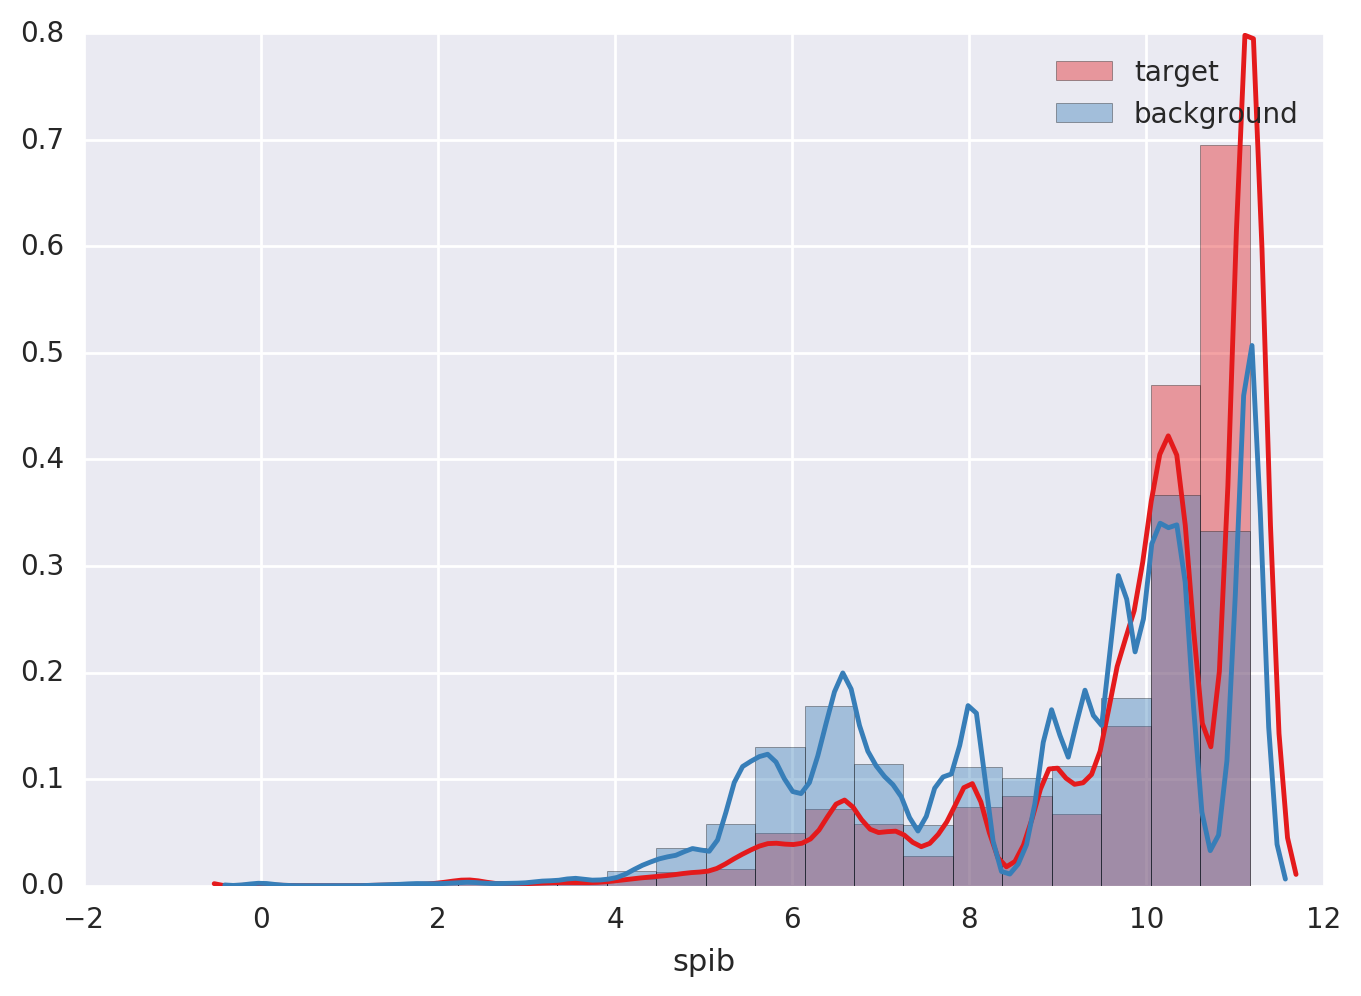

In [1022]:
sns.distplot(motif_score_frame[motif_score_frame.index.isin(
            summary_frame[summary_frame['c57bl6_pu1_veh'] > 0].index.values)]['spib'], label='target',
            bins=20)
sns.distplot(motif_score_background_frame['spib'], label='background', bins=20)
plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


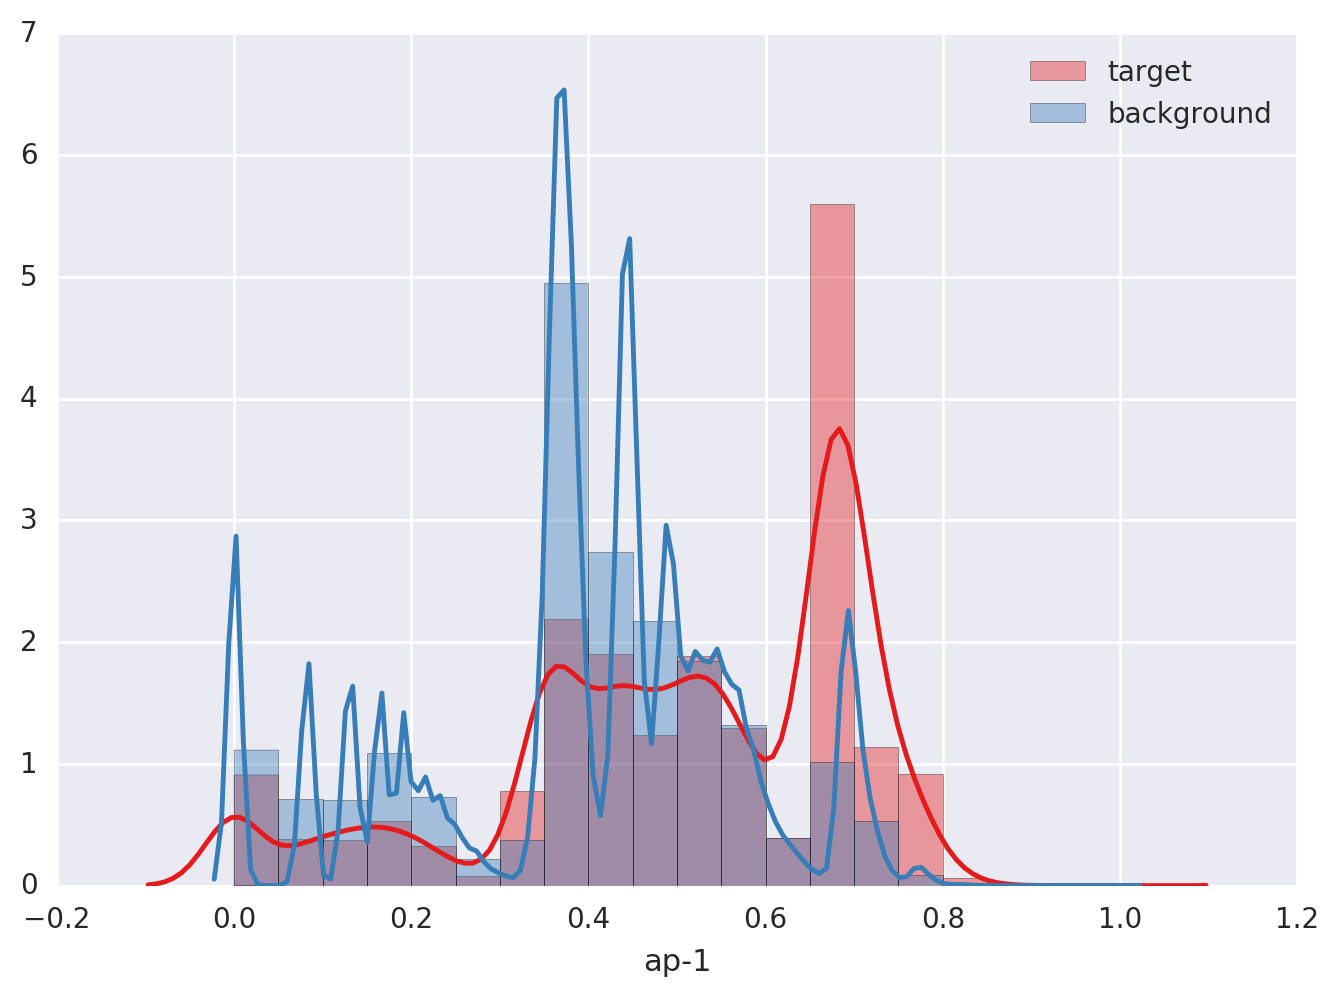

In [1093]:
sns.distplot(normed_summedScore_frame[normed_summedScore_frame.index.isin(
            summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)]['ap-1'], label='target',
            bins=20)
sns.distplot(normed_summedScore_background_frame['ap-1'], label='background', bins=20)
plt.legend()

In [1040]:
with open('/data/archive/16-11-06-glass/undet/grep_out.fastq') as f:
    data = f.readlines()

In [1049]:
outFile = open('/data/archive/16-11-06-glass/undet/grep_out_cleaned.fastq', 'w')
for line in data:
    if not line.strip() == '--':
        outFile.write(line)
outFile.close()